# Caltech EV Charging data Energy Demand Predictions

In [1]:
import numpy
import pandas as pd
import json
import datetime
file_path = './acndata_sessions.json'

with open(file_path, "r") as read_file:
    data = json.load(read_file)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
file_path = './acndata_sessions.json'

with open(file_path, "r") as read_file:
    data = json.load(read_file)

In [4]:
def singleNumeric(data):
    data = data.apply(pd.to_numeric, errors='coerce')
    data.fillna(0, inplace=True)
    return data

In [5]:
scaler=StandardScaler()

def scaleData(data):
    scaler.fit(data)
    return scaler.transform(data)

In [6]:
df = pd.DataFrame(data['_items'])

Convert time related columns to datetime

Extract year, month, calendar week, day and day of week from the connectionTime as these individual pieces of time info are valuable.

In [7]:
df["connectionTime"] = pd.to_datetime(df["connectionTime"])
df["disconnectTime"] = pd.to_datetime(df["disconnectTime"])
df["doneChargingTime"] = pd.to_datetime(df["doneChargingTime"])
df['connectionTime_year'] = df['connectionTime'].dt.year
df['connectionTime_month'] = df['connectionTime'].dt.month
df['connectionTime_week'] = df['connectionTime'].dt.isocalendar().week
df['connectionTime_day'] = df['connectionTime'].dt.day
df['connectionTime_dayofweek'] = df['connectionTime'].dt.dayofweek

Drop columns that aren't useful

In [8]:
df = df.drop("timezone", axis=1)
df = df.drop("stationID", axis=1)
df = df.drop("userID", axis=1)
df = df.drop("sessionID", axis=1)
df = df.drop("clusterID", axis=1)
df = df.drop("userInputs", axis=1)

In [9]:
def models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled):
    
    # Define sequential model, two input layers, 11 input dimensions as there are 11 columns
    model = Sequential()
    model.add(Dense(128, input_dim=11, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #Output layer
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()

    history = model.fit(x_trainScaled, y_train, validation_split=0.2, epochs =100)

    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Predict on test data
    predictions = model.predict(x_testScaled[:5])
    print("\nPredicted values are: \n", predictions)
    print("\nReal values are: \n", y_test[:5])

    #Comparison with other models..
    #Neural network - from the current code
    mse_neural, mae_neural = model.evaluate(x_testScaled, y_test)
    print('\nMean squared error from neural net: \n', mse_neural)
    print('\nMean absolute error from neural net: \n', mae_neural)

    x_testScaled_reshape = x_testScaled.reshape(x_testScaled.shape[0], x_testScaled.shape[1], 1)
    x_test_timesteps, x_test_features= x_testScaled_reshape.shape[1], x_testScaled_reshape.shape[2]

    n_outputs = y_train.shape[0]
    
    # Convolutional Neural Net
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_test_timesteps,x_test_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    #Predict on test data
    predictions = model.predict(x_testScaled_reshape[:5])
    print("\nPredicted values are:\n ", predictions)
    print("\nReal values are: \n", y_test[:5])

    #Comparison with other models..
    mse_neural, mae_neural = model.evaluate(x_testScaled_reshape, y_test)
    print('\nMean squared error from Convolutional neural net: ', mse_neural)
    print('\nMean absolute error from Convolutional neural net: ', mae_neural)

    ### Linear regression
    lr_model = linear_model.LinearRegression()
    lr_model.fit(x_trainScaled, y_train)
    y_pred_lr = lr_model.predict(x_testScaled)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    print('\nMean squared error from linear regression: ', mse_lr)
    print('\nMean absolute error from linear regression: ', mae_lr)

    tree = DecisionTreeRegressor()
    tree.fit(x_trainScaled, y_train)
    y_pred_tree = tree.predict(x_testScaled)
    mse_dt = mean_squared_error(y_test, y_pred_tree)
    mae_dt = mean_absolute_error(y_test, y_pred_tree)
    print('\nMean squared error using decision tree: ', mse_dt)
    print('\nMean absolute error using decision tree: ', mae_dt)

    #Random forest.
    model = RandomForestRegressor(n_estimators = 100, random_state=0)
    model.fit(x_trainScaled, y_train)

    y_pred_RF = model.predict(x_testScaled)

    mse_RF = mean_squared_error(y_test, y_pred_RF)
    mae_RF = mean_absolute_error(y_test, y_pred_RF)
    print('\nMean squared error using Random Forest: ', mse_RF)
    print('\nMean absolute error Using Random Forest: ', mae_RF)

    #Feature ranking...
    feature_list = list(x_train.columns)
    feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
    print("\n The features ranking by importance to the RF Model")
    print("\n", feature_imp)

# Predict 1 Day with 2 Weeks of Data

In [10]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [11]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [12]:
test = test.loc[test['connectionTime_day'] == 22]

In [13]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [14]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 32ms/step - loss: 446.8829 - mean_absolute_error: 14.9778 - val_loss: 290.7518 - val_mean_absolute_error: 12.1061
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 432.9399 - mean_absolute_error: 14.5494 - val_loss: 282.4376 - val_mean_absolute_error: 11.7651
Epoch 3/100
5/5 [==============================] 

Epoch 46/100
5/5 [==============================] - 0s 5ms/step - loss: 152.0129 - mean_absolute_error: 9.0246 - val_loss: 115.2938 - val_mean_absolute_error: 8.4713
Epoch 47/100
5/5 [==============================] - 0s 10ms/step - loss: 152.2235 - mean_absolute_error: 8.9510 - val_loss: 113.4917 - val_mean_absolute_error: 8.3835
Epoch 48/100
5/5 [==============================] - 0s 11ms/step - loss: 151.7575 - mean_absolute_error: 8.8726 - val_loss: 111.9744 - val_mean_absolute_error: 8.3004
Epoch 49/100
5/5 [==============================] - 0s 6ms/step - loss: 151.6254 - mean_absolute_error: 8.8642 - val_loss: 110.5986 - val_mean_absolute_error: 8.2266
Epoch 50/100
5/5 [==============================] - 0s 5ms/step - loss: 151.8394 - mean_absolute_error: 8.9045 - val_loss: 109.8310 - val_mean_absolute_error: 8.1853
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 151.5754 - mean_absolute_error: 8.8717 - val_loss: 109.4827 - val_mean_absolute_error: 8.1609
Ep

5/5 [==============================] - 0s 12ms/step - loss: 150.9706 - mean_absolute_error: 8.9324 - val_loss: 107.1748 - val_mean_absolute_error: 8.0319
Epoch 96/100
5/5 [==============================] - 0s 6ms/step - loss: 150.2267 - mean_absolute_error: 8.8438 - val_loss: 105.7652 - val_mean_absolute_error: 7.9524
Epoch 97/100
5/5 [==============================] - 0s 5ms/step - loss: 150.0213 - mean_absolute_error: 8.8146 - val_loss: 105.2759 - val_mean_absolute_error: 7.9278
Epoch 98/100
5/5 [==============================] - 0s 5ms/step - loss: 150.1825 - mean_absolute_error: 8.8142 - val_loss: 104.5480 - val_mean_absolute_error: 7.8836
Epoch 99/100
5/5 [==============================] - 0s 6ms/step - loss: 149.9910 - mean_absolute_error: 8.8340 - val_loss: 104.3066 - val_mean_absolute_error: 7.8710
Epoch 100/100
5/5 [==============================] - 0s 6ms/step - loss: 149.9439 - mean_absolute_error: 8.8501 - val_loss: 103.5240 - val_mean_absolute_error: 7.8197


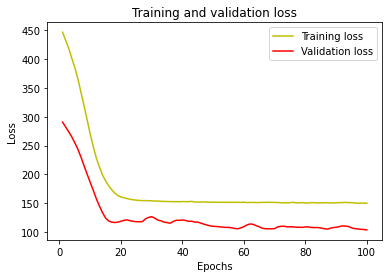


Predicted values are: 
 [[23.188128]
 [23.093111]
 [ 5.363755]
 [ 7.227361]
 [22.83689 ]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 73.4909 - mean_absolute_error: 6.8156

Mean squared error from neural net: 
 73.49085235595703

Mean absolute error from neural net: 
 6.815640449523926

Predicted values are:
  [[0.00605598 0.00576391 0.00586743 0.00588813 0.00619456 0.00622431
  0.00615142 0.00573931 0.00585592 0.00627202 0.00610523 0.00592894
  0.00574013 0.00591267 0.00572257 0.00573579 0.00541993 0.00602345
  0.00577719 0.00570145 0.00600909 0.00606197 0.00594217 0.00626342
  0.00573011 0.00553153 0.00613447 0.0060372  0.00599518 0.00551819
  0.00610556 0.00555537 0.00593752 0.00568125 0.00557024 0.00558205
  0.00543469 0.00584889 0.00534284 0.00629928 0.00617149 0.00619762
  0.0057585  0.00596379 0.00531754 0.00546543 0.00599686 0.0

1/1 [==============================] - 0s 157ms/step - loss: 241.7187 - mean_absolute_error: 12.8509

Mean squared error from Convolutional neural net:  241.71868896484375

Mean absolute error from Convolutional neural net:  12.850878715515137

Mean squared error from linear regression:  4948.528207046237

Mean absolute error from linear regression:  38.873708566659964

Mean squared error using decision tree:  76.981397

Mean absolute error using decision tree:  6.977545454545455

Mean squared error using Random Forest:  148.65500502650914

Mean absolute error Using Random Forest:  10.139829090909092

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000
conn

In [15]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 73.11471557617188

Mean absolute error from neural net: 
 6.979510307312012

 Mean squared error using Random Forest:  148.65500502650914

Mean absolute error Using Random Forest:  10.139829090909092


# Predict 3 Days with 2 Weeks in May 2021 - All SpaceID

In [16]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [17]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [18]:
test = test.loc[test['connectionTime_day'].isin([22,23,24])]

In [19]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [20]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 27ms/step - loss: 454.7115 - mean_absolute_error: 15.2211 - val_loss: 291.4041 - val_mean_absolute_error: 12.0260
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 440.1536 - mean_absolute_error: 14.7651 - val_loss: 282.2428 - val_mean_absolute_error: 11.6453
Epoch 3/100
5/5 [==============================

Epoch 46/100
5/5 [==============================] - 0s 5ms/step - loss: 152.8928 - mean_absolute_error: 9.0318 - val_loss: 118.1631 - val_mean_absolute_error: 8.6009
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 152.6190 - mean_absolute_error: 9.0805 - val_loss: 119.9887 - val_mean_absolute_error: 8.7170
Epoch 48/100
5/5 [==============================] - 0s 5ms/step - loss: 152.9894 - mean_absolute_error: 9.1195 - val_loss: 122.3578 - val_mean_absolute_error: 8.8622
Epoch 49/100
5/5 [==============================] - 0s 5ms/step - loss: 152.8204 - mean_absolute_error: 9.0936 - val_loss: 121.3373 - val_mean_absolute_error: 8.7993
Epoch 50/100
5/5 [==============================] - 0s 5ms/step - loss: 152.5713 - mean_absolute_error: 9.0824 - val_loss: 122.1836 - val_mean_absolute_error: 8.8511
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 152.7182 - mean_absolute_error: 9.1090 - val_loss: 121.1336 - val_mean_absolute_error: 8.7883
Epoc

5/5 [==============================] - 0s 5ms/step - loss: 150.2679 - mean_absolute_error: 8.7054 - val_loss: 106.0791 - val_mean_absolute_error: 7.9504
Epoch 96/100
5/5 [==============================] - 0s 5ms/step - loss: 150.0627 - mean_absolute_error: 8.7396 - val_loss: 106.3262 - val_mean_absolute_error: 7.9572
Epoch 97/100
5/5 [==============================] - 0s 5ms/step - loss: 149.9371 - mean_absolute_error: 8.7421 - val_loss: 106.3060 - val_mean_absolute_error: 7.9514
Epoch 98/100
5/5 [==============================] - 0s 5ms/step - loss: 149.7347 - mean_absolute_error: 8.7626 - val_loss: 108.4025 - val_mean_absolute_error: 8.0719
Epoch 99/100
5/5 [==============================] - 0s 5ms/step - loss: 149.7723 - mean_absolute_error: 8.8391 - val_loss: 112.6722 - val_mean_absolute_error: 8.3060
Epoch 100/100
5/5 [==============================] - 0s 5ms/step - loss: 150.1857 - mean_absolute_error: 8.9428 - val_loss: 116.3284 - val_mean_absolute_error: 8.5180


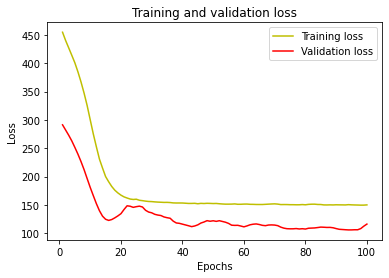


Predicted values are: 
 [[26.908644]
 [26.871101]
 [ 8.930483]
 [ 8.438201]
 [26.783384]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 1ms/step - loss: 119.3013 - mean_absolute_error: 9.2080

Mean squared error from neural net: 
 119.30134582519531

Mean absolute error from neural net: 
 9.208005905151367

Predicted values are:
  [[0.00552979 0.00507861 0.0067777  0.0059344  0.00562072 0.00554502
  0.00553465 0.00546132 0.00485554 0.00634341 0.0047524  0.00630971
  0.0054718  0.00591349 0.00634847 0.0062997  0.00575097 0.00672566
  0.00616732 0.00578774 0.00664629 0.0055065  0.00549361 0.00643683
  0.00557118 0.00580608 0.00594332 0.00595606 0.00675888 0.00615256
  0.00575398 0.00636435 0.00509084 0.00567676 0.00591199 0.00582035
  0.00641759 0.00549149 0.00615676 0.00611398 0.00554653 0.00595943
  0.00588285 0.00647611 0.00541406 0.00665527 0.00555362 0.

2/2 [==============================] - 0s 2ms/step - loss: 209.0930 - mean_absolute_error: 10.2987

Mean squared error from Convolutional neural net:  209.0929718017578

Mean absolute error from Convolutional neural net:  10.298651695251465

Mean squared error from linear regression:  336.49808908576375

Mean absolute error from linear regression:  12.149743707123902

Mean squared error using decision tree:  211.59905981578945

Mean absolute error using decision tree:  9.025552631578947

Mean squared error using Random Forest:  118.26499309245271

Mean absolute error Using Random Forest:  8.835013684210532

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.00000

In [21]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 105.27364349365234

Mean absolute error from neural net: 
 8.460984230041504


Mean squared error using Random Forest:  118.26499309245271

Mean absolute error Using Random Forest:  8.835013684210532

# Predict 5 Days with 2 Weeks of Data

In [22]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [23]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [24]:
test = test.loc[test['connectionTime_day'].isin([22,23,24,25,26])]

In [25]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [26]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 26ms/step - loss: 439.2839 - mean_absolute_error: 14.7437 - val_loss: 294.1223 - val_mean_absolute_error: 12.2277
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 425.0527 - mean_absolute_error: 14.2483 - val_loss: 282.8133 - val_mean_absolute_error: 11.7359
Epoch 3/100
5/5 [=============================

Epoch 46/100
5/5 [==============================] - 0s 5ms/step - loss: 151.4528 - mean_absolute_error: 8.8684 - val_loss: 108.4463 - val_mean_absolute_error: 8.1076
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 151.2460 - mean_absolute_error: 8.8324 - val_loss: 107.7345 - val_mean_absolute_error: 8.0667
Epoch 48/100
5/5 [==============================] - 0s 5ms/step - loss: 151.1049 - mean_absolute_error: 8.8550 - val_loss: 106.5957 - val_mean_absolute_error: 8.0027
Epoch 49/100
5/5 [==============================] - 0s 5ms/step - loss: 151.1803 - mean_absolute_error: 8.9012 - val_loss: 106.2039 - val_mean_absolute_error: 7.9798
Epoch 50/100
5/5 [==============================] - 0s 5ms/step - loss: 151.0020 - mean_absolute_error: 8.8976 - val_loss: 106.0285 - val_mean_absolute_error: 7.9789
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 151.2932 - mean_absolute_error: 8.8948 - val_loss: 106.0791 - val_mean_absolute_error: 7.9993
Epoc

5/5 [==============================] - 0s 5ms/step - loss: 149.5867 - mean_absolute_error: 8.8932 - val_loss: 109.0970 - val_mean_absolute_error: 8.1221
Epoch 96/100
5/5 [==============================] - 0s 5ms/step - loss: 149.5326 - mean_absolute_error: 8.8823 - val_loss: 107.0171 - val_mean_absolute_error: 8.0068
Epoch 97/100
5/5 [==============================] - 0s 5ms/step - loss: 149.5889 - mean_absolute_error: 8.8892 - val_loss: 105.6539 - val_mean_absolute_error: 7.9316
Epoch 98/100
5/5 [==============================] - 0s 5ms/step - loss: 149.2042 - mean_absolute_error: 8.8690 - val_loss: 104.5479 - val_mean_absolute_error: 7.8820
Epoch 99/100
5/5 [==============================] - 0s 5ms/step - loss: 149.0502 - mean_absolute_error: 8.8317 - val_loss: 103.9320 - val_mean_absolute_error: 7.8470
Epoch 100/100
5/5 [==============================] - 0s 5ms/step - loss: 148.9305 - mean_absolute_error: 8.7869 - val_loss: 102.9158 - val_mean_absolute_error: 7.7673


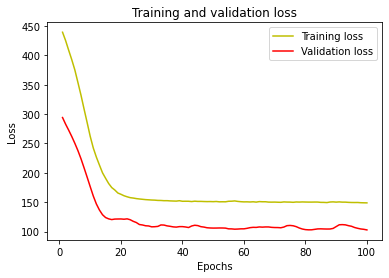


Predicted values are: 
 [[23.609156]
 [23.592024]
 [ 9.092439]
 [ 9.096103]
 [23.561724]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 133.9893 - mean_absolute_error: 8.5575

Mean squared error from neural net: 
 133.9893035888672

Mean absolute error from neural net: 
 8.557459831237793

Predicted values are:
  [[0.00493238 0.00596881 0.00623506 0.00581074 0.00553901 0.00556256
  0.00649319 0.00616988 0.00603675 0.00614051 0.00649062 0.005903
  0.0053275  0.00524724 0.00597269 0.00586144 0.00463679 0.0061768
  0.00549812 0.00553773 0.00525722 0.00617346 0.00495433 0.00655749
  0.00474388 0.00522072 0.00594318 0.00615204 0.00762464 0.00538946
  0.00555649 0.00704197 0.00611147 0.00543512 0.00567252 0.00570366
  0.00644733 0.00681221 0.00515098 0.00563445 0.00637869 0.00553244
  0.00556839 0.00635422 0.00596896 0.00574247 0.0056844  0.0054

3/3 [==============================] - 0s 2ms/step - loss: 267.7458 - mean_absolute_error: 11.6811

Mean squared error from Convolutional neural net:  267.7457580566406

Mean absolute error from Convolutional neural net:  11.681137084960938

Mean squared error from linear regression:  169.91721082097612

Mean absolute error from linear regression:  9.59207799610515

Mean squared error using decision tree:  188.81021720895524

Mean absolute error using decision tree:  10.177805970149254

Mean squared error using Random Forest:  158.4821466998239

Mean absolute error Using Random Forest:  10.196450149253732

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000

In [27]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 133.3348846435547

Mean absolute error from neural net: 
 8.514357566833496

 Mean squared error using Random Forest:  158.4821466998239

Mean absolute error Using Random Forest:  10.196450149253732

# Predict 1 Week with 2 weeks of data

In [28]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [29]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [30]:
test = test.loc[test['connectionTime_day'].isin([22,23,24,25,26,27,28])]

In [31]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [32]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 31ms/step - loss: 456.8986 - mean_absolute_error: 15.2525 - val_loss: 298.5940 - val_mean_absolute_error: 12.4035
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 444.1003 - mean_absolute_error: 14.8875 - val_loss: 289.0013 - val_mean_absolute_error: 12.0339
Epoch 3/100
5/5 [==============================

Epoch 46/100
5/5 [==============================] - 0s 5ms/step - loss: 152.9312 - mean_absolute_error: 8.9854 - val_loss: 112.5553 - val_mean_absolute_error: 8.3101
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 152.5466 - mean_absolute_error: 8.9218 - val_loss: 110.9343 - val_mean_absolute_error: 8.2391
Epoch 48/100
5/5 [==============================] - 0s 5ms/step - loss: 152.8362 - mean_absolute_error: 8.8732 - val_loss: 110.9703 - val_mean_absolute_error: 8.2447
Epoch 49/100
5/5 [==============================] - 0s 5ms/step - loss: 152.6103 - mean_absolute_error: 8.8426 - val_loss: 111.1918 - val_mean_absolute_error: 8.2440
Epoch 50/100
5/5 [==============================] - ETA: 0s - loss: 115.7425 - mean_absolute_error: 8.224 - 0s 5ms/step - loss: 152.3264 - mean_absolute_error: 8.8503 - val_loss: 111.2561 - val_mean_absolute_error: 8.2378
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 152.3221 - mean_absolute_error: 8.8926 - v

Epoch 95/100
5/5 [==============================] - 0s 5ms/step - loss: 150.1033 - mean_absolute_error: 8.7127 - val_loss: 102.8429 - val_mean_absolute_error: 7.8372
Epoch 96/100
5/5 [==============================] - 0s 5ms/step - loss: 150.2262 - mean_absolute_error: 8.7080 - val_loss: 102.7230 - val_mean_absolute_error: 7.8290
Epoch 97/100
5/5 [==============================] - 0s 5ms/step - loss: 150.0795 - mean_absolute_error: 8.7403 - val_loss: 102.9174 - val_mean_absolute_error: 7.8361
Epoch 98/100
5/5 [==============================] - 0s 5ms/step - loss: 150.0023 - mean_absolute_error: 8.7385 - val_loss: 102.1688 - val_mean_absolute_error: 7.7845
Epoch 99/100
5/5 [==============================] - 0s 5ms/step - loss: 149.8387 - mean_absolute_error: 8.7075 - val_loss: 101.7621 - val_mean_absolute_error: 7.7509
Epoch 100/100
5/5 [==============================] - 0s 5ms/step - loss: 150.0354 - mean_absolute_error: 8.6897 - val_loss: 101.9605 - val_mean_absolute_error: 7.7631


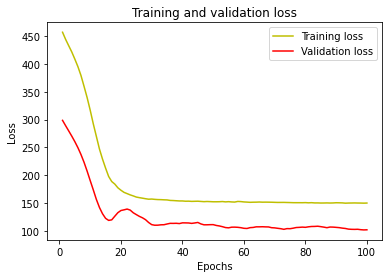


Predicted values are: 
 [[22.970682]
 [22.953142]
 [ 9.049913]
 [ 8.997738]
 [22.90781 ]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 132.9788 - mean_absolute_error: 8.4629

Mean squared error from neural net: 
 132.9788055419922

Mean absolute error from neural net: 
 8.462851524353027

Predicted values are:
  [[0.00597846 0.00578021 0.00575307 0.00532955 0.00567916 0.00527585
  0.00475446 0.00633567 0.00559392 0.00624209 0.00642458 0.00563102
  0.00635631 0.00634485 0.00569402 0.00594934 0.00587792 0.00571752
  0.00585477 0.00641024 0.00605226 0.00628494 0.00569518 0.00566375
  0.00562801 0.00562717 0.00590736 0.00595003 0.00570657 0.00628774
  0.00613248 0.00636769 0.00582794 0.0059575  0.00528011 0.00642436
  0.00550078 0.00547808 0.00628277 0.00541427 0.00636736 0.00572577
  0.00585135 0.0059072  0.00586736 0.00587154 0.00549869 0.0

3/3 [==============================] - 0s 2ms/step - loss: 315.9516 - mean_absolute_error: 12.8930

Mean squared error from Convolutional neural net:  315.95159912109375

Mean absolute error from Convolutional neural net:  12.893013000488281

Mean squared error from linear regression:  142.27094868893911

Mean absolute error from linear regression:  9.24767487246975

Mean squared error using decision tree:  336.7532557419355

Mean absolute error using decision tree:  12.726408602150538

Mean squared error using Random Forest:  187.209413674942

Mean absolute error Using Random Forest:  10.53328107526882

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000
c

In [33]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 139.96694946289062

Mean absolute error from neural net: 
 8.832489013671875

Mean squared error from linear regression:  142.27094868893911

Mean absolute error from linear regression:  9.24767487246975


# Predict 1 Day with 1 Month of Data

In [34]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [35]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [36]:
test = test.loc[test['connectionTime_day'].isin([1])]

In [37]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [38]:
x_trainScaled.shape

(253, 11)

In [39]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 248.3420 - mean_absolute_error: 10.8665 - val_loss: 312.4054 - val_mean_absolute_error: 12.8118
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 237.0301 - mean_absolute_error: 10.3577 - val_loss: 299.1751 - val_mean_absolute_error: 12.3109
Epoch 3/100
7/7 [==============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 97.5613 - mean_absolute_error: 7.0477 - val_loss: 135.6965 - val_mean_absolute_error: 10.3823
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 97.4613 - mean_absolute_error: 7.0217 - val_loss: 135.7739 - val_mean_absolute_error: 10.3816
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 97.4100 - mean_absolute_error: 7.0628 - val_loss: 144.3948 - val_mean_absolute_error: 10.7148
Epoch 49/100
7/7 [==============================] - 0s 3ms/step - loss: 97.3026 - mean_absolute_error: 7.1107 - val_loss: 144.6357 - val_mean_absolute_error: 10.7203
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 97.3070 - mean_absolute_error: 7.1004 - val_loss: 143.7243 - val_mean_absolute_error: 10.6812
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 97.4307 - mean_absolute_error: 7.0574 - val_loss: 133.6931 - val_mean_absolute_error: 10.2967
Epoc

7/7 [==============================] - 0s 4ms/step - loss: 95.9917 - mean_absolute_error: 7.0425 - val_loss: 143.4947 - val_mean_absolute_error: 10.6718
Epoch 96/100
7/7 [==============================] - 0s 4ms/step - loss: 96.1933 - mean_absolute_error: 7.0405 - val_loss: 148.4036 - val_mean_absolute_error: 10.8362
Epoch 97/100
7/7 [==============================] - 0s 3ms/step - loss: 95.8888 - mean_absolute_error: 7.0591 - val_loss: 147.0372 - val_mean_absolute_error: 10.7780
Epoch 98/100
7/7 [==============================] - 0s 4ms/step - loss: 95.7157 - mean_absolute_error: 7.0326 - val_loss: 144.8893 - val_mean_absolute_error: 10.7256
Epoch 99/100
7/7 [==============================] - 0s 4ms/step - loss: 95.7443 - mean_absolute_error: 6.9685 - val_loss: 138.6174 - val_mean_absolute_error: 10.4861
Epoch 100/100
7/7 [==============================] - 0s 4ms/step - loss: 95.9034 - mean_absolute_error: 6.9325 - val_loss: 137.3662 - val_mean_absolute_error: 10.4355


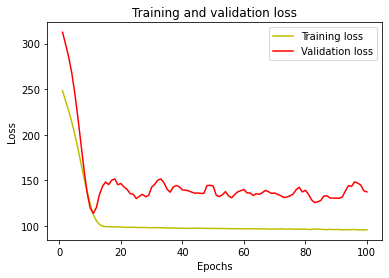


Predicted values are: 
 [[16.166945 ]
 [16.098951 ]
 [ 5.2969985]
 [ 6.4750376]
 [16.306065 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 167.1246 - mean_absolute_error: 7.5132

Mean squared error from neural net: 
 167.12460327148438

Mean absolute error from neural net: 
 7.513205051422119

Predicted values are:
  [[0.00376107 0.00407256 0.00420221 ... 0.00373825 0.00411627 0.00413519]
 [0.00376779 0.00407048 0.00419347 ... 0.0037538  0.00411548 0.00412763]
 [0.00377253 0.00393813 0.0042589  ... 0.0037036  0.0039744  0.00419612]
 [0.00378491 0.00399056 0.00404422 ... 0.00369384 0.00412961 0.00393554]
 [0.00382375 0.00391958 0.00412075 ... 0.00381954 0.00419331 0.00398619]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=======================

In [40]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 160.7447967529297

Mean absolute error from neural net: 
 7.436678886413574

 Mean squared error from Convolutional neural net:  375.9288024902344

Mean absolute error from Convolutional neural net:  12.156847953796387

# Predict 3 Days with 1 month of Data

In [41]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [42]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [43]:
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [44]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [45]:
x_trainScaled.shape

(253, 11)

In [46]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 17ms/step - loss: 241.4637 - mean_absolute_error: 10.5784 - val_loss: 295.0116 - val_mean_absolute_error: 12.2471
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 227.9052 - mean_absolute_error: 10.0054 - val_loss: 273.2042 - val_mean_absolute_error: 11.5922
Epoch 3/100
7/7 [=============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 97.2640 - mean_absolute_error: 6.9785 - val_loss: 135.9350 - val_mean_absolute_error: 10.3736
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9017 - mean_absolute_error: 6.9918 - val_loss: 136.1597 - val_mean_absolute_error: 10.3824
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 97.0820 - mean_absolute_error: 7.1075 - val_loss: 138.6873 - val_mean_absolute_error: 10.4725
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8879 - mean_absolute_error: 7.1373 - val_loss: 137.1088 - val_mean_absolute_error: 10.4076
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9288 - mean_absolute_error: 7.1242 - val_loss: 142.1379 - val_mean_absolute_error: 10.6133
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9218 - mean_absolute_error: 7.1173 - val_loss: 147.0440 - val_mean_absolute_error: 10.8057
Epoc

7/7 [==============================] - 0s 4ms/step - loss: 95.5722 - mean_absolute_error: 7.1105 - val_loss: 138.6203 - val_mean_absolute_error: 10.4252
Epoch 96/100
7/7 [==============================] - 0s 4ms/step - loss: 95.5089 - mean_absolute_error: 7.0858 - val_loss: 136.2920 - val_mean_absolute_error: 10.3195
Epoch 97/100
7/7 [==============================] - 0s 4ms/step - loss: 95.4983 - mean_absolute_error: 7.0685 - val_loss: 140.7688 - val_mean_absolute_error: 10.5316
Epoch 98/100
7/7 [==============================] - 0s 4ms/step - loss: 95.3267 - mean_absolute_error: 7.0319 - val_loss: 134.9516 - val_mean_absolute_error: 10.3009
Epoch 99/100
7/7 [==============================] - 0s 4ms/step - loss: 95.2795 - mean_absolute_error: 6.9581 - val_loss: 133.4830 - val_mean_absolute_error: 10.2396
Epoch 100/100
7/7 [==============================] - 0s 4ms/step - loss: 95.3983 - mean_absolute_error: 6.9303 - val_loss: 135.0194 - val_mean_absolute_error: 10.2919


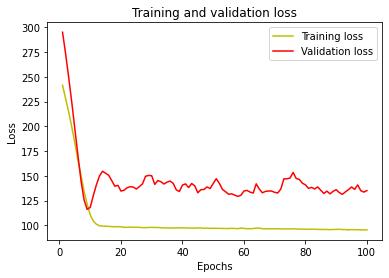


Predicted values are: 
 [[12.046802 ]
 [12.008611 ]
 [ 4.7491016]
 [ 4.633526 ]
 [11.368663 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 208.4160 - mean_absolute_error: 9.3346

Mean squared error from neural net: 
 208.4159698486328

Mean absolute error from neural net: 
 9.334609031677246

Predicted values are:
  [[0.00387682 0.00411606 0.0039494  ... 0.00381556 0.00446585 0.00407703]
 [0.00387926 0.00411635 0.00395073 ... 0.00381717 0.00446474 0.00407706]
 [0.00416386 0.00396346 0.00365057 ... 0.00373268 0.0042252  0.00434621]
 [0.00421692 0.00407007 0.00363425 ... 0.00386153 0.00410868 0.00434274]
 [0.003948   0.00412624 0.00396602 ... 0.00383407 0.00440929 0.0041156 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [========================

In [47]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 213.64584350585938

Mean absolute error from neural net: 
 9.39246940612793

 Mean squared error using decision tree:  186.34709148387097

Mean absolute error using decision tree:  8.564


# Predict 5 Days with 1 Month of Data

In [48]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [49]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [50]:
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [51]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [52]:
x_trainScaled.shape

(253, 11)

In [53]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 22ms/step - loss: 248.3413 - mean_absolute_error: 10.8610 - val_loss: 306.3726 - val_mean_absolute_error: 12.5923
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 234.3531 - mean_absolute_error: 10.2826 - val_loss: 285.6089 - val_mean_absolute_error: 11.9112
Epoch 3/100
7/7 [=============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9716 - mean_absolute_error: 7.0257 - val_loss: 137.8975 - val_mean_absolute_error: 10.4568
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9455 - mean_absolute_error: 7.0701 - val_loss: 138.0317 - val_mean_absolute_error: 10.4678
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 97.0939 - mean_absolute_error: 7.0976 - val_loss: 141.8444 - val_mean_absolute_error: 10.5972
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 97.0113 - mean_absolute_error: 7.1118 - val_loss: 140.0589 - val_mean_absolute_error: 10.5208
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9802 - mean_absolute_error: 7.1209 - val_loss: 137.8029 - val_mean_absolute_error: 10.4191
Epoch 51/100
7/7 [==============================] - 0s 3ms/step - loss: 97.0070 - mean_absolute_error: 7.1098 - val_loss: 130.3654 - val_mean_absolute_error: 10.1280
Epoc

7/7 [==============================] - 0s 7ms/step - loss: 96.0718 - mean_absolute_error: 7.0345 - val_loss: 132.8854 - val_mean_absolute_error: 10.2382
Epoch 96/100
7/7 [==============================] - 0s 8ms/step - loss: 96.0715 - mean_absolute_error: 7.0434 - val_loss: 132.4993 - val_mean_absolute_error: 10.2173
Epoch 97/100
7/7 [==============================] - 0s 8ms/step - loss: 96.0333 - mean_absolute_error: 7.0617 - val_loss: 133.7219 - val_mean_absolute_error: 10.2577
Epoch 98/100
7/7 [==============================] - 0s 4ms/step - loss: 96.4651 - mean_absolute_error: 7.1070 - val_loss: 133.4286 - val_mean_absolute_error: 10.2518
Epoch 99/100
7/7 [==============================] - 0s 4ms/step - loss: 96.0921 - mean_absolute_error: 7.0911 - val_loss: 132.6768 - val_mean_absolute_error: 10.2045
Epoch 100/100
7/7 [==============================] - 0s 3ms/step - loss: 96.4125 - mean_absolute_error: 7.1313 - val_loss: 138.2946 - val_mean_absolute_error: 10.4569


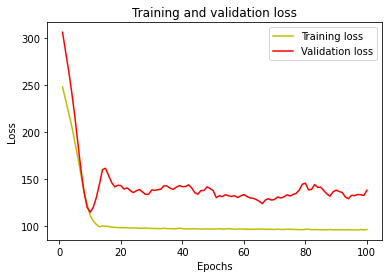


Predicted values are: 
 [[14.024772 ]
 [14.001039 ]
 [ 6.935012 ]
 [ 6.3478723]
 [13.623067 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 1ms/step - loss: 191.5352 - mean_absolute_error: 9.6091

Mean squared error from neural net: 
 191.53517150878906

Mean absolute error from neural net: 
 9.609089851379395

Predicted values are:
  [[0.00403605 0.0039432  0.00400234 ... 0.00382086 0.00380565 0.00362861]
 [0.00403803 0.00394013 0.00400409 ... 0.00382217 0.00380502 0.00363143]
 [0.00409855 0.00386212 0.00389168 ... 0.00368505 0.00386329 0.00368973]
 [0.00411767 0.00380418 0.00390705 ... 0.00373609 0.00381227 0.00375141]
 [0.00407261 0.00389106 0.00404976 ... 0.00385953 0.00377278 0.00370196]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [========================

In [54]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 198.32432556152344

Mean absolute error from neural net: 
 9.677536964416504


Mean squared error using Random Forest:  220.6186052555203

Mean absolute error Using Random Forest:  11.660016579549948

# Predict 1 Week with 1 Month of Data

In [55]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [56]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [57]:
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [58]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [59]:
x_trainScaled.shape

(253, 11)

In [60]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 17ms/step - loss: 244.3491 - mean_absolute_error: 10.6815 - val_loss: 283.5312 - val_mean_absolute_error: 11.8071
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 227.0793 - mean_absolute_error: 9.9363 - val_loss: 258.1919 - val_mean_absolute_error: 11.0351
Epoch 3/100
7/7 [==============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9988 - mean_absolute_error: 7.1144 - val_loss: 131.6552 - val_mean_absolute_error: 10.2131
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 96.7701 - mean_absolute_error: 7.1049 - val_loss: 130.9959 - val_mean_absolute_error: 10.1890
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 96.4947 - mean_absolute_error: 7.0413 - val_loss: 128.6689 - val_mean_absolute_error: 10.0978
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 96.7438 - mean_absolute_error: 7.0440 - val_loss: 129.7577 - val_mean_absolute_error: 10.1562
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9001 - mean_absolute_error: 7.0689 - val_loss: 131.7020 - val_mean_absolute_error: 10.2401
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 96.6115 - mean_absolute_error: 7.0683 - val_loss: 133.4233 - val_mean_absolute_error: 10.3011
Epoc

7/7 [==============================] - 0s 4ms/step - loss: 95.6351 - mean_absolute_error: 6.9290 - val_loss: 129.5914 - val_mean_absolute_error: 10.1210
Epoch 96/100
7/7 [==============================] - 0s 4ms/step - loss: 95.3507 - mean_absolute_error: 6.9317 - val_loss: 131.8359 - val_mean_absolute_error: 10.2034
Epoch 97/100
7/7 [==============================] - 0s 4ms/step - loss: 95.5434 - mean_absolute_error: 7.0040 - val_loss: 138.6624 - val_mean_absolute_error: 10.4601
Epoch 98/100
7/7 [==============================] - 0s 4ms/step - loss: 95.2599 - mean_absolute_error: 7.0626 - val_loss: 144.3918 - val_mean_absolute_error: 10.7027
Epoch 99/100
7/7 [==============================] - 0s 3ms/step - loss: 95.3681 - mean_absolute_error: 7.0847 - val_loss: 139.2887 - val_mean_absolute_error: 10.5159
Epoch 100/100
7/7 [==============================] - 0s 4ms/step - loss: 95.2944 - mean_absolute_error: 7.0110 - val_loss: 133.8317 - val_mean_absolute_error: 10.3035


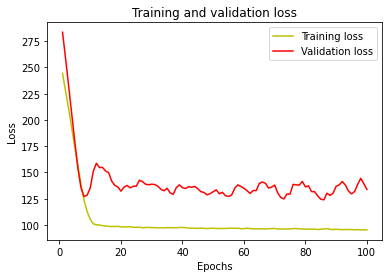


Predicted values are: 
 [[15.873577 ]
 [15.860685 ]
 [ 6.7510915]
 [ 6.7591825]
 [15.606547 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 167.2360 - mean_absolute_error: 8.9157

Mean squared error from neural net: 
 167.2360382080078

Mean absolute error from neural net: 
 8.915735244750977

Predicted values are:
  [[0.00406484 0.00372482 0.00387862 ... 0.00396761 0.00401496 0.00383238]
 [0.00406468 0.00372747 0.00388055 ... 0.00396909 0.00401467 0.00383161]
 [0.00409389 0.00365763 0.00384352 ... 0.00388714 0.00397749 0.00382929]
 [0.0040782  0.00373348 0.00387825 ... 0.00387487 0.00397186 0.0038247 ]
 [0.00407651 0.00378319 0.00391679 ... 0.00399708 0.00401145 0.00381993]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [=========================

In [61]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 166.5867919921875

Mean absolute error from neural net: 
 9.034040451049805

 Mean squared error from linear regression:  218.3835207200644

Mean absolute error from linear regression:  10.310513898451116

# Predict 1 Day with 2 Months of Data

In [62]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1])]

In [63]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [64]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 269.2792 - mean_absolute_error: 10.6059 - val_loss: 319.8747 - val_mean_absolute_error: 11.5594
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 209.6742 - mean_absolute_error: 8.8342 - val_loss: 229.1537 - val_mean_absolute_error: 9.4647
Epoch 3/100
27/27 [==========================

27/27 [==============================] - 0s 2ms/step - loss: 105.0445 - mean_absolute_error: 7.0612 - val_loss: 138.6477 - val_mean_absolute_error: 8.6994
Epoch 46/100
27/27 [==============================] - 0s 2ms/step - loss: 105.0598 - mean_absolute_error: 7.1324 - val_loss: 139.2086 - val_mean_absolute_error: 8.5827
Epoch 47/100
27/27 [==============================] - 0s 2ms/step - loss: 104.8252 - mean_absolute_error: 7.0404 - val_loss: 140.8984 - val_mean_absolute_error: 8.7339
Epoch 48/100
27/27 [==============================] - 0s 2ms/step - loss: 104.8419 - mean_absolute_error: 7.0455 - val_loss: 140.9212 - val_mean_absolute_error: 8.7064
Epoch 49/100
27/27 [==============================] - 0s 2ms/step - loss: 106.6004 - mean_absolute_error: 7.2960 - val_loss: 145.0408 - val_mean_absolute_error: 9.0843
Epoch 50/100
27/27 [==============================] - 0s 2ms/step - loss: 104.6107 - mean_absolute_error: 7.1022 - val_loss: 139.7532 - val_mean_absolute_error: 8.7138
Epoch

27/27 [==============================] - 0s 2ms/step - loss: 103.6684 - mean_absolute_error: 6.9935 - val_loss: 141.6730 - val_mean_absolute_error: 8.8563
Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 103.7648 - mean_absolute_error: 6.9721 - val_loss: 143.8833 - val_mean_absolute_error: 8.9371
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 103.9003 - mean_absolute_error: 7.2086 - val_loss: 142.3848 - val_mean_absolute_error: 8.9022
Epoch 96/100
27/27 [==============================] - 0s 2ms/step - loss: 103.7700 - mean_absolute_error: 6.9915 - val_loss: 143.8645 - val_mean_absolute_error: 8.9802
Epoch 97/100
27/27 [==============================] - 0s 2ms/step - loss: 104.5606 - mean_absolute_error: 7.0625 - val_loss: 145.8569 - val_mean_absolute_error: 9.1060
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.0758 - mean_absolute_error: 7.0459 - val_loss: 142.4798 - val_mean_absolute_error: 8.8211
Epoch

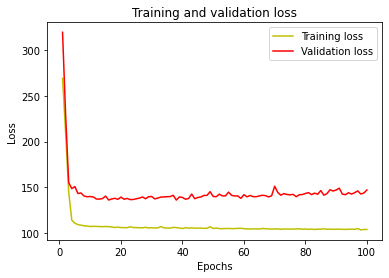


Predicted values are: 
 [[11.444077 ]
 [11.202383 ]
 [ 9.91379  ]
 [ 3.0158055]
 [ 3.0107234]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 88.6039 - mean_absolute_error: 6.9095

Mean squared error from neural net: 
 88.60385131835938

Mean absolute error from neural net: 
 6.909512519836426

Predicted values are:
  [[0.00094669 0.00101768 0.00093144 ... 0.0010074  0.00095737 0.00093048]
 [0.00094804 0.00101746 0.00093165 ... 0.00100865 0.00095763 0.00092997]
 [0.0009491  0.00100968 0.00093363 ... 0.00100316 0.00095898 0.00093297]
 [0.0009527  0.00096728 0.00094869 ... 0.00097372 0.0009673  0.00094564]
 [0.0009566  0.00096121 0.00094883 ... 0.00097346 0.00095767 0.00093727]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
1/1 [=========================

In [65]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Mean squared error using Random Forest:  87.59891941785604

Mean absolute error Using Random Forest:  7.123862400000002

# Predict 3 Days with 2 Months of Data

In [66]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [67]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [68]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 256.1456 - mean_absolute_error: 10.0983 - val_loss: 304.0958 - val_mean_absolute_error: 11.1028
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 182.2579 - mean_absolute_error: 8.3561 - val_loss: 196.1544 - val_mean_absolute_error: 9.2624
Epoch 3/100
27/27 [==========================

27/27 [==============================] - 0s 2ms/step - loss: 104.7681 - mean_absolute_error: 7.0653 - val_loss: 138.3820 - val_mean_absolute_error: 8.3388
Epoch 46/100
27/27 [==============================] - 0s 2ms/step - loss: 104.7646 - mean_absolute_error: 7.0245 - val_loss: 139.4934 - val_mean_absolute_error: 8.2749
Epoch 47/100
27/27 [==============================] - 0s 2ms/step - loss: 104.7923 - mean_absolute_error: 7.1545 - val_loss: 139.6372 - val_mean_absolute_error: 8.4452
Epoch 48/100
27/27 [==============================] - 0s 2ms/step - loss: 104.7410 - mean_absolute_error: 7.0074 - val_loss: 137.8434 - val_mean_absolute_error: 8.2335
Epoch 49/100
27/27 [==============================] - 0s 2ms/step - loss: 104.5303 - mean_absolute_error: 7.0471 - val_loss: 140.1633 - val_mean_absolute_error: 8.5069
Epoch 50/100
27/27 [==============================] - 0s 2ms/step - loss: 105.0535 - mean_absolute_error: 7.2554 - val_loss: 142.6397 - val_mean_absolute_error: 8.6748
Epoch

Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 103.4593 - mean_absolute_error: 7.1504 - val_loss: 146.6589 - val_mean_absolute_error: 8.8978
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 103.7305 - mean_absolute_error: 7.0789 - val_loss: 144.4239 - val_mean_absolute_error: 8.7758
Epoch 96/100
27/27 [==============================] - 0s 2ms/step - loss: 103.3802 - mean_absolute_error: 7.1545 - val_loss: 144.8118 - val_mean_absolute_error: 8.8672
Epoch 97/100
27/27 [==============================] - 0s 2ms/step - loss: 103.8671 - mean_absolute_error: 6.8969 - val_loss: 147.0031 - val_mean_absolute_error: 8.8638
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.2611 - mean_absolute_error: 7.1474 - val_loss: 141.8728 - val_mean_absolute_error: 8.4978
Epoch 99/100
27/27 [==============================] - 0s 2ms/step - loss: 104.0899 - mean_absolute_error: 6.9299 - val_loss: 145.0112 - val_mean_absolute_error:

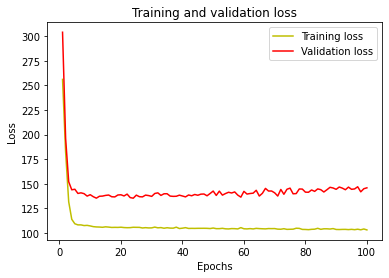


Predicted values are: 
 [[11.335541]
 [11.241116]
 [11.00206 ]
 [ 9.674664]
 [ 9.689882]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 104.3815 - mean_absolute_error: 7.6241

Mean squared error from neural net: 
 104.38146209716797

Mean absolute error from neural net: 
 7.624105930328369

Predicted values are:
  [[0.00091649 0.00095657 0.00091499 ... 0.00093681 0.00090335 0.00094983]
 [0.0009158  0.00095679 0.00091485 ... 0.00093678 0.00090372 0.00094931]
 [0.00091671 0.00095618 0.00091631 ... 0.00093775 0.00090637 0.00094975]
 [0.00092113 0.00095337 0.00092557 ... 0.00094423 0.00092188 0.00095171]
 [0.00092765 0.00095224 0.00092903 ... 0.00094638 0.00092543 0.00095571]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [=============================

In [69]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Mean squared error using Random Forest:  113.78877579587008

Mean absolute error Using Random Forest:  7.631643458292483


# Predict 5 Days with 2 Months of Data

In [70]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [71]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [72]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 254.2374 - mean_absolute_error: 10.1120 - val_loss: 287.2389 - val_mean_absolute_error: 10.6672
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 177.3271 - mean_absolute_error: 8.2326 - val_loss: 183.7796 - val_mean_absolute_error: 9.3000
Epoch 3/100
27/27 [==========================

27/27 [==============================] - 0s 2ms/step - loss: 104.8646 - mean_absolute_error: 7.0138 - val_loss: 137.4373 - val_mean_absolute_error: 8.2392
Epoch 46/100
27/27 [==============================] - 0s 2ms/step - loss: 104.8991 - mean_absolute_error: 7.1157 - val_loss: 139.8893 - val_mean_absolute_error: 8.5351
Epoch 47/100
27/27 [==============================] - 0s 2ms/step - loss: 106.2075 - mean_absolute_error: 7.1953 - val_loss: 140.7791 - val_mean_absolute_error: 8.3011
Epoch 48/100
27/27 [==============================] - 0s 2ms/step - loss: 104.9837 - mean_absolute_error: 7.0366 - val_loss: 136.3961 - val_mean_absolute_error: 8.1985
Epoch 49/100
27/27 [==============================] - 0s 2ms/step - loss: 104.7974 - mean_absolute_error: 7.1351 - val_loss: 138.6225 - val_mean_absolute_error: 8.3798
Epoch 50/100
27/27 [==============================] - 0s 2ms/step - loss: 104.4235 - mean_absolute_error: 6.9951 - val_loss: 138.0247 - val_mean_absolute_error: 8.4191
Epoch

Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 103.8987 - mean_absolute_error: 6.9780 - val_loss: 141.7749 - val_mean_absolute_error: 8.6818
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 103.3608 - mean_absolute_error: 7.0354 - val_loss: 142.7317 - val_mean_absolute_error: 8.5907
Epoch 96/100
27/27 [==============================] - 0s 2ms/step - loss: 103.3079 - mean_absolute_error: 7.0565 - val_loss: 140.8107 - val_mean_absolute_error: 8.3248
Epoch 97/100
27/27 [==============================] - 0s 2ms/step - loss: 103.3133 - mean_absolute_error: 7.0571 - val_loss: 140.7834 - val_mean_absolute_error: 8.4285
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.0450 - mean_absolute_error: 7.0823 - val_loss: 141.4991 - val_mean_absolute_error: 8.4150
Epoch 99/100
27/27 [==============================] - 0s 2ms/step - loss: 103.8189 - mean_absolute_error: 7.0630 - val_loss: 140.3387 - val_mean_absolute_error:

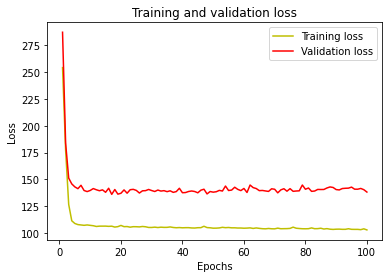


Predicted values are: 
 [[10.122668]
 [10.121135]
 [ 9.971095]
 [ 9.234637]
 [ 8.997678]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 122.5840 - mean_absolute_error: 7.5022

Mean squared error from neural net: 
 122.5840072631836

Mean absolute error from neural net: 
 7.502213954925537

Predicted values are:
  [[0.0010007  0.0009559  0.00095241 ... 0.00094082 0.00096127 0.00095585]
 [0.00100105 0.00095611 0.00095203 ... 0.00094064 0.00096115 0.00095594]
 [0.00099924 0.00095619 0.00095219 ... 0.00094112 0.00096119 0.00095612]
 [0.00098946 0.00095724 0.00095294 ... 0.00094326 0.00096113 0.00095653]
 [0.00098483 0.00095639 0.00095577 ... 0.00094445 0.00096156 0.00095489]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================

In [73]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945


Mean squared error using Random Forest:  100.1006992130904

Mean absolute error Using Random Forest:  7.348763723404256

# Predict 1 Week with 2 Months of Data

In [74]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [75]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [76]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 258.3033 - mean_absolute_error: 10.2476 - val_loss: 293.8721 - val_mean_absolute_error: 10.8497
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 181.1109 - mean_absolute_error: 8.2278 - val_loss: 186.0211 - val_mean_absolute_error: 9.1631
Epoch 3/100
27/27 [==========================

27/27 [==============================] - 0s 2ms/step - loss: 104.8313 - mean_absolute_error: 7.1072 - val_loss: 139.6109 - val_mean_absolute_error: 8.4693
Epoch 46/100
27/27 [==============================] - 0s 2ms/step - loss: 104.5302 - mean_absolute_error: 7.0652 - val_loss: 141.0211 - val_mean_absolute_error: 8.5932
Epoch 47/100
27/27 [==============================] - 0s 3ms/step - loss: 104.7104 - mean_absolute_error: 7.1089 - val_loss: 136.9906 - val_mean_absolute_error: 8.3446
Epoch 48/100
27/27 [==============================] - 0s 2ms/step - loss: 105.2466 - mean_absolute_error: 7.0027 - val_loss: 141.6068 - val_mean_absolute_error: 8.8336
Epoch 49/100
27/27 [==============================] - 0s 2ms/step - loss: 104.5343 - mean_absolute_error: 7.0877 - val_loss: 139.3756 - val_mean_absolute_error: 8.6159
Epoch 50/100
27/27 [==============================] - 0s 2ms/step - loss: 104.1865 - mean_absolute_error: 7.0485 - val_loss: 138.8720 - val_mean_absolute_error: 8.5142
Epoch

Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 103.3853 - mean_absolute_error: 7.0670 - val_loss: 144.9932 - val_mean_absolute_error: 9.2355
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 102.8994 - mean_absolute_error: 7.0578 - val_loss: 145.8985 - val_mean_absolute_error: 9.1870
Epoch 96/100
27/27 [==============================] - 0s 2ms/step - loss: 102.9415 - mean_absolute_error: 6.9630 - val_loss: 145.2805 - val_mean_absolute_error: 9.0394
Epoch 97/100
27/27 [==============================] - 0s 2ms/step - loss: 102.9533 - mean_absolute_error: 7.0447 - val_loss: 151.6557 - val_mean_absolute_error: 9.5318
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.0364 - mean_absolute_error: 7.0094 - val_loss: 144.2122 - val_mean_absolute_error: 9.0445
Epoch 99/100
27/27 [==============================] - 0s 2ms/step - loss: 103.4435 - mean_absolute_error: 7.0286 - val_loss: 149.0565 - val_mean_absolute_error:

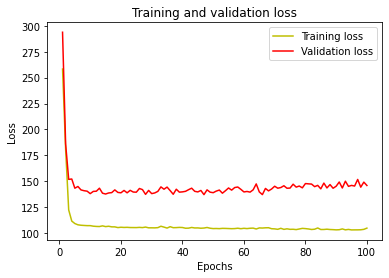


Predicted values are: 
 [[6.1545563]
 [6.1339912]
 [6.065162 ]
 [5.6284475]
 [5.5804677]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
5/5 [==============================] - 0s 1ms/step - loss: 104.7575 - mean_absolute_error: 6.9186

Mean squared error from neural net: 
 104.75753021240234

Mean absolute error from neural net: 
 6.918617248535156

Predicted values are:
  [[0.00097186 0.00094539 0.0009711  ... 0.00090026 0.00097578 0.00094485]
 [0.00097173 0.00094534 0.00097122 ... 0.00090023 0.00097565 0.00094475]
 [0.00097118 0.00094528 0.00097105 ... 0.00090146 0.00097514 0.00094483]
 [0.00096767 0.00094474 0.00097036 ... 0.00090862 0.00097197 0.0009453 ]
 [0.00096658 0.00094445 0.00096976 ... 0.00091178 0.00097176 0.00094655]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
5/5 [=============================

In [77]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

 Mean squared error using Random Forest:  106.3441792968664

Mean absolute error Using Random Forest:  6.811379829758829



# Predict 1 Day with 3 months

In [78]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'] == 1]

In [79]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [80]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 245.7197 - mean_absolute_error: 11.0143 - val_loss: 261.6483 - val_mean_absolute_error: 11.0689
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 212.1236 - mean_absolute_error: 9.7433 - val_loss: 221.7680 - val_mean_absolute_error: 9.8685
Epoch 3/100
16/16 [==========================

16/16 [==============================] - 0s 2ms/step - loss: 72.3679 - mean_absolute_error: 6.1546 - val_loss: 103.8834 - val_mean_absolute_error: 7.5116
Epoch 46/100
16/16 [==============================] - 0s 2ms/step - loss: 72.7617 - mean_absolute_error: 6.2025 - val_loss: 104.0552 - val_mean_absolute_error: 7.6622
Epoch 47/100
16/16 [==============================] - 0s 2ms/step - loss: 72.4029 - mean_absolute_error: 6.2730 - val_loss: 104.3180 - val_mean_absolute_error: 7.6389
Epoch 48/100
16/16 [==============================] - 0s 2ms/step - loss: 72.2342 - mean_absolute_error: 6.2346 - val_loss: 104.3561 - val_mean_absolute_error: 7.4833
Epoch 49/100
16/16 [==============================] - 0s 2ms/step - loss: 72.3503 - mean_absolute_error: 6.2226 - val_loss: 103.8165 - val_mean_absolute_error: 7.4626
Epoch 50/100
16/16 [==============================] - 0s 2ms/step - loss: 72.2453 - mean_absolute_error: 6.1745 - val_loss: 104.1067 - val_mean_absolute_error: 7.4421
Epoch 51/10

16/16 [==============================] - 0s 2ms/step - loss: 69.8815 - mean_absolute_error: 6.0624 - val_loss: 105.8616 - val_mean_absolute_error: 7.3879
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 70.1269 - mean_absolute_error: 6.1091 - val_loss: 105.6451 - val_mean_absolute_error: 7.3568
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 69.8507 - mean_absolute_error: 6.0323 - val_loss: 106.6639 - val_mean_absolute_error: 7.3224
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 69.5951 - mean_absolute_error: 6.0868 - val_loss: 105.6402 - val_mean_absolute_error: 7.4583
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 69.6611 - mean_absolute_error: 6.0798 - val_loss: 106.2143 - val_mean_absolute_error: 7.4362
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 69.6573 - mean_absolute_error: 6.0060 - val_loss: 106.8646 - val_mean_absolute_error: 7.3105
Epoch 100/1

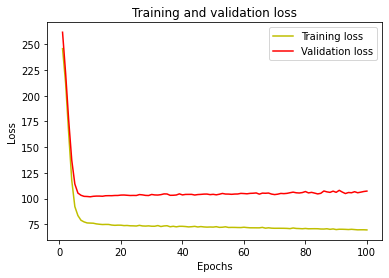


Predicted values are: 
 [[20.11188  ]
 [20.09638  ]
 [ 2.3542912]
 [ 4.73698  ]
 [21.114836 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 141.7198 - mean_absolute_error: 7.6769

Mean squared error from neural net: 
 141.7198028564453

Mean absolute error from neural net: 
 7.6768798828125

Predicted values are:
  [[0.0016822  0.00170592 0.00155771 ... 0.00171376 0.00153904 0.00156551]
 [0.00168034 0.00170365 0.00155884 ... 0.00170917 0.00154155 0.00156867]
 [0.00170049 0.00166689 0.00160442 ... 0.0016362  0.00152188 0.00154997]
 [0.00166779 0.00163761 0.00160292 ... 0.00162955 0.00163059 0.00164363]
 [0.00164047 0.0016708  0.00159664 ... 0.00164727 0.00155732 0.00161685]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==========================

In [81]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 140.70570373535156

Mean absolute error from neural net: 
 7.819906711578369

Mean squared error using decision tree:  130.75000129999998

Mean absolute error using decision tree:  6.7923

# Predict 3 Days with 3 months

In [82]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [83]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [84]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 240.3265 - mean_absolute_error: 10.8233 - val_loss: 267.3058 - val_mean_absolute_error: 11.1997
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 195.6733 - mean_absolute_error: 9.2941 - val_loss: 225.9058 - val_mean_absolute_error: 9.9704
Epoch 3/100
16/16 [==========================

16/16 [==============================] - 0s 2ms/step - loss: 72.3994 - mean_absolute_error: 6.1951 - val_loss: 104.6596 - val_mean_absolute_error: 7.6808
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 72.3849 - mean_absolute_error: 6.2078 - val_loss: 104.4981 - val_mean_absolute_error: 7.6862
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 72.7712 - mean_absolute_error: 6.1720 - val_loss: 104.6669 - val_mean_absolute_error: 7.5650
Epoch 48/100
16/16 [==============================] - 0s 2ms/step - loss: 72.3275 - mean_absolute_error: 6.2398 - val_loss: 104.2056 - val_mean_absolute_error: 7.7534
Epoch 49/100
16/16 [==============================] - 0s 2ms/step - loss: 72.5958 - mean_absolute_error: 6.2142 - val_loss: 104.9878 - val_mean_absolute_error: 7.7846
Epoch 50/100
16/16 [==============================] - 0s 2ms/step - loss: 72.3883 - mean_absolute_error: 6.2606 - val_loss: 104.2474 - val_mean_absolute_error: 7.7024
Epoch 51/10

16/16 [==============================] - 0s 4ms/step - loss: 69.4065 - mean_absolute_error: 6.0457 - val_loss: 107.7237 - val_mean_absolute_error: 7.6819
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 69.4844 - mean_absolute_error: 6.0235 - val_loss: 111.7633 - val_mean_absolute_error: 7.5810
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 69.1696 - mean_absolute_error: 6.0866 - val_loss: 110.5811 - val_mean_absolute_error: 7.8352
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 69.3250 - mean_absolute_error: 6.0817 - val_loss: 109.0916 - val_mean_absolute_error: 7.7634
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 69.9745 - mean_absolute_error: 5.9817 - val_loss: 109.1388 - val_mean_absolute_error: 7.7829
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 69.7019 - mean_absolute_error: 6.1027 - val_loss: 109.0876 - val_mean_absolute_error: 7.7481
Epoch 100/1

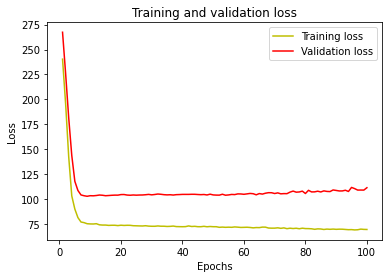


Predicted values are: 
 [[18.097403 ]
 [18.069342 ]
 [ 3.6801198]
 [ 3.9775152]
 [17.158354 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 194.0070 - mean_absolute_error: 8.8577

Mean squared error from neural net: 
 194.0070343017578

Mean absolute error from neural net: 
 8.857667922973633

Predicted values are:
  [[0.00177708 0.00173028 0.00152913 ... 0.00163215 0.00160124 0.00155812]
 [0.00177471 0.00172888 0.00153037 ... 0.00163188 0.00160139 0.00155855]
 [0.00175347 0.00167291 0.00154283 ... 0.00166976 0.00162941 0.00163051]
 [0.00172848 0.00165586 0.00158707 ... 0.0016583  0.00163464 0.00163666]
 [0.0017202  0.00169589 0.00156398 ... 0.00162052 0.00161085 0.00157202]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [========================

In [85]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 187.8616943359375

Mean absolute error from neural net: 
 8.869044303894043

 Mean squared error using Random Forest:  183.2863459959755

Mean absolute error Using Random Forest:  10.364935468369174

# Predict 5 Days with 3 months

In [86]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [87]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [88]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 247.9020 - mean_absolute_error: 11.0836 - val_loss: 263.7096 - val_mean_absolute_error: 11.1847
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 205.3263 - mean_absolute_error: 9.5813 - val_loss: 221.6226 - val_mean_absolute_error: 9.8475
Epoch 3/100
16/16 [==========================

16/16 [==============================] - 0s 2ms/step - loss: 72.6309 - mean_absolute_error: 6.2332 - val_loss: 103.9222 - val_mean_absolute_error: 7.6271
Epoch 46/100
16/16 [==============================] - 0s 2ms/step - loss: 72.3215 - mean_absolute_error: 6.1799 - val_loss: 104.6177 - val_mean_absolute_error: 7.5648
Epoch 47/100
16/16 [==============================] - 0s 2ms/step - loss: 72.8842 - mean_absolute_error: 6.1028 - val_loss: 103.9416 - val_mean_absolute_error: 7.6273
Epoch 48/100
16/16 [==============================] - 0s 2ms/step - loss: 72.4338 - mean_absolute_error: 6.2346 - val_loss: 103.2018 - val_mean_absolute_error: 7.6476
Epoch 49/100
16/16 [==============================] - 0s 2ms/step - loss: 72.6074 - mean_absolute_error: 6.2142 - val_loss: 104.1796 - val_mean_absolute_error: 7.5360
Epoch 50/100
16/16 [==============================] - 0s 2ms/step - loss: 72.5455 - mean_absolute_error: 6.1788 - val_loss: 103.5039 - val_mean_absolute_error: 7.5892
Epoch 51/10

16/16 [==============================] - 0s 2ms/step - loss: 70.5921 - mean_absolute_error: 6.0920 - val_loss: 103.9234 - val_mean_absolute_error: 7.3394
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5499 - mean_absolute_error: 6.0599 - val_loss: 104.4561 - val_mean_absolute_error: 7.3458
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 70.2088 - mean_absolute_error: 6.0723 - val_loss: 104.5839 - val_mean_absolute_error: 7.4423
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5727 - mean_absolute_error: 6.0928 - val_loss: 105.2845 - val_mean_absolute_error: 7.4597
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5509 - mean_absolute_error: 6.0579 - val_loss: 106.2366 - val_mean_absolute_error: 7.4034
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 70.4385 - mean_absolute_error: 6.0796 - val_loss: 104.2074 - val_mean_absolute_error: 7.3560
Epoch 100/1

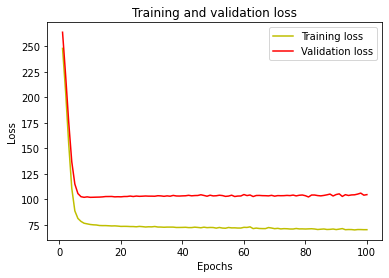


Predicted values are: 
 [[17.474556 ]
 [17.491194 ]
 [ 4.3126807]
 [ 4.536261 ]
 [18.10014  ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 1ms/step - loss: 157.1705 - mean_absolute_error: 8.1393

Mean squared error from neural net: 
 157.17051696777344

Mean absolute error from neural net: 
 8.1393461227417

Predicted values are:
  [[0.00161434 0.00166916 0.00162884 ... 0.00169845 0.00167575 0.0016106 ]
 [0.00161499 0.00166957 0.00162876 ... 0.00169802 0.00167567 0.00161097]
 [0.00159291 0.00168588 0.00164184 ... 0.00165524 0.00172046 0.00159177]
 [0.00161946 0.00169402 0.00163225 ... 0.00164784 0.00170976 0.00158973]
 [0.00163003 0.00167776 0.00162886 ... 0.00168635 0.00167358 0.00161789]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==========================

In [89]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 160.44891357421875

Mean absolute error from neural net: 
 8.013179779052734

Mean squared error using Random Forest:  163.33505718087187

Mean absolute error Using Random Forest:  10.224571321158745

# Predict 1 Week with 3 months

In [90]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [91]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [92]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_76 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 230.5856 - mean_absolute_error: 10.4057 - val_loss: 251.5889 - val_mean_absolute_error: 10.6531
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 182.4181 - mean_absolute_error: 8.8929 - val_loss: 207.0130 - val_mean_absolute_error: 9.5118
Epoch 3/100
16/16 [==========================

16/16 [==============================] - 0s 2ms/step - loss: 72.3996 - mean_absolute_error: 6.1218 - val_loss: 103.3606 - val_mean_absolute_error: 7.4863
Epoch 46/100
16/16 [==============================] - 0s 2ms/step - loss: 72.2030 - mean_absolute_error: 6.1986 - val_loss: 103.4756 - val_mean_absolute_error: 7.5439
Epoch 47/100
16/16 [==============================] - 0s 2ms/step - loss: 72.1245 - mean_absolute_error: 6.1874 - val_loss: 103.4528 - val_mean_absolute_error: 7.4865
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 72.0571 - mean_absolute_error: 6.1539 - val_loss: 104.0621 - val_mean_absolute_error: 7.4709
Epoch 49/100
16/16 [==============================] - 0s 4ms/step - loss: 72.9077 - mean_absolute_error: 6.2897 - val_loss: 103.3094 - val_mean_absolute_error: 7.5921
Epoch 50/100
16/16 [==============================] - 0s 2ms/step - loss: 71.8448 - mean_absolute_error: 6.1318 - val_loss: 104.5017 - val_mean_absolute_error: 7.5464
Epoch 51/10

16/16 [==============================] - 0s 2ms/step - loss: 68.6972 - mean_absolute_error: 5.9991 - val_loss: 107.0289 - val_mean_absolute_error: 7.5529
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 68.7226 - mean_absolute_error: 6.0203 - val_loss: 108.3644 - val_mean_absolute_error: 7.5379
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 68.6634 - mean_absolute_error: 6.0067 - val_loss: 110.1285 - val_mean_absolute_error: 7.5428
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 68.8732 - mean_absolute_error: 5.9709 - val_loss: 109.0346 - val_mean_absolute_error: 7.5769
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 69.0335 - mean_absolute_error: 5.9925 - val_loss: 107.6128 - val_mean_absolute_error: 7.6021
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 68.8420 - mean_absolute_error: 6.0513 - val_loss: 107.7461 - val_mean_absolute_error: 7.5750
Epoch 100/1

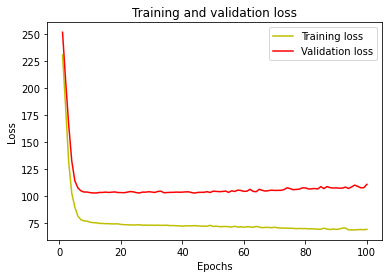


Predicted values are: 
 [[20.00757  ]
 [20.03738  ]
 [ 4.362648 ]
 [ 4.6285295]
 [20.820263 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 139.8024 - mean_absolute_error: 7.7282

Mean squared error from neural net: 
 139.8023681640625

Mean absolute error from neural net: 
 7.728230953216553

Predicted values are:
  [[0.0015745  0.00154524 0.00162125 ... 0.00168416 0.00160623 0.00155056]
 [0.00157441 0.00154555 0.00162102 ... 0.0016842  0.00160644 0.00155078]
 [0.00160421 0.0016163  0.00169882 ... 0.00163862 0.00157914 0.00158719]
 [0.00160768 0.00162338 0.00169044 ... 0.00163132 0.0015848  0.00159501]
 [0.00157087 0.00155135 0.00161588 ... 0.0016853  0.00161178 0.00155623]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [=========================

In [93]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 139.3793182373047

Mean absolute error from neural net: 
 7.571944236755371

 Mean squared error using Random Forest:  159.6135360726889

Mean absolute error Using Random Forest:  8.76255422973079

# Predict 1 Day with 6 months

In [94]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'] == 1]

In [95]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [96]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 4ms/step - loss: 281.9758 - mean_absolute_error: 11.3050 - val_loss: 240.9185 - val_mean_absolute_error: 9.9188
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 161.3673 - mean_absolute_error: 8.4321 - val_loss: 132.3321 - val_mean_absolute_error: 9.1568
Epoch 3/100
43/43 [===========================

43/43 [==============================] - 0s 1ms/step - loss: 106.6547 - mean_absolute_error: 7.2770 - val_loss: 110.4208 - val_mean_absolute_error: 7.8998
Epoch 46/100
43/43 [==============================] - 0s 1ms/step - loss: 106.6562 - mean_absolute_error: 7.2715 - val_loss: 110.8326 - val_mean_absolute_error: 7.9510
Epoch 47/100
43/43 [==============================] - 0s 1ms/step - loss: 106.5870 - mean_absolute_error: 7.2240 - val_loss: 108.5407 - val_mean_absolute_error: 7.6182
Epoch 48/100
43/43 [==============================] - 0s 1ms/step - loss: 106.2849 - mean_absolute_error: 7.1780 - val_loss: 111.5929 - val_mean_absolute_error: 8.0231
Epoch 49/100
43/43 [==============================] - 0s 2ms/step - loss: 106.5975 - mean_absolute_error: 7.2820 - val_loss: 110.5799 - val_mean_absolute_error: 7.9157
Epoch 50/100
43/43 [==============================] - 0s 1ms/step - loss: 106.3067 - mean_absolute_error: 7.2608 - val_loss: 111.1304 - val_mean_absolute_error: 7.9458
Epoch

Epoch 94/100
43/43 [==============================] - 0s 1ms/step - loss: 105.2577 - mean_absolute_error: 7.2290 - val_loss: 108.7570 - val_mean_absolute_error: 7.6062
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.5661 - mean_absolute_error: 7.2203 - val_loss: 109.1850 - val_mean_absolute_error: 7.6601
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 105.3007 - mean_absolute_error: 7.1534 - val_loss: 110.7966 - val_mean_absolute_error: 7.9182
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 105.9859 - mean_absolute_error: 7.2418 - val_loss: 107.4815 - val_mean_absolute_error: 7.3614
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 106.3115 - mean_absolute_error: 7.1882 - val_loss: 110.4089 - val_mean_absolute_error: 7.8487
Epoch 99/100
43/43 [==============================] - 0s 1ms/step - loss: 106.0407 - mean_absolute_error: 7.2270 - val_loss: 108.4131 - val_mean_absolute_error:

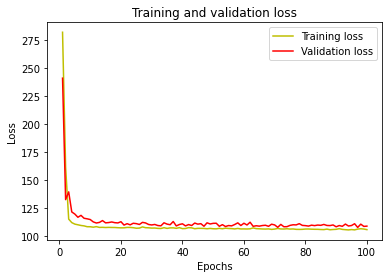


Predicted values are: 
 [[19.658638 ]
 [19.664146 ]
 [ 6.803445 ]
 [ 6.3707933]
 [22.666164 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 139.1574 - mean_absolute_error: 8.2040

Mean squared error from neural net: 
 139.1573944091797

Mean absolute error from neural net: 
 8.203968048095703

Predicted values are:
  [[0.00058443 0.00058192 0.00058649 ... 0.00061584 0.00061652 0.00057288]
 [0.00058443 0.00058198 0.00058621 ... 0.0006155  0.00061641 0.00057253]
 [0.00058938 0.00058663 0.00057843 ... 0.00059905 0.00059569 0.00059043]
 [0.00059088 0.00058966 0.00058092 ... 0.00058893 0.00059904 0.0005874 ]
 [0.00057822 0.00058515 0.00057899 ... 0.00060842 0.00061245 0.00058119]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [========================

In [97]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 137.43057250976562

Mean absolute error from neural net: 
 8.427358627319336


Mean squared error using Random Forest:  139.48872427732

Mean absolute error Using Random Forest:  8.705460000000002

# Predict 3 Days with 6 months

In [98]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [99]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [100]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_86 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 3ms/step - loss: 271.0115 - mean_absolute_error: 10.9214 - val_loss: 207.9765 - val_mean_absolute_error: 9.2244
Epoch 2/100
43/43 [==============================] - 0s 1ms/step - loss: 150.5551 - mean_absolute_error: 8.4520 - val_loss: 156.0650 - val_mean_absolute_error: 10.7928
Epoch 3/100
43/43 [==========================

43/43 [==============================] - 0s 1ms/step - loss: 107.0149 - mean_absolute_error: 7.1676 - val_loss: 110.1103 - val_mean_absolute_error: 7.8391
Epoch 46/100
43/43 [==============================] - 0s 1ms/step - loss: 106.4421 - mean_absolute_error: 7.2427 - val_loss: 111.2310 - val_mean_absolute_error: 7.9792
Epoch 47/100
43/43 [==============================] - 0s 1ms/step - loss: 106.4137 - mean_absolute_error: 7.2220 - val_loss: 108.5074 - val_mean_absolute_error: 7.6432
Epoch 48/100
43/43 [==============================] - 0s 1ms/step - loss: 106.5401 - mean_absolute_error: 7.2815 - val_loss: 108.6054 - val_mean_absolute_error: 7.6584
Epoch 49/100
43/43 [==============================] - 0s 1ms/step - loss: 106.2755 - mean_absolute_error: 7.2536 - val_loss: 110.4824 - val_mean_absolute_error: 7.8799
Epoch 50/100
43/43 [==============================] - 0s 1ms/step - loss: 106.7170 - mean_absolute_error: 7.2728 - val_loss: 108.4462 - val_mean_absolute_error: 7.6611
Epoch

Epoch 94/100
43/43 [==============================] - 0s 1ms/step - loss: 105.3807 - mean_absolute_error: 7.2248 - val_loss: 111.5904 - val_mean_absolute_error: 7.9941
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.4579 - mean_absolute_error: 7.2148 - val_loss: 107.8652 - val_mean_absolute_error: 7.5001
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 105.7029 - mean_absolute_error: 7.2162 - val_loss: 109.0041 - val_mean_absolute_error: 7.6612
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 105.2149 - mean_absolute_error: 7.1341 - val_loss: 110.0054 - val_mean_absolute_error: 7.8258
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 105.7721 - mean_absolute_error: 7.2561 - val_loss: 109.6208 - val_mean_absolute_error: 7.7140
Epoch 99/100
43/43 [==============================] - 0s 1ms/step - loss: 105.5853 - mean_absolute_error: 7.1938 - val_loss: 111.4876 - val_mean_absolute_error:

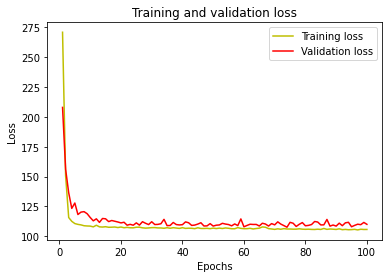


Predicted values are: 
 [[16.771568]
 [16.694645]
 [ 6.043384]
 [ 5.977933]
 [15.453894]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 179.2793 - mean_absolute_error: 9.0049

Mean squared error from neural net: 
 179.279296875

Mean absolute error from neural net: 
 9.004900932312012

Predicted values are:
  [[0.00058454 0.00061477 0.00060276 ... 0.00058892 0.00058518 0.00059389]
 [0.00058459 0.00061435 0.00060233 ... 0.00058862 0.00058515 0.0005937 ]
 [0.00058179 0.00059091 0.00060973 ... 0.00057548 0.00057728 0.00058962]
 [0.00058529 0.00058226 0.00060065 ... 0.00057608 0.00057302 0.00058272]
 [0.00058614 0.00060544 0.000593   ... 0.00058158 0.00058459 0.00059075]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] -

In [101]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 168.54148864746094

Mean absolute error from neural net: 
 8.720255851745605

 Mean squared error using Random Forest:  278.053234980616

Mean absolute error Using Random Forest:  14.620022903225802


# Predict 5 Days with 6 months

In [102]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [103]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [104]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_91 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 3ms/step - loss: 271.4524 - mean_absolute_error: 11.0655 - val_loss: 193.4454 - val_mean_absolute_error: 8.9779
Epoch 2/100
43/43 [==============================] - 0s 1ms/step - loss: 147.7261 - mean_absolute_error: 8.1779 - val_loss: 147.0682 - val_mean_absolute_error: 10.3322
Epoch 3/100
43/43 [==========================

43/43 [==============================] - 0s 1ms/step - loss: 106.4085 - mean_absolute_error: 7.2203 - val_loss: 109.5982 - val_mean_absolute_error: 7.7713
Epoch 46/100
43/43 [==============================] - 0s 1ms/step - loss: 106.5823 - mean_absolute_error: 7.2741 - val_loss: 109.2857 - val_mean_absolute_error: 7.7971
Epoch 47/100
43/43 [==============================] - 0s 2ms/step - loss: 106.5165 - mean_absolute_error: 7.2170 - val_loss: 111.6130 - val_mean_absolute_error: 8.0206
Epoch 48/100
43/43 [==============================] - 0s 2ms/step - loss: 106.5158 - mean_absolute_error: 7.2390 - val_loss: 109.8610 - val_mean_absolute_error: 7.8548
Epoch 49/100
43/43 [==============================] - 0s 1ms/step - loss: 106.3633 - mean_absolute_error: 7.2512 - val_loss: 109.1235 - val_mean_absolute_error: 7.7675
Epoch 50/100
43/43 [==============================] - 0s 1ms/step - loss: 106.1420 - mean_absolute_error: 7.2000 - val_loss: 108.4922 - val_mean_absolute_error: 7.6420
Epoch

Epoch 94/100
43/43 [==============================] - 0s 2ms/step - loss: 105.2912 - mean_absolute_error: 7.1319 - val_loss: 109.7691 - val_mean_absolute_error: 7.8372
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.5852 - mean_absolute_error: 7.2456 - val_loss: 107.5337 - val_mean_absolute_error: 7.5530
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 105.6089 - mean_absolute_error: 7.2383 - val_loss: 106.8257 - val_mean_absolute_error: 7.3838
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 106.0366 - mean_absolute_error: 7.2075 - val_loss: 108.9729 - val_mean_absolute_error: 7.6362
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 106.1996 - mean_absolute_error: 7.2121 - val_loss: 107.8481 - val_mean_absolute_error: 7.5115
Epoch 99/100
43/43 [==============================] - 0s 2ms/step - loss: 105.7500 - mean_absolute_error: 7.1369 - val_loss: 109.5636 - val_mean_absolute_error:

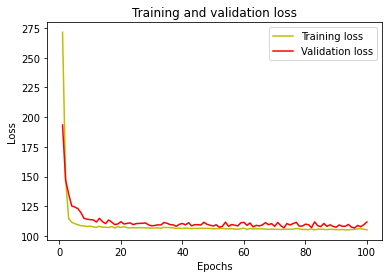


Predicted values are: 
 [[13.920853 ]
 [13.929778 ]
 [ 7.037198 ]
 [ 7.6104937]
 [14.415352 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 174.2370 - mean_absolute_error: 8.9125

Mean squared error from neural net: 
 174.2370147705078

Mean absolute error from neural net: 
 8.912487983703613

Predicted values are:
  [[0.00058351 0.0005839  0.00061227 ... 0.00058078 0.00058518 0.00057041]
 [0.00058346 0.0005839  0.0006121  ... 0.00058076 0.00058505 0.00057065]
 [0.00058954 0.00058874 0.00060136 ... 0.00057423 0.00058222 0.00057029]
 [0.00058824 0.00058633 0.00059933 ... 0.0005723  0.00058371 0.00057583]
 [0.00058243 0.00058453 0.00060888 ... 0.00058146 0.00058195 0.00057615]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [=========================

In [105]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 165.61785888671875

Mean absolute error from neural net: 
 8.66168212890625

 Mean squared error using Random Forest:  272.07574671006506

Mean absolute error Using Random Forest:  14.128006579549945


# Predict 1 Week with 6 months

In [106]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [107]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [108]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 3ms/step - loss: 261.4186 - mean_absolute_error: 10.6648 - val_loss: 207.5485 - val_mean_absolute_error: 9.1739
Epoch 2/100
43/43 [==============================] - 0s 1ms/step - loss: 143.2074 - mean_absolute_error: 8.1586 - val_loss: 141.1098 - val_mean_absolute_error: 9.9915
Epoch 3/100
43/43 [===========================

43/43 [==============================] - 0s 1ms/step - loss: 106.1455 - mean_absolute_error: 7.2014 - val_loss: 109.8520 - val_mean_absolute_error: 7.8585
Epoch 46/100
43/43 [==============================] - 0s 1ms/step - loss: 106.1713 - mean_absolute_error: 7.2447 - val_loss: 109.2006 - val_mean_absolute_error: 7.6193
Epoch 47/100
43/43 [==============================] - 0s 1ms/step - loss: 107.3088 - mean_absolute_error: 7.3034 - val_loss: 110.3210 - val_mean_absolute_error: 7.9138
Epoch 48/100
43/43 [==============================] - 0s 1ms/step - loss: 106.9833 - mean_absolute_error: 7.2480 - val_loss: 108.5511 - val_mean_absolute_error: 7.6107
Epoch 49/100
43/43 [==============================] - 0s 1ms/step - loss: 106.5807 - mean_absolute_error: 7.2195 - val_loss: 109.3643 - val_mean_absolute_error: 7.7564
Epoch 50/100
43/43 [==============================] - 0s 1ms/step - loss: 106.6967 - mean_absolute_error: 7.2718 - val_loss: 108.4152 - val_mean_absolute_error: 7.5985
Epoch

Epoch 94/100
43/43 [==============================] - 0s 1ms/step - loss: 105.2687 - mean_absolute_error: 7.2175 - val_loss: 109.9724 - val_mean_absolute_error: 7.8996
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.7270 - mean_absolute_error: 7.2496 - val_loss: 111.2058 - val_mean_absolute_error: 8.0251
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 104.8661 - mean_absolute_error: 7.1644 - val_loss: 110.9392 - val_mean_absolute_error: 8.0024
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 104.8988 - mean_absolute_error: 7.2794 - val_loss: 107.5385 - val_mean_absolute_error: 7.5572
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 105.1749 - mean_absolute_error: 7.1464 - val_loss: 110.4250 - val_mean_absolute_error: 7.9507
Epoch 99/100
43/43 [==============================] - 0s 1ms/step - loss: 104.8776 - mean_absolute_error: 7.1980 - val_loss: 108.6291 - val_mean_absolute_error:

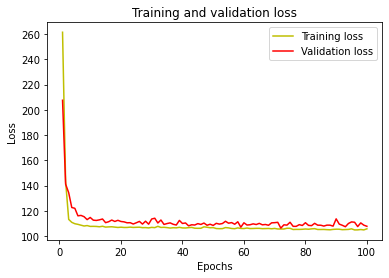


Predicted values are: 
 [[20.218878]
 [20.206963]
 [ 8.345018]
 [ 8.261982]
 [20.028435]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 142.1570 - mean_absolute_error: 8.1570

Mean squared error from neural net: 
 142.1570281982422

Mean absolute error from neural net: 
 8.157026290893555

Predicted values are:
  [[0.00060821 0.00061584 0.00057577 ... 0.00061338 0.00057645 0.00056049]
 [0.00060817 0.00061568 0.00057576 ... 0.00061327 0.00057655 0.00056062]
 [0.00060854 0.00062138 0.00059206 ... 0.00060944 0.00057105 0.00059079]
 [0.0006058  0.00061739 0.00059167 ... 0.00060554 0.00057268 0.00059152]
 [0.00060701 0.00061205 0.00057611 ... 0.00061091 0.00057887 0.00056441]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================

In [109]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 149.21420288085938

Mean absolute error from neural net: 
 8.736455917358398

 Mean squared error using Random Forest:  267.29792056790865

Mean absolute error Using Random Forest:  14.550505776375797


# Predict one day with 1 year of data

In [110]:
train = df.loc[df['connectionTime_year'] == 2018]

In [111]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'] == 1]

In [112]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [113]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_101 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 53.7734 - mean_absolute_error: 5.3328 - val_loss: 88.1629 - val_mean_absolute_error: 7.3235
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.5122 - mean_absolute_error: 4.9407 - val_loss: 81.0901 - val_mean_absolute_error: 6.7454
Epoch 3/100
383/383 [==========================

Epoch 45/100
383/383 [==============================] - 0s 983us/step - loss: 43.6325 - mean_absolute_error: 4.9056 - val_loss: 81.0110 - val_mean_absolute_error: 6.7639
Epoch 46/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6283 - mean_absolute_error: 4.9050 - val_loss: 82.7196 - val_mean_absolute_error: 6.9213
Epoch 47/100
383/383 [==============================] - 0s 968us/step - loss: 43.6682 - mean_absolute_error: 4.9084 - val_loss: 79.7647 - val_mean_absolute_error: 6.6236
Epoch 48/100
383/383 [==============================] - 0s 988us/step - loss: 43.6388 - mean_absolute_error: 4.9085 - val_loss: 82.5902 - val_mean_absolute_error: 6.8964
Epoch 49/100
383/383 [==============================] - 0s 987us/step - loss: 43.6695 - mean_absolute_error: 4.9098 - val_loss: 81.1885 - val_mean_absolute_error: 6.7739
Epoch 50/100
383/383 [==============================] - 0s 987us/step - loss: 43.6145 - mean_absolute_error: 4.9062 - val_loss: 85.0864 - val_mean_absol

383/383 [==============================] - 0s 985us/step - loss: 43.5045 - mean_absolute_error: 4.9012 - val_loss: 82.1859 - val_mean_absolute_error: 6.8569
Epoch 94/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5191 - mean_absolute_error: 4.9011 - val_loss: 80.9006 - val_mean_absolute_error: 6.7519
Epoch 95/100
383/383 [==============================] - 0s 973us/step - loss: 43.5500 - mean_absolute_error: 4.9061 - val_loss: 80.9255 - val_mean_absolute_error: 6.7461
Epoch 96/100
383/383 [==============================] - 0s 981us/step - loss: 43.5495 - mean_absolute_error: 4.9028 - val_loss: 82.5368 - val_mean_absolute_error: 6.9046
Epoch 97/100
383/383 [==============================] - 0s 977us/step - loss: 43.5437 - mean_absolute_error: 4.9017 - val_loss: 83.8980 - val_mean_absolute_error: 7.0177
Epoch 98/100
383/383 [==============================] - 0s 977us/step - loss: 43.5150 - mean_absolute_error: 4.9025 - val_loss: 83.0676 - val_mean_absolute_error: 6.

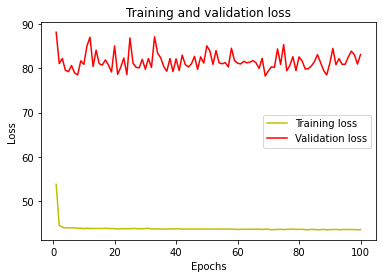


Predicted values are: 
 [[ 3.5186336]
 [ 1.8216875]
 [ 5.0476365]
 [13.080458 ]
 [ 6.0593076]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 210.6352 - mean_absolute_error: 9.2910

Mean squared error from neural net: 
 210.63516235351562

Mean absolute error from neural net: 
 9.29102897644043

Predicted values are:
  [[6.5917186e-05 6.5301021e-05 6.5680622e-05 ... 6.5898661e-05
  6.4764630e-05 6.5271044e-05]
 [6.6183100e-05 6.5452157e-05 6.5861306e-05 ... 6.6177803e-05
  6.5212975e-05 6.4989974e-05]
 [6.5439184e-05 6.5429136e-05 6.5453576e-05 ... 6.5420965e-05
  6.5414621e-05 6.5275475e-05]
 [6.5878659e-05 6.5268112e-05 6.5493186e-05 ... 6.5161184e-05
  6.5345965e-05 6.5131906e-05]
 [6.5406370e-05 6.5392698e-05 6.5423868e-05 ... 6.5388616e-05
  6.5357701e-05 6.5276603e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.

In [114]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 196.89022827148438

Mean absolute error from neural net: 
 8.821752548217773

 Mean squared error from Convolutional neural net:  247.55209350585938

Mean absolute error from Convolutional neural net:  9.516521453857422

# Predict 3 days with 1 year of data

In [115]:
train = df.loc[df['connectionTime_year'] == 2018]

In [116]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [117]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [118]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_106 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 53.7630 - mean_absolute_error: 5.3625 - val_loss: 85.8239 - val_mean_absolute_error: 7.1312
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.4769 - mean_absolute_error: 4.9423 - val_loss: 81.9909 - val_mean_absolute_error: 6.8251
Epoch 3/100
383/383 [==========================

Epoch 45/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6649 - mean_absolute_error: 4.9104 - val_loss: 81.1880 - val_mean_absolute_error: 6.7888
Epoch 46/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6307 - mean_absolute_error: 4.9056 - val_loss: 80.0545 - val_mean_absolute_error: 6.6612
Epoch 47/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6390 - mean_absolute_error: 4.9075 - val_loss: 82.8487 - val_mean_absolute_error: 6.9356
Epoch 48/100
383/383 [==============================] - 0s 978us/step - loss: 43.6131 - mean_absolute_error: 4.9076 - val_loss: 79.2032 - val_mean_absolute_error: 6.5662
Epoch 49/100
383/383 [==============================] - 0s 988us/step - loss: 43.6234 - mean_absolute_error: 4.9089 - val_loss: 80.4022 - val_mean_absolute_error: 6.7094
Epoch 50/100
383/383 [==============================] - 0s 982us/step - loss: 43.5553 - mean_absolute_error: 4.9111 - val_loss: 79.9947 - val_mean_absolute_

383/383 [==============================] - 0s 988us/step - loss: 43.4649 - mean_absolute_error: 4.9035 - val_loss: 79.4977 - val_mean_absolute_error: 6.6100
Epoch 94/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5554 - mean_absolute_error: 4.9082 - val_loss: 85.0184 - val_mean_absolute_error: 7.1095
Epoch 95/100
383/383 [==============================] - 0s 988us/step - loss: 43.5085 - mean_absolute_error: 4.9017 - val_loss: 82.1329 - val_mean_absolute_error: 6.8715
Epoch 96/100
383/383 [==============================] - 0s 977us/step - loss: 43.4849 - mean_absolute_error: 4.9018 - val_loss: 79.6601 - val_mean_absolute_error: 6.6257
Epoch 97/100
383/383 [==============================] - 0s 985us/step - loss: 43.4623 - mean_absolute_error: 4.8995 - val_loss: 80.0130 - val_mean_absolute_error: 6.6740
Epoch 98/100
383/383 [==============================] - 0s 980us/step - loss: 43.4379 - mean_absolute_error: 4.8927 - val_loss: 79.8632 - val_mean_absolute_error: 6.

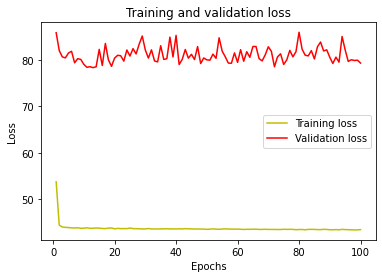


Predicted values are: 
 [[1.8527199]
 [1.0286015]
 [1.762671 ]
 [2.4620943]
 [1.8059082]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 203.0599 - mean_absolute_error: 10.4536

Mean squared error from neural net: 
 203.05990600585938

Mean absolute error from neural net: 
 10.453627586364746

Predicted values are:
  [[6.6593515e-05 6.7183828e-05 6.5198932e-05 ... 6.5723638e-05
  6.6296132e-05 6.3166415e-05]
 [6.6676774e-05 6.7437912e-05 6.5137232e-05 ... 6.5778469e-05
  6.6462882e-05 6.2851301e-05]
 [6.6300316e-05 6.6878740e-05 6.5216598e-05 ... 6.5681073e-05
  6.6108587e-05 6.3571446e-05]
 [6.6265507e-05 6.6727771e-05 6.5248925e-05 ... 6.5657718e-05
  6.6040462e-05 6.3697014e-05]
 [6.6279194e-05 6.6846427e-05 6.5221233e-05 ... 6.5675493e-05
  6.6086097e-05 6.3611158e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900

In [119]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 194.04220581054688

Mean absolute error from neural net: 
 10.17531681060791

 Mean squared error from Convolutional neural net:  285.1625061035156

Mean absolute error from Convolutional neural net:  11.897130966186523

# Predict 5 days with 1 year of data

In [120]:
train = df.loc[df['connectionTime_year'] == 2018]

In [121]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [122]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [123]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_111 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 51.6470 - mean_absolute_error: 5.2280 - val_loss: 84.4425 - val_mean_absolute_error: 7.0432
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.3159 - mean_absolute_error: 4.9322 - val_loss: 83.0730 - val_mean_absolute_error: 6.9302
Epoch 3/100
383/383 [==========================

Epoch 45/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6738 - mean_absolute_error: 4.9120 - val_loss: 80.0273 - val_mean_absolute_error: 6.6692
Epoch 46/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6852 - mean_absolute_error: 4.9140 - val_loss: 79.7461 - val_mean_absolute_error: 6.6212
Epoch 47/100
383/383 [==============================] - 0s 976us/step - loss: 43.6176 - mean_absolute_error: 4.9119 - val_loss: 81.3466 - val_mean_absolute_error: 6.8020
Epoch 48/100
383/383 [==============================] - 0s 977us/step - loss: 43.5836 - mean_absolute_error: 4.9039 - val_loss: 79.0407 - val_mean_absolute_error: 6.5277
Epoch 49/100
383/383 [==============================] - 0s 977us/step - loss: 43.6150 - mean_absolute_error: 4.8998 - val_loss: 79.2020 - val_mean_absolute_error: 6.5749
Epoch 50/100
383/383 [==============================] - 0s 974us/step - loss: 43.7049 - mean_absolute_error: 4.9116 - val_loss: 79.3491 - val_mean_absolut

383/383 [==============================] - 0s 988us/step - loss: 43.5385 - mean_absolute_error: 4.9064 - val_loss: 82.0772 - val_mean_absolute_error: 6.8597
Epoch 94/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5045 - mean_absolute_error: 4.8978 - val_loss: 79.5359 - val_mean_absolute_error: 6.6083
Epoch 95/100
383/383 [==============================] - 0s 975us/step - loss: 43.5404 - mean_absolute_error: 4.9106 - val_loss: 81.3953 - val_mean_absolute_error: 6.8144
Epoch 96/100
383/383 [==============================] - 0s 1000us/step - loss: 43.5481 - mean_absolute_error: 4.9074 - val_loss: 79.6309 - val_mean_absolute_error: 6.6234
Epoch 97/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5110 - mean_absolute_error: 4.9033 - val_loss: 80.8034 - val_mean_absolute_error: 6.7567
Epoch 98/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5060 - mean_absolute_error: 4.8996 - val_loss: 82.4316 - val_mean_absolute_error: 6.902

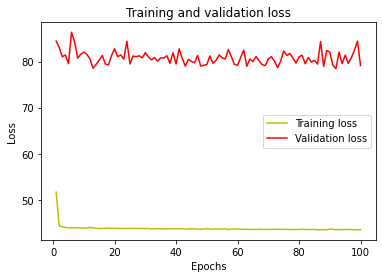


Predicted values are: 
 [[3.1884785]
 [2.5455031]
 [3.0678551]
 [3.4251726]
 [3.0870812]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
4/4 [==============================] - 0s 1ms/step - loss: 188.7890 - mean_absolute_error: 10.0361

Mean squared error from neural net: 
 188.78895568847656

Mean absolute error from neural net: 
 10.036142349243164

Predicted values are:
  [[6.6073328e-05 6.4859014e-05 6.4950465e-05 ... 6.3951062e-05
  6.6687411e-05 6.6117958e-05]
 [6.6130655e-05 6.4763539e-05 6.4858927e-05 ... 6.3648731e-05
  6.6814006e-05 6.6139386e-05]
 [6.5957742e-05 6.4878222e-05 6.4965439e-05 ... 6.3966072e-05
  6.6516594e-05 6.5998785e-05]
 [6.5920445e-05 6.4949367e-05 6.5013912e-05 ... 6.4132983e-05
  6.6440494e-05 6.5995569e-05]
 [6.5946377e-05 6.4884771e-05 6.4969470e-05 ... 6.3981286e-05
  6.6499713e-05 6.5992528e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900

In [124]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 204.65234375

Mean absolute error from neural net: 
 10.506291389465332

Mean squared error from Convolutional neural net:  243.2482147216797

Mean absolute error from Convolutional neural net:  11.08861255645752

# Predict 1 week with 1 year of data

In [125]:
train = df.loc[df['connectionTime_year'] == 2018]

In [126]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [127]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [128]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_116 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 52.9737 - mean_absolute_error: 5.2491 - val_loss: 89.3276 - val_mean_absolute_error: 7.3870
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.4116 - mean_absolute_error: 4.9347 - val_loss: 84.6414 - val_mean_absolute_error: 7.0669
Epoch 3/100
383/383 [==========================

Epoch 45/100
383/383 [==============================] - 0s 979us/step - loss: 43.6595 - mean_absolute_error: 4.9126 - val_loss: 83.7410 - val_mean_absolute_error: 7.0079
Epoch 46/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6214 - mean_absolute_error: 4.9038 - val_loss: 79.0484 - val_mean_absolute_error: 6.5252
Epoch 47/100
383/383 [==============================] - 0s 976us/step - loss: 43.6058 - mean_absolute_error: 4.9100 - val_loss: 85.3513 - val_mean_absolute_error: 7.1214
Epoch 48/100
383/383 [==============================] - 0s 979us/step - loss: 43.6740 - mean_absolute_error: 4.9108 - val_loss: 81.5245 - val_mean_absolute_error: 6.8111
Epoch 49/100
383/383 [==============================] - 0s 977us/step - loss: 43.5782 - mean_absolute_error: 4.9030 - val_loss: 79.3732 - val_mean_absolute_error: 6.5943
Epoch 50/100
383/383 [==============================] - 0s 971us/step - loss: 43.5819 - mean_absolute_error: 4.9048 - val_loss: 78.6837 - val_mean_absol

383/383 [==============================] - 1s 2ms/step - loss: 43.5638 - mean_absolute_error: 4.9026 - val_loss: 81.4444 - val_mean_absolute_error: 6.8025
Epoch 94/100
383/383 [==============================] - 1s 2ms/step - loss: 43.5260 - mean_absolute_error: 4.9066 - val_loss: 81.7113 - val_mean_absolute_error: 6.8383
Epoch 95/100
383/383 [==============================] - 1s 1ms/step - loss: 43.5225 - mean_absolute_error: 4.9025 - val_loss: 81.9902 - val_mean_absolute_error: 6.8623
Epoch 96/100
383/383 [==============================] - 1s 2ms/step - loss: 43.5550 - mean_absolute_error: 4.9067 - val_loss: 85.0240 - val_mean_absolute_error: 7.1064
Epoch 97/100
383/383 [==============================] - 1s 1ms/step - loss: 43.5016 - mean_absolute_error: 4.9016 - val_loss: 83.8590 - val_mean_absolute_error: 7.0193
Epoch 98/100
383/383 [==============================] - 1s 1ms/step - loss: 43.5497 - mean_absolute_error: 4.9035 - val_loss: 80.1595 - val_mean_absolute_error: 6.6752
Epoch

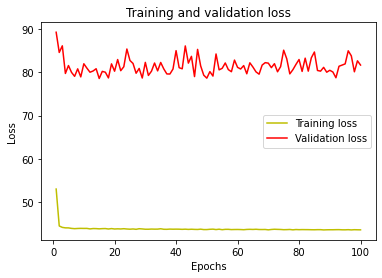


Predicted values are: 
 [[3.7666142]
 [3.4419963]
 [3.6351733]
 [3.8022351]
 [3.6396096]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
6/6 [==============================] - 0s 1ms/step - loss: 173.7426 - mean_absolute_error: 9.6312

Mean squared error from neural net: 
 173.7426300048828

Mean absolute error from neural net: 
 9.63121509552002

Predicted values are:
  [[6.6030952e-05 6.5524364e-05 6.6028355e-05 ... 6.6298111e-05
  6.6138164e-05 6.5209977e-05]
 [6.6112305e-05 6.5481734e-05 6.6056957e-05 ... 6.6349319e-05
  6.6195171e-05 6.5160420e-05]
 [6.5971239e-05 6.5483575e-05 6.5961962e-05 ... 6.6221233e-05
  6.6085682e-05 6.5187451e-05]
 [6.5932509e-05 6.5497421e-05 6.5942790e-05 ... 6.6180073e-05
  6.6059976e-05 6.5216751e-05]
 [6.5964516e-05 6.5481931e-05 6.5955552e-05 ... 6.6212975e-05
  6.6079730e-05 6.5188258e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
153

In [129]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 181.9652557373047

Mean absolute error from neural net: 
 9.92181396484375

Mean squared error using Random Forest:  265.9261997741879

Mean absolute error Using Random Forest:  12.808809250546634


# Overall All Spaces

When ran on the 24 different DataFrames the following models occured:

Sequential Neural Network: 24 Times

Convolutional Neural Network: 4 Times

Linear Regression: 2 Times

Decision Tree: 2 Times

Random Forest: 16 Times

# Best result

2 Months 1 Day

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Mean squared error using Random Forest:  87.59891941785604

Mean absolute error Using Random Forest:  7.123862400000002

# Best 3 Day result

2 Months 3 Days

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Mean squared error using Random Forest:  113.78877579587008

Mean absolute error Using Random Forest:  7.631643458292483

# Best 5 day result

2 Months 5 Days

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945


Mean squared error using Random Forest:  100.1006992130904

Mean absolute error Using Random Forest:  7.348763723404256

# Best 1 Week Result

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

 Mean squared error using Random Forest:  106.3441792968664

Mean absolute error Using Random Forest:  6.811379829758829


# Individual Spaces 

In [130]:
#create unique list of names
UniqueNames = df.spaceID.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.spaceID == key]

In [131]:
UniqueNames

array(['CA-496', 'CA-319', 'CA-489', 'CA-327', 'CA-490', 'CA-303',
       'CA-499', 'CA-325', 'CA-491', 'CA-323', 'CA-317', 'CA-493',
       'CA-322', 'CA-311', 'CA-321', 'CA-309', 'CA-492', 'CA-315',
       'CA-497', 'CA-312', 'CA-501', 'CA-498', 'CA-313', 'CA-500',
       'CA-495', 'CA-314', 'CA-316', 'CA-502', 'CA-320', 'CA-326',
       'CA-503', 'CA-494', 'CA-324', 'CA-304', 'CA-308', 'CA-505',
       'CA-310', 'CA-305', 'CA-306', 'CA-318', 'CA-512', 'CA-510',
       'CA-307', 'CA-513', 'CA-507', 'CA-504', 'CA-509', 'CA-511',
       'CA-212', 'CA-508', 'CA-506', 'CA-149', 'CA-213', 'CA-148',
       '11900388'], dtype=object)

# Space 324

# 1 month of training data to predict the demand of 1 space for 1 day

In [132]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [133]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [134]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [135]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_121 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 413ms/step - loss: 275.3026 - mean_absolute_error: 13.2212 - val_loss: 62.4734 - val_mean_absolute_error: 7.1567
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 272.7982 - mean_absolute_error: 13.1371 - val_loss: 60.5905 - val_mean_absolute_error: 7.0160
Epoch 3/100
1/1 [==============================]

1/1 [==============================] - 0s 18ms/step - loss: 141.0132 - mean_absolute_error: 8.1865 - val_loss: 20.8878 - val_mean_absolute_error: 3.9520
Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 136.9671 - mean_absolute_error: 7.9847 - val_loss: 22.9528 - val_mean_absolute_error: 4.1904
Epoch 47/100
1/1 [==============================] - 0s 20ms/step - loss: 133.0008 - mean_absolute_error: 7.7778 - val_loss: 25.3792 - val_mean_absolute_error: 4.4339
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 129.1321 - mean_absolute_error: 7.5663 - val_loss: 28.1834 - val_mean_absolute_error: 4.6823
Epoch 49/100
1/1 [==============================] - 0s 19ms/step - loss: 125.3759 - mean_absolute_error: 7.3502 - val_loss: 31.3751 - val_mean_absolute_error: 4.9348
Epoch 50/100
1/1 [==============================] - 0s 19ms/step - loss: 121.7469 - mean_absolute_error: 7.1922 - val_loss: 34.9671 - val_mean_absolute_error: 5.1912
Epoch 51/100
1/1 

1/1 [==============================] - 0s 19ms/step - loss: 78.5526 - mean_absolute_error: 5.6881 - val_loss: 209.4264 - val_mean_absolute_error: 13.3573
Epoch 95/100
1/1 [==============================] - 0s 19ms/step - loss: 78.2585 - mean_absolute_error: 5.6803 - val_loss: 208.8757 - val_mean_absolute_error: 13.3359
Epoch 96/100
1/1 [==============================] - 0s 20ms/step - loss: 77.9605 - mean_absolute_error: 5.6721 - val_loss: 208.1534 - val_mean_absolute_error: 13.3084
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 77.6622 - mean_absolute_error: 5.6637 - val_loss: 207.3147 - val_mean_absolute_error: 13.2767
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 77.3684 - mean_absolute_error: 5.6555 - val_loss: 206.4625 - val_mean_absolute_error: 13.2444
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 77.0703 - mean_absolute_error: 5.6473 - val_loss: 205.6585 - val_mean_absolute_error: 13.2138
Epoch 100/1

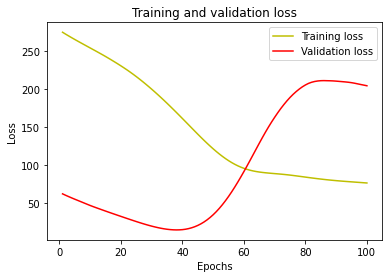


Predicted values are: 
 [[4.54201]]

Real values are: 
 16309    8.727
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 17.5141 - mean_absolute_error: 4.1850

Mean squared error from neural net: 
 17.514144897460938

Mean absolute error from neural net: 
 4.184990406036377

Predicted values are:
  [[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05]]

Real values are: 
 16309    8.727
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 159ms/step - loss: 75.2903 - mean_absolute_error: 8.6770

Mean squared error from Convolutional neural net:  75.29032897949219

Mean absolute error from Convolutional neural net:  8.677000045776367

Mean squared error from linear regression:  10.540411559717693

Mean absolute error from linear regression:  3.2465999999565227

Mean squared error using decision tree:  52.765696000000005

Mean absolute error using decision tree:  7.264

In [136]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 18.237812042236328

Mean absolute error from neural net: 
 4.270575046539307

 Mean squared error from linear regression:  10.540411559717693

Mean absolute error from linear regression:  3.2465999999565227

# 1 Month to predict 1 week

In [137]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [138]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [139]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [140]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_126 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 369ms/step - loss: 145.4107 - mean_absolute_error: 10.1738 - val_loss: 109.8051 - val_mean_absolute_error: 7.3582
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 143.6326 - mean_absolute_error: 10.0828 - val_loss: 107.9218 - val_mean_absolute_error: 7.2349
Epoch 3/100
1/1 [=============================

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 58.5404 - mean_absolute_error: 6.1943 - val_loss: 68.7553 - val_mean_absolute_error: 7.5824
Epoch 47/100
1/1 [==============================] - 0s 21ms/step - loss: 57.1162 - mean_absolute_error: 6.1769 - val_loss: 72.6036 - val_mean_absolute_error: 7.9233
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 55.7436 - mean_absolute_error: 6.1569 - val_loss: 76.9988 - val_mean_absolute_error: 8.2710
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 54.4181 - mean_absolute_error: 6.1325 - val_loss: 81.9538 - val_mean_absolute_error: 8.6247
Epoch 50/100
1/1 [==============================] - 0s 20ms/step - loss: 53.1343 - mean_absolute_error: 6.1035 - val_loss: 87.4908 - val_mean_absolute_error: 8.9841
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 51.8908 - mean_absolute_error: 6.0701 - val_loss: 93.6197 - val_mean_absolute_error: 9.3482
Epoch 52/1

1/1 [==============================] - 0s 19ms/step - loss: 33.3756 - mean_absolute_error: 4.8754 - val_loss: 368.7941 - val_mean_absolute_error: 17.7128
Epoch 96/100
1/1 [==============================] - 0s 19ms/step - loss: 33.2211 - mean_absolute_error: 4.8630 - val_loss: 368.0092 - val_mean_absolute_error: 17.6861
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 33.0708 - mean_absolute_error: 4.8508 - val_loss: 367.4228 - val_mean_absolute_error: 17.6651
Epoch 98/100
1/1 [==============================] - 0s 19ms/step - loss: 32.9243 - mean_absolute_error: 4.8387 - val_loss: 367.0573 - val_mean_absolute_error: 17.6502
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 32.7800 - mean_absolute_error: 4.8265 - val_loss: 366.9077 - val_mean_absolute_error: 17.6413
Epoch 100/100
1/1 [==============================] - 0s 20ms/step - loss: 32.6402 - mean_absolute_error: 4.8144 - val_loss: 366.9973 - val_mean_absolute_error: 17.6388


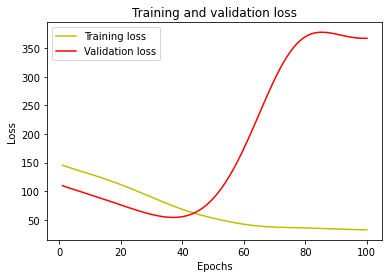


Predicted values are: 
 [[8.002092 ]
 [7.8654623]
 [8.741582 ]
 [8.138614 ]
 [7.6585107]]

Real values are: 
 3903    13.811
3913     8.320
3937    31.814
3961     8.689
4032    10.649
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 183.0985 - mean_absolute_error: 10.4178

Mean squared error from neural net: 
 183.09854125976562

Mean absolute error from neural net: 
 10.417774200439453

Predicted values are:
  [[0.02917607 0.02622482 0.03055026 0.02902213 0.03570479 0.03009334
  0.03481476 0.03248244 0.03324994 0.02889053 0.02812118 0.03356683
  0.02967468 0.02979529 0.02731717 0.02911406 0.03108076 0.03243959
  0.02894709 0.02851522 0.0321271  0.02752562 0.0320871  0.03038186
  0.02693775 0.03218579 0.02618752 0.03064938 0.02895696 0.03393934
  0.03153223 0.03067835 0.02803012]
 [0.02914214 0.02643979 0.03062178 0.02907932 0.03561784 0.03014699
  0.03455937 0.03260553 0.03319669 0.02888818 0.0282404  0.03344468
  0.02966112 0.02976486 0

In [141]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 179.09262084960938

Mean absolute error from neural net: 
 10.296606063842773

 Mean squared error using Random Forest:  124.18021324321256

Mean absolute error Using Random Forest:  7.787178750000004


# 6 Month training 1 week predicition

In [142]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [143]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [144]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [145]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_131 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 35ms/step - loss: 178.4082 - mean_absolute_error: 10.2926 - val_loss: 103.3585 - val_mean_absolute_error: 8.3439
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 171.3537 - mean_absolute_error: 9.9533 - val_loss: 95.1000 - val_mean_absolute_error: 7.8424
Epoch 3/100
4/4 [==============================] -

4/4 [==============================] - 0s 6ms/step - loss: 66.9153 - mean_absolute_error: 5.8576 - val_loss: 75.8741 - val_mean_absolute_error: 7.5058
Epoch 47/100
4/4 [==============================] - 0s 6ms/step - loss: 66.8894 - mean_absolute_error: 5.8799 - val_loss: 74.7586 - val_mean_absolute_error: 7.4388
Epoch 48/100
4/4 [==============================] - 0s 6ms/step - loss: 66.9285 - mean_absolute_error: 5.8979 - val_loss: 72.5808 - val_mean_absolute_error: 7.3253
Epoch 49/100
4/4 [==============================] - 0s 6ms/step - loss: 66.8983 - mean_absolute_error: 5.9136 - val_loss: 72.7329 - val_mean_absolute_error: 7.3260
Epoch 50/100
4/4 [==============================] - 0s 6ms/step - loss: 66.7689 - mean_absolute_error: 5.9139 - val_loss: 74.4934 - val_mean_absolute_error: 7.4080
Epoch 51/100
4/4 [==============================] - 0s 6ms/step - loss: 66.4679 - mean_absolute_error: 5.8868 - val_loss: 76.5301 - val_mean_absolute_error: 7.5249
Epoch 52/100
4/4 [===========

4/4 [==============================] - 0s 6ms/step - loss: 64.0100 - mean_absolute_error: 5.8027 - val_loss: 70.4390 - val_mean_absolute_error: 6.9793
Epoch 97/100
4/4 [==============================] - 0s 7ms/step - loss: 63.7824 - mean_absolute_error: 5.8280 - val_loss: 71.1662 - val_mean_absolute_error: 7.0077
Epoch 98/100
4/4 [==============================] - 0s 6ms/step - loss: 63.9493 - mean_absolute_error: 5.8863 - val_loss: 70.8481 - val_mean_absolute_error: 6.9876
Epoch 99/100
4/4 [==============================] - 0s 7ms/step - loss: 64.1652 - mean_absolute_error: 5.9481 - val_loss: 68.5038 - val_mean_absolute_error: 6.8590
Epoch 100/100
4/4 [==============================] - 0s 6ms/step - loss: 64.3541 - mean_absolute_error: 5.9725 - val_loss: 66.5740 - val_mean_absolute_error: 6.7658


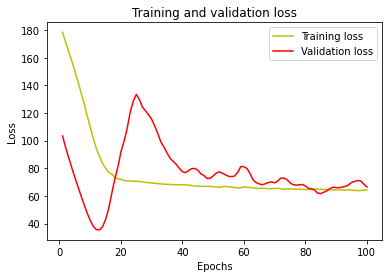


Predicted values are: 
 [[10.318101]
 [14.029453]]

Real values are: 
 21113    2.18
21134    3.22
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 91.5365 - mean_absolute_error: 9.4738

Mean squared error from neural net: 
 91.53648376464844

Mean absolute error from neural net: 
 9.473776817321777

Predicted values are:
  [[0.00748047 0.00732952 0.00772738 0.00766625 0.00773359 0.00793976
  0.00714365 0.00775507 0.007866   0.00759866 0.00786023 0.00798858
  0.00755675 0.00822099 0.00775221 0.00760804 0.00767293 0.00786948
  0.00793432 0.00770142 0.00731535 0.00746085 0.00808813 0.00807919
  0.00718901 0.00702733 0.00755331 0.00848978 0.00723657 0.00724156
  0.00735853 0.00784545 0.00803044 0.00792531 0.00819336 0.00744402
  0.00812287 0.00860417 0.00811608 0.00852376 0.00795319 0.00766369
  0.00838968 0.00769375 0.00778793 0.0075511  0.00702182 0.00712876
  0.00775527 0.00760169 0.00740652 0.00816052 0.00780131 0.0073171
  0.0073576  0.0

In [146]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 87.76254272460938

Mean absolute error from neural net: 
 9.301206588745117

 Mean squared error from Convolutional neural net:  7.518273830413818

Mean absolute error from Convolutional neural net:  2.692187547683716

# Space 322

# 1 month of training data to predict the demand of 1 space for 1 day

In [147]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [148]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [149]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [150]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_136 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 368ms/step - loss: 128.1883 - mean_absolute_error: 8.2065 - val_loss: 69.0717 - val_mean_absolute_error: 8.1835
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 127.0204 - mean_absolute_error: 8.1298 - val_loss: 67.0147 - val_mean_absolute_error: 8.0544
Epoch 3/100
1/1 [==============================] -

Epoch 46/100
1/1 [==============================] - 0s 17ms/step - loss: 84.4575 - mean_absolute_error: 6.1682 - val_loss: 5.7198 - val_mean_absolute_error: 1.8820
Epoch 47/100
1/1 [==============================] - 0s 20ms/step - loss: 83.5456 - mean_absolute_error: 6.1536 - val_loss: 5.4196 - val_mean_absolute_error: 1.7614
Epoch 48/100
1/1 [==============================] - 0s 38ms/step - loss: 82.6738 - mean_absolute_error: 6.1384 - val_loss: 5.3145 - val_mean_absolute_error: 1.6612
Epoch 49/100
1/1 [==============================] - 0s 22ms/step - loss: 81.8437 - mean_absolute_error: 6.1228 - val_loss: 5.4215 - val_mean_absolute_error: 1.7597
Epoch 50/100
1/1 [==============================] - 0s 16ms/step - loss: 81.0561 - mean_absolute_error: 6.1066 - val_loss: 5.7560 - val_mean_absolute_error: 1.9572
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 80.3098 - mean_absolute_error: 6.0899 - val_loss: 6.3317 - val_mean_absolute_error: 2.1588
Epoch 52/100
1/1

1/1 [==============================] - 0s 18ms/step - loss: 67.2593 - mean_absolute_error: 5.3890 - val_loss: 61.5249 - val_mean_absolute_error: 7.5362
Epoch 96/100
1/1 [==============================] - 0s 20ms/step - loss: 67.0439 - mean_absolute_error: 5.3901 - val_loss: 60.3824 - val_mean_absolute_error: 7.4783
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 66.8327 - mean_absolute_error: 5.3913 - val_loss: 59.3533 - val_mean_absolute_error: 7.4269
Epoch 98/100
1/1 [==============================] - 0s 24ms/step - loss: 66.6237 - mean_absolute_error: 5.3924 - val_loss: 58.4875 - val_mean_absolute_error: 7.3851
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 66.4149 - mean_absolute_error: 5.3931 - val_loss: 57.7458 - val_mean_absolute_error: 7.3507
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 66.2062 - mean_absolute_error: 5.3932 - val_loss: 57.1399 - val_mean_absolute_error: 7.3244


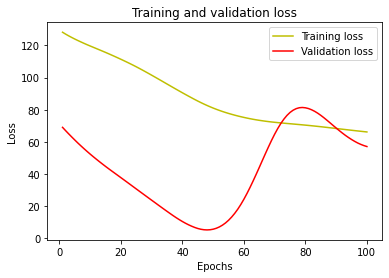


Predicted values are: 
 [[3.416062]]

Real values are: 
 16301    12.886
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 89.6797 - mean_absolute_error: 9.4699

Mean squared error from neural net: 
 89.6797103881836

Mean absolute error from neural net: 
 9.469937324523926

Predicted values are:
  [[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
  0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
  0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]]

Real values are: 
 16301    12.886
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 180ms/step - loss: 164.6203 - mean_absolute_error: 12.8304

Mean squared error from Convolutional neural net:  164.62030029296875

Mean absolute error from Convolutional neural net:  12.8304443359375

Mean squared error from linear regression:  23.0043599508838

Mean absolute error from linear regression:  4.796286058074914

Mean squ

In [151]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  23.0043599508838

Mean absolute error from linear regression:  4.796286058074914

Mean squared error using decision tree:  17.32224399999999

Mean absolute error using decision tree:  4.161999999999999

# 1 Month to predict 1 week

In [152]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [153]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [154]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [155]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_141 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_142 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 408ms/step - loss: 147.7845 - mean_absolute_error: 9.0439 - val_loss: 149.8041 - val_mean_absolute_error: 9.9058
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 145.9833 - mean_absolute_error: 8.9508 - val_loss: 147.1987 - val_mean_absolute_error: 9.7796
Epoch 3/100
1/1 [==============================]

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 73.5690 - mean_absolute_error: 6.2835 - val_loss: 42.4755 - val_mean_absolute_error: 5.5234
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 72.4274 - mean_absolute_error: 6.2454 - val_loss: 42.1880 - val_mean_absolute_error: 5.6980
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 71.3394 - mean_absolute_error: 6.2194 - val_loss: 42.2266 - val_mean_absolute_error: 5.8740
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 70.3033 - mean_absolute_error: 6.1919 - val_loss: 42.5960 - val_mean_absolute_error: 6.0503
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 69.3085 - mean_absolute_error: 6.1625 - val_loss: 43.3069 - val_mean_absolute_error: 6.2270
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 68.3486 - mean_absolute_error: 6.1456 - val_loss: 44.3480 - val_mean_absolute_error: 6.4026
Epoch 52/1

Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 49.1574 - mean_absolute_error: 5.2633 - val_loss: 50.0016 - val_mean_absolute_error: 6.7729
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 48.8862 - mean_absolute_error: 5.2518 - val_loss: 48.7360 - val_mean_absolute_error: 6.7061
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 48.6191 - mean_absolute_error: 5.2445 - val_loss: 47.5578 - val_mean_absolute_error: 6.6418
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 48.3552 - mean_absolute_error: 5.2370 - val_loss: 46.4688 - val_mean_absolute_error: 6.5804
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 48.0856 - mean_absolute_error: 5.2283 - val_loss: 45.4496 - val_mean_absolute_error: 6.5212


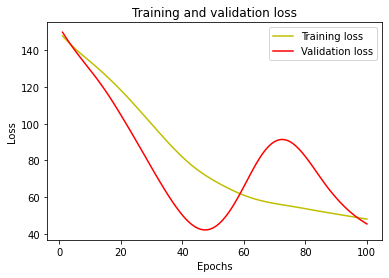


Predicted values are: 
 [[19.580158 ]
 [ 6.862602 ]
 [ 5.03366  ]
 [ 4.0430307]
 [ 4.2237144]]

Real values are: 
 3905     2.683
3948     4.958
4027    20.483
4056    22.438
4103     5.126
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 119.7617 - mean_absolute_error: 8.6061

Mean squared error from neural net: 
 119.7617416381836

Mean absolute error from neural net: 
 8.60611629486084

Predicted values are:
  [[0.02539938 0.02131156 0.02686949 0.03270176 0.02583142 0.02743104
  0.02569037 0.02771566 0.02388377 0.02527059 0.02698684 0.02395359
  0.02627813 0.02968976 0.02149953 0.02837946 0.02780759 0.0281131
  0.02514036 0.0252576  0.03320261 0.02488734 0.02645018 0.02592428
  0.02739429 0.03717501 0.02509462 0.02785051 0.0223004  0.02997974
  0.02404129 0.02652314 0.02594725 0.03133588 0.03659526 0.02345286
  0.02663437]
 [0.0275693  0.02374882 0.02612658 0.03023081 0.02596776 0.02694106
  0.02838065 0.02839963 0.02544796 0.02715256 0

In [156]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 115.94696044921875

Mean absolute error from neural net: 
 8.477322578430176

 Mean squared error from Convolutional neural net:  125.59464263916016

Mean absolute error from Convolutional neural net:  8.888972282409668


# 6 Month training 1 week predicition

In [157]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [158]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [159]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [160]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_146 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 33ms/step - loss: 138.7574 - mean_absolute_error: 8.1092 - val_loss: 183.8677 - val_mean_absolute_error: 7.9776
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 132.3417 - mean_absolute_error: 7.7544 - val_loss: 178.8045 - val_mean_absolute_error: 7.7103
Epoch 3/100
4/4 [==============================] -

4/4 [==============================] - 0s 6ms/step - loss: 67.5770 - mean_absolute_error: 5.8278 - val_loss: 125.4416 - val_mean_absolute_error: 6.7852
Epoch 47/100
4/4 [==============================] - 0s 6ms/step - loss: 67.6595 - mean_absolute_error: 5.8576 - val_loss: 126.3678 - val_mean_absolute_error: 6.7799
Epoch 48/100
4/4 [==============================] - 0s 6ms/step - loss: 67.4044 - mean_absolute_error: 5.8565 - val_loss: 127.0672 - val_mean_absolute_error: 6.7786
Epoch 49/100
4/4 [==============================] - 0s 6ms/step - loss: 67.1205 - mean_absolute_error: 5.8391 - val_loss: 127.4294 - val_mean_absolute_error: 6.7732
Epoch 50/100
4/4 [==============================] - 0s 14ms/step - loss: 66.9447 - mean_absolute_error: 5.8665 - val_loss: 127.8591 - val_mean_absolute_error: 6.7676
Epoch 51/100
4/4 [==============================] - 0s 7ms/step - loss: 66.9080 - mean_absolute_error: 5.8935 - val_loss: 128.4743 - val_mean_absolute_error: 6.7657
Epoch 52/100
4/4 [====

Epoch 96/100
4/4 [==============================] - 0s 7ms/step - loss: 62.8492 - mean_absolute_error: 5.5972 - val_loss: 158.7978 - val_mean_absolute_error: 8.1384
Epoch 97/100
4/4 [==============================] - 0s 6ms/step - loss: 62.5606 - mean_absolute_error: 5.5676 - val_loss: 164.5606 - val_mean_absolute_error: 8.3414
Epoch 98/100
4/4 [==============================] - 0s 7ms/step - loss: 62.8506 - mean_absolute_error: 5.5515 - val_loss: 168.9275 - val_mean_absolute_error: 8.5130
Epoch 99/100
4/4 [==============================] - 0s 6ms/step - loss: 62.9149 - mean_absolute_error: 5.5352 - val_loss: 169.1714 - val_mean_absolute_error: 8.5298
Epoch 100/100
4/4 [==============================] - 0s 6ms/step - loss: 62.6729 - mean_absolute_error: 5.5524 - val_loss: 168.4547 - val_mean_absolute_error: 8.5115


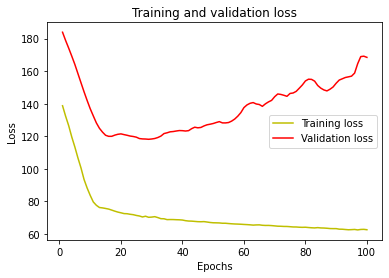


Predicted values are: 
 [[ 7.020266]
 [ 6.890924]
 [10.980308]
 [11.468019]
 [11.94912 ]]

Real values are: 
 21112     0.839
21115    11.867
21143     1.042
21144     0.950
21146     1.024
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 78.3453 - mean_absolute_error: 8.5078

Mean squared error from neural net: 
 78.34526062011719

Mean absolute error from neural net: 
 8.507757186889648

Predicted values are:
  [[0.00838537 0.00807021 0.00745636 0.00952184 0.00823783 0.00785097
  0.00827784 0.00766672 0.00866113 0.00778093 0.00757708 0.00687347
  0.00741948 0.00705971 0.00672341 0.00830645 0.00812406 0.00757757
  0.00740594 0.00747806 0.00814522 0.00856163 0.0087092  0.00831642
  0.00762165 0.0069293  0.00752411 0.00906391 0.00860516 0.00731698
  0.0078425  0.00697564 0.00787828 0.0079742  0.00927739 0.00865509
  0.00770458 0.00688238 0.00733308 0.0063571  0.00658743 0.00793766
  0.00747051 0.00784901 0.00881208 0.00783567 0.00737952 0.0

In [161]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 67.17460632324219

Mean absolute error from neural net: 
 7.740140438079834

 Mean squared error from Convolutional neural net:  28.86421775817871

Mean absolute error from Convolutional neural net:  3.136587381362915

# Space 497

# 1 month of training data to predict the demand of 1 space for 1 day

In [162]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [163]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [164]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [165]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_151 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 351ms/step - loss: 385.6790 - mean_absolute_error: 15.5292 - val_loss: 414.2309 - val_mean_absolute_error: 15.0886
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 382.5794 - mean_absolute_error: 15.4315 - val_loss: 409.9127 - val_mean_absolute_error: 14.9413
Epoch 3/100
1/1 [===========================

1/1 [==============================] - 0s 42ms/step - loss: 212.1511 - mean_absolute_error: 11.3052 - val_loss: 203.6949 - val_mean_absolute_error: 9.7012
Epoch 46/100
1/1 [==============================] - 0s 22ms/step - loss: 207.9978 - mean_absolute_error: 11.2842 - val_loss: 200.1808 - val_mean_absolute_error: 9.9531
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 204.0180 - mean_absolute_error: 11.2623 - val_loss: 197.0926 - val_mean_absolute_error: 10.2113
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 200.2200 - mean_absolute_error: 11.2395 - val_loss: 194.4721 - val_mean_absolute_error: 10.4755
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 196.6134 - mean_absolute_error: 11.2158 - val_loss: 192.3578 - val_mean_absolute_error: 10.7450
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 193.2031 - mean_absolute_error: 11.1910 - val_loss: 190.7895 - val_mean_absolute_error: 11.0197
E

Epoch 94/100
1/1 [==============================] - 0s 18ms/step - loss: 110.7160 - mean_absolute_error: 9.1681 - val_loss: 523.8843 - val_mean_absolute_error: 19.7476
Epoch 95/100
1/1 [==============================] - 0s 17ms/step - loss: 109.3955 - mean_absolute_error: 9.0964 - val_loss: 528.8678 - val_mean_absolute_error: 19.9213
Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 108.0814 - mean_absolute_error: 9.0230 - val_loss: 533.5825 - val_mean_absolute_error: 20.0885
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 106.7863 - mean_absolute_error: 8.9485 - val_loss: 538.2081 - val_mean_absolute_error: 20.2511
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 105.5195 - mean_absolute_error: 8.8728 - val_loss: 542.8300 - val_mean_absolute_error: 20.4102
Epoch 99/100
1/1 [==============================] - 0s 46ms/step - loss: 104.3106 - mean_absolute_error: 8.7985 - val_loss: 547.5981 - val_mean_absolute_error: 

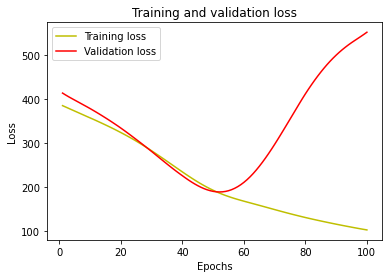


Predicted values are: 
 [[12.247461]
 [16.310205]]

Real values are: 
 16295    13.511
16318     8.647
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 30.1606 - mean_absolute_error: 4.4634

Mean squared error from neural net: 
 30.160621643066406

Mean absolute error from neural net: 
 4.463371753692627

Predicted values are:
  [[0.05006831 0.04971521 0.04568181 0.04848729 0.04569064 0.05522906
  0.04297751 0.04625642 0.05579115 0.04856674 0.05306301 0.04598582
  0.04980008 0.05505202 0.0495103  0.0527048  0.05623752 0.05035167
  0.04675471 0.05207593]
 [0.04947048 0.05368528 0.04984293 0.04563027 0.04957556 0.04903535
  0.04685603 0.04885659 0.05431961 0.04620451 0.05152078 0.04735529
  0.05246659 0.05400793 0.05020184 0.05162757 0.05115473 0.04949026
  0.04633825 0.0523601 ]]

Real values are: 
 16295    13.511
16318     8.647
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 155ms/step - loss: 127.5535 - mean

In [166]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 33.54694366455078

Mean absolute error from neural net: 
 5.298711776733398

Mean squared error using Random Forest:  8.430320786899973

Mean absolute error Using Random Forest:  2.713869999999991

# 1 Month to predict 1 week

In [167]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [168]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [169]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [170]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_156 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 356ms/step - loss: 128.2842 - mean_absolute_error: 9.6894 - val_loss: 53.0434 - val_mean_absolute_error: 5.7038
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 126.6310 - mean_absolute_error: 9.5891 - val_loss: 51.0408 - val_mean_absolute_error: 5.5179
Epoch 3/100
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step - loss: 65.4432 - mean_absolute_error: 6.3005 - val_loss: 77.9435 - val_mean_absolute_error: 7.7625
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 64.3226 - mean_absolute_error: 6.2418 - val_loss: 85.8288 - val_mean_absolute_error: 8.1273
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 63.2173 - mean_absolute_error: 6.1855 - val_loss: 94.3473 - val_mean_absolute_error: 8.4968
Epoch 49/100
1/1 [==============================] - 0s 16ms/step - loss: 62.1274 - mean_absolute_error: 6.1277 - val_loss: 103.4996 - val_mean_absolute_error: 8.8704
Epoch 50/100
1/1 [==============================] - 0s 18ms/step - loss: 61.0488 - mean_absolute_error: 6.0665 - val_loss: 113.2782 - val_mean_absolute_error: 9.3844
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 59.9899 - mean_absolute_error: 6.0022 - val_loss: 123.6761 - val_mean_absolute_error: 9.9169
Epoch 52/100
1/1 [==

1/1 [==============================] - 0s 17ms/step - loss: 37.7476 - mean_absolute_error: 4.7720 - val_loss: 255.5419 - val_mean_absolute_error: 15.3082
Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 37.4418 - mean_absolute_error: 4.7567 - val_loss: 250.9227 - val_mean_absolute_error: 15.1589
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 37.1520 - mean_absolute_error: 4.7422 - val_loss: 246.5272 - val_mean_absolute_error: 15.0152
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 36.8702 - mean_absolute_error: 4.7333 - val_loss: 242.3462 - val_mean_absolute_error: 14.8771
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 36.5904 - mean_absolute_error: 4.7272 - val_loss: 238.3938 - val_mean_absolute_error: 14.7450
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 36.3171 - mean_absolute_error: 4.7210 - val_loss: 234.6763 - val_mean_absolute_error: 14.6192


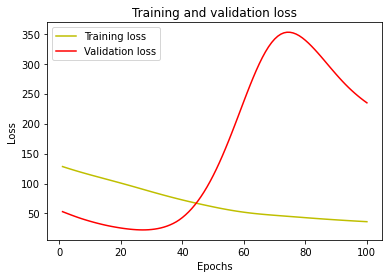


Predicted values are: 
 [[13.134346]
 [ 5.705022]
 [12.216094]]

Real values are: 
 4042     6.641
4118    36.395
4184     9.835
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 329.9026 - mean_absolute_error: 13.1881

Mean squared error from neural net: 
 329.90264892578125

Mean absolute error from neural net: 
 13.188139915466309

Predicted values are:
  [[0.03431042 0.03146833 0.03220997 0.02938398 0.02629253 0.02745179
  0.03276004 0.02650435 0.03361999 0.03214606 0.03211155 0.02666699
  0.03462884 0.02663156 0.03006893 0.03126521 0.03327402 0.03363307
  0.0233095  0.03010773 0.03341534 0.03131364 0.03311384 0.02881413
  0.03164696 0.03095227 0.02775404 0.03043455 0.0282557  0.02928549
  0.03041653 0.02988902 0.02686371]
 [0.03105216 0.03127334 0.03114074 0.03027252 0.02996166 0.03033233
  0.03096431 0.02941044 0.03054217 0.03002113 0.03106043 0.02976252
  0.02979142 0.02985927 0.03029837 0.02967292 0.0306459  0.0306421
  0.02927665 0

In [171]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  181.30599388416144

Mean absolute error from linear regression:  8.823666666480948

Mean squared error using Random Forest:  194.13588130859986

Mean absolute error Using Random Forest:  10.142719999999999

# 6 Month training 1 week predicition

In [172]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [173]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [174]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [175]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_161 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 49ms/step - loss: 324.9857 - mean_absolute_error: 14.2959 - val_loss: 92.7467 - val_mean_absolute_error: 8.1180
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 317.4304 - mean_absolute_error: 14.0384 - val_loss: 89.4574 - val_mean_absolute_error: 7.8941
Epoch 3/100
3/3 [==============================] 

Epoch 46/100
3/3 [==============================] - 0s 10ms/step - loss: 104.8792 - mean_absolute_error: 7.5348 - val_loss: 42.1447 - val_mean_absolute_error: 4.9764
Epoch 47/100
3/3 [==============================] - 0s 21ms/step - loss: 104.3805 - mean_absolute_error: 7.5483 - val_loss: 42.9541 - val_mean_absolute_error: 5.0220
Epoch 48/100
3/3 [==============================] - 0s 22ms/step - loss: 104.1264 - mean_absolute_error: 7.5728 - val_loss: 43.7638 - val_mean_absolute_error: 5.0659
Epoch 49/100
3/3 [==============================] - 0s 10ms/step - loss: 103.8725 - mean_absolute_error: 7.5856 - val_loss: 44.4742 - val_mean_absolute_error: 5.1016
Epoch 50/100
3/3 [==============================] - 0s 9ms/step - loss: 103.6674 - mean_absolute_error: 7.5972 - val_loss: 44.8977 - val_mean_absolute_error: 5.1221
Epoch 51/100
3/3 [==============================] - 0s 9ms/step - loss: 103.4206 - mean_absolute_error: 7.5895 - val_loss: 44.9832 - val_mean_absolute_error: 5.1297
Epoch 

Epoch 96/100
3/3 [==============================] - 0s 9ms/step - loss: 98.0181 - mean_absolute_error: 7.2938 - val_loss: 35.2356 - val_mean_absolute_error: 4.6323
Epoch 97/100
3/3 [==============================] - 0s 8ms/step - loss: 97.7734 - mean_absolute_error: 7.2895 - val_loss: 35.5197 - val_mean_absolute_error: 4.6384
Epoch 98/100
3/3 [==============================] - 0s 10ms/step - loss: 97.7316 - mean_absolute_error: 7.2998 - val_loss: 35.8366 - val_mean_absolute_error: 4.6438
Epoch 99/100
3/3 [==============================] - 0s 9ms/step - loss: 97.2844 - mean_absolute_error: 7.2837 - val_loss: 36.1209 - val_mean_absolute_error: 4.6428
Epoch 100/100
3/3 [==============================] - 0s 10ms/step - loss: 97.9274 - mean_absolute_error: 7.3005 - val_loss: 36.3478 - val_mean_absolute_error: 4.6400


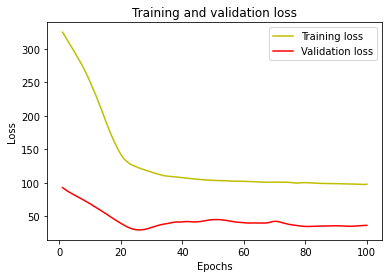


Predicted values are: 
 [[12.447978]
 [10.837619]]

Real values are: 
 21109    40.817
21139    16.716
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 419.6784 - mean_absolute_error: 17.1237

Mean squared error from neural net: 
 419.67840576171875

Mean absolute error from neural net: 
 17.123701095581055

Predicted values are:
  [[0.01127807 0.01133242 0.01132483 0.0112011  0.0112887  0.01131524
  0.01129121 0.01032664 0.01125873 0.01174742 0.01088898 0.01142852
  0.01157502 0.01201972 0.01115229 0.01097877 0.01193391 0.0111932
  0.01136204 0.01163421 0.01076639 0.01128915 0.0111848  0.01167953
  0.01132073 0.01149985 0.01144566 0.01137818 0.01152501 0.01142491
  0.01130612 0.01154592 0.01143768 0.01119254 0.01093061 0.01041566
  0.01127241 0.01120638 0.01122498 0.01079848 0.01078183 0.01051176
  0.01065208 0.01097791 0.01153096 0.01148321 0.01076235 0.01110724
  0.0110902  0.01065185 0.01093072 0.01141356 0.0112673  0.01113235
  0.0110

In [176]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  386.35109000000006

Mean absolute error using decision tree:  14.173

Mean squared error using Random Forest:  318.0916757008996

Mean absolute error Using Random Forest:  15.14646999999999


# Space 303

# 1 month of training data to predict the demand of 1 space for 1 day

In [177]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [178]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [179]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [180]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_166 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 96ms/step - loss: 204.2168 - mean_absolute_error: 8.3831 - val_loss: 291.4875 - val_mean_absolute_error: 10.8027
Epoch 2/100
2/2 [==============================] - 0s 17ms/step - loss: 200.9108 - mean_absolute_error: 8.1708 - val_loss: 286.2603 - val_mean_absolute_error: 10.5633
Epoch 3/100
2/2 [==============================

2/2 [==============================] - 0s 17ms/step - loss: 130.5804 - mean_absolute_error: 6.8857 - val_loss: 232.9056 - val_mean_absolute_error: 13.1391
Epoch 46/100
2/2 [==============================] - 0s 18ms/step - loss: 130.2578 - mean_absolute_error: 6.8896 - val_loss: 233.1638 - val_mean_absolute_error: 13.1691
Epoch 47/100
2/2 [==============================] - 0s 16ms/step - loss: 130.2338 - mean_absolute_error: 6.9148 - val_loss: 233.3500 - val_mean_absolute_error: 13.1942
Epoch 48/100
2/2 [==============================] - 0s 17ms/step - loss: 130.0345 - mean_absolute_error: 6.9289 - val_loss: 232.3636 - val_mean_absolute_error: 13.1588
Epoch 49/100
2/2 [==============================] - 0s 40ms/step - loss: 129.7101 - mean_absolute_error: 6.9281 - val_loss: 229.4103 - val_mean_absolute_error: 13.0196
Epoch 50/100
2/2 [==============================] - 0s 21ms/step - loss: 129.4811 - mean_absolute_error: 6.9094 - val_loss: 226.7251 - val_mean_absolute_error: 12.8904
Epoch

Epoch 94/100
2/2 [==============================] - 0s 18ms/step - loss: 125.4497 - mean_absolute_error: 6.8353 - val_loss: 191.9138 - val_mean_absolute_error: 11.2818
Epoch 95/100
2/2 [==============================] - 0s 17ms/step - loss: 125.4192 - mean_absolute_error: 6.8347 - val_loss: 190.8772 - val_mean_absolute_error: 11.2285
Epoch 96/100
2/2 [==============================] - 0s 17ms/step - loss: 125.4148 - mean_absolute_error: 6.8554 - val_loss: 190.8255 - val_mean_absolute_error: 11.2304
Epoch 97/100
2/2 [==============================] - 0s 18ms/step - loss: 125.2637 - mean_absolute_error: 6.8637 - val_loss: 189.8693 - val_mean_absolute_error: 11.1756
Epoch 98/100
2/2 [==============================] - 0s 17ms/step - loss: 125.2040 - mean_absolute_error: 6.8712 - val_loss: 190.2948 - val_mean_absolute_error: 11.2017
Epoch 99/100
2/2 [==============================] - 0s 18ms/step - loss: 125.0370 - mean_absolute_error: 6.8801 - val_loss: 189.9363 - val_mean_absolute_error: 

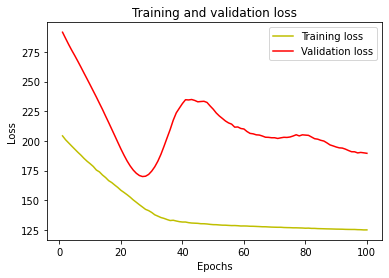


Predicted values are: 
 [[ 6.283215 ]
 [ 5.6204405]
 [10.898129 ]]

Real values are: 
 16285    15.582
16294     4.910
16325    16.395
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 39.0626 - mean_absolute_error: 5.1687

Mean squared error from neural net: 
 39.06257247924805

Mean absolute error from neural net: 
 5.168699264526367

Predicted values are:
  [[0.01519677 0.01505233 0.0149748  0.01518568 0.01290114 0.01435309
  0.01591293 0.01313458 0.01446418 0.01602482 0.01486961 0.01504269
  0.01458094 0.0127717  0.0152286  0.015861   0.01354218 0.01373745
  0.01360368 0.01639962 0.01547868 0.01357856 0.01519704 0.01488312
  0.01354327 0.0133601  0.0163875  0.01421475 0.01292066 0.01332603
  0.01356372 0.01363932 0.01434302 0.01360727 0.01535954 0.01413025
  0.01307777 0.01411619 0.01361798 0.0145989  0.01305627 0.01325217
  0.01373456 0.01407034 0.01456368 0.01477323 0.01536045 0.01409791
  0.01276699 0.01476156 0.01482428 0.01438342 0

In [181]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 46.19374465942383

Mean absolute error from neural net: 
 5.661655902862549

 Mean squared error using Random Forest:  97.00961524166672

Mean absolute error Using Random Forest:  9.839360000000003

# 1 Month to predict 1 week

In [182]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [183]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [184]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [185]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_171 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 94ms/step - loss: 168.7386 - mean_absolute_error: 10.5827 - val_loss: 159.1206 - val_mean_absolute_error: 8.1474
Epoch 2/100
2/2 [==============================] - 0s 17ms/step - loss: 164.2342 - mean_absolute_error: 10.3713 - val_loss: 154.3570 - val_mean_absolute_error: 7.8570
Epoch 3/100
2/2 [==============================

Epoch 46/100
2/2 [==============================] - 0s 21ms/step - loss: 60.2538 - mean_absolute_error: 5.2014 - val_loss: 118.4646 - val_mean_absolute_error: 8.8888
Epoch 47/100
2/2 [==============================] - 0s 19ms/step - loss: 60.0824 - mean_absolute_error: 5.1939 - val_loss: 117.2910 - val_mean_absolute_error: 8.8040
Epoch 48/100
2/2 [==============================] - 0s 19ms/step - loss: 59.9190 - mean_absolute_error: 5.1852 - val_loss: 116.5334 - val_mean_absolute_error: 8.7463
Epoch 49/100
2/2 [==============================] - 0s 18ms/step - loss: 59.8882 - mean_absolute_error: 5.1883 - val_loss: 115.7414 - val_mean_absolute_error: 8.6856
Epoch 50/100
2/2 [==============================] - 0s 20ms/step - loss: 59.6252 - mean_absolute_error: 5.1804 - val_loss: 115.1972 - val_mean_absolute_error: 8.6456
Epoch 51/100
2/2 [==============================] - 0s 17ms/step - loss: 59.5258 - mean_absolute_error: 5.1789 - val_loss: 114.8014 - val_mean_absolute_error: 8.6151
Epoc

2/2 [==============================] - 0s 16ms/step - loss: 56.1879 - mean_absolute_error: 5.0441 - val_loss: 105.6427 - val_mean_absolute_error: 8.1368
Epoch 96/100
2/2 [==============================] - 0s 17ms/step - loss: 56.1126 - mean_absolute_error: 5.0424 - val_loss: 105.4121 - val_mean_absolute_error: 8.1179
Epoch 97/100
2/2 [==============================] - 0s 18ms/step - loss: 56.1180 - mean_absolute_error: 5.0413 - val_loss: 105.2493 - val_mean_absolute_error: 8.1056
Epoch 98/100
2/2 [==============================] - 0s 16ms/step - loss: 56.0372 - mean_absolute_error: 5.0350 - val_loss: 105.2020 - val_mean_absolute_error: 8.1046
Epoch 99/100
2/2 [==============================] - 0s 20ms/step - loss: 55.9846 - mean_absolute_error: 5.0315 - val_loss: 104.9613 - val_mean_absolute_error: 8.0844
Epoch 100/100
2/2 [==============================] - 0s 18ms/step - loss: 55.9961 - mean_absolute_error: 5.0319 - val_loss: 104.7218 - val_mean_absolute_error: 8.0657


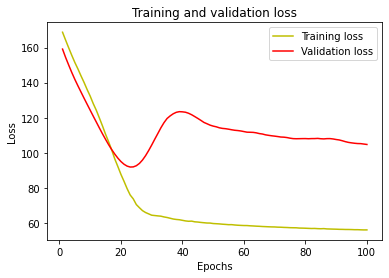


Predicted values are: 
 [[12.818356]
 [12.569463]
 [12.387238]
 [12.18298 ]
 [16.06657 ]]

Real values are: 
 3892     2.300
3904     4.083
3907    10.381
3919     5.213
3932     5.924
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 48.8484 - mean_absolute_error: 6.0707

Mean squared error from neural net: 
 48.848426818847656

Mean absolute error from neural net: 
 6.070705890655518

Predicted values are:
  [[0.01404662 0.01386423 0.0139231  0.0152826  0.01282259 0.01531168
  0.01568874 0.01354601 0.01139193 0.01467888 0.01431766 0.01390638
  0.01400272 0.01383117 0.01447071 0.01518271 0.01428691 0.01635811
  0.01423003 0.01594583 0.01378995 0.01377749 0.01194264 0.01240157
  0.01485193 0.01310876 0.01386247 0.01437859 0.01273339 0.0142247
  0.01254805 0.01305109 0.01362482 0.01463464 0.0152158  0.01332867
  0.01394042 0.01292978 0.01518946 0.01371164 0.01399055 0.01448051
  0.01326046 0.01537133 0.01370311 0.01440935 0.01520449 0.013401

In [186]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 46.877540588378906

Mean absolute error from neural net: 
 5.940613269805908

 Mean squared error using Random Forest:  77.77993093784437

Mean absolute error Using Random Forest:  6.946025555555554

# 6 Month training 1 week predicition

In [187]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [188]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [189]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [190]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_176 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 13ms/step - loss: 207.2909 - mean_absolute_error: 9.3456 - val_loss: 118.6003 - val_mean_absolute_error: 7.7674
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 194.9929 - mean_absolute_error: 8.6933 - val_loss: 102.1847 - val_mean_absolute_error: 6.8902
Epoch 3/100
9/9 [==============================] -

9/9 [==============================] - 0s 3ms/step - loss: 114.6481 - mean_absolute_error: 7.0124 - val_loss: 67.2952 - val_mean_absolute_error: 5.6938
Epoch 47/100
9/9 [==============================] - 0s 3ms/step - loss: 114.5284 - mean_absolute_error: 6.9795 - val_loss: 67.6395 - val_mean_absolute_error: 5.7246
Epoch 48/100
9/9 [==============================] - 0s 3ms/step - loss: 114.3888 - mean_absolute_error: 6.9306 - val_loss: 65.9521 - val_mean_absolute_error: 5.5770
Epoch 49/100
9/9 [==============================] - 0s 3ms/step - loss: 114.5167 - mean_absolute_error: 6.9407 - val_loss: 66.5606 - val_mean_absolute_error: 5.6228
Epoch 50/100
9/9 [==============================] - 0s 3ms/step - loss: 114.2749 - mean_absolute_error: 6.9742 - val_loss: 65.9069 - val_mean_absolute_error: 5.5562
Epoch 51/100
9/9 [==============================] - 0s 3ms/step - loss: 114.4656 - mean_absolute_error: 7.0215 - val_loss: 64.7067 - val_mean_absolute_error: 5.4209
Epoch 52/100
9/9 [=====

Epoch 96/100
9/9 [==============================] - 0s 3ms/step - loss: 112.2212 - mean_absolute_error: 7.0555 - val_loss: 62.4354 - val_mean_absolute_error: 5.2562
Epoch 97/100
9/9 [==============================] - 0s 3ms/step - loss: 112.1225 - mean_absolute_error: 6.8791 - val_loss: 63.7033 - val_mean_absolute_error: 5.4033
Epoch 98/100
9/9 [==============================] - 0s 3ms/step - loss: 112.2614 - mean_absolute_error: 6.8167 - val_loss: 62.4711 - val_mean_absolute_error: 5.2691
Epoch 99/100
9/9 [==============================] - 0s 3ms/step - loss: 112.0928 - mean_absolute_error: 6.9055 - val_loss: 63.4117 - val_mean_absolute_error: 5.3556
Epoch 100/100
9/9 [==============================] - 0s 3ms/step - loss: 112.1787 - mean_absolute_error: 7.0518 - val_loss: 62.6178 - val_mean_absolute_error: 5.2725


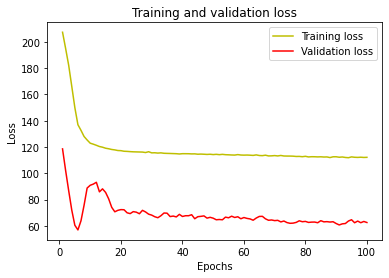


Predicted values are: 
 [[9.047248]
 [6.610787]
 [4.859657]
 [3.874998]
 [5.790896]]

Real values are: 
 21061     4.683
21086    11.929
21123     1.908
21151     6.102
21155    14.305
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 65.1774 - mean_absolute_error: 5.6627

Mean squared error from neural net: 
 65.17741394042969

Mean absolute error from neural net: 
 5.662673473358154

Predicted values are:
  [[0.0031764  0.00284714 0.00280112 ... 0.00272668 0.00297234 0.0032026 ]
 [0.00311545 0.00287577 0.00284853 ... 0.00277993 0.00296185 0.00314996]
 [0.00302964 0.00292443 0.00290438 ... 0.00287511 0.00296525 0.00304138]
 [0.00297663 0.00295413 0.0029354  ... 0.00291748 0.00295632 0.00300688]
 [0.0029614  0.0029605  0.00296182 ... 0.00295085 0.00295891 0.00296696]]

Real values are: 
 21061     4.683
21086    11.929
21123     1.908
21151     6.102
21155    14.305
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0

In [191]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 56.471195220947266

Mean absolute error from neural net: 
 5.392200469970703

Mean squared error using decision tree:  63.436427124999994

Mean absolute error using decision tree:  5.284375000000001


# Space CA-500

# 1 month of training data to predict the demand of 1 space for 1 day

In [192]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [193]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [194]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [195]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_181 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 358ms/step - loss: 102.2374 - mean_absolute_error: 7.9667 - val_loss: 62.6980 - val_mean_absolute_error: 6.0370
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 101.2167 - mean_absolute_error: 7.9087 - val_loss: 61.4385 - val_mean_absolute_error: 5.9265
Epoch 3/100
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step - loss: 42.6797 - mean_absolute_error: 5.4049 - val_loss: 44.5995 - val_mean_absolute_error: 6.1302
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 41.2102 - mean_absolute_error: 5.3716 - val_loss: 48.7873 - val_mean_absolute_error: 6.3085
Epoch 48/100
1/1 [==============================] - 0s 16ms/step - loss: 39.8050 - mean_absolute_error: 5.3372 - val_loss: 53.5454 - val_mean_absolute_error: 6.4916
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 38.4722 - mean_absolute_error: 5.3015 - val_loss: 58.9055 - val_mean_absolute_error: 6.6787
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 37.2102 - mean_absolute_error: 5.2642 - val_loss: 64.9087 - val_mean_absolute_error: 6.8710
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 36.0256 - mean_absolute_error: 5.2253 - val_loss: 71.5796 - val_mean_absolute_error: 7.0681
Epoch 52/100
1/1 [=====

1/1 [==============================] - 0s 16ms/step - loss: 22.7783 - mean_absolute_error: 4.1591 - val_loss: 440.0421 - val_mean_absolute_error: 19.7738
Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 22.6867 - mean_absolute_error: 4.1518 - val_loss: 438.5649 - val_mean_absolute_error: 19.7272
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 22.5915 - mean_absolute_error: 4.1440 - val_loss: 436.9467 - val_mean_absolute_error: 19.6771
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 22.4933 - mean_absolute_error: 4.1358 - val_loss: 435.1548 - val_mean_absolute_error: 19.6226
Epoch 99/100
1/1 [==============================] - 0s 47ms/step - loss: 22.3932 - mean_absolute_error: 4.1273 - val_loss: 433.2083 - val_mean_absolute_error: 19.5641
Epoch 100/100
1/1 [==============================] - 0s 25ms/step - loss: 22.2921 - mean_absolute_error: 4.1186 - val_loss: 431.0819 - val_mean_absolute_error: 19.5008


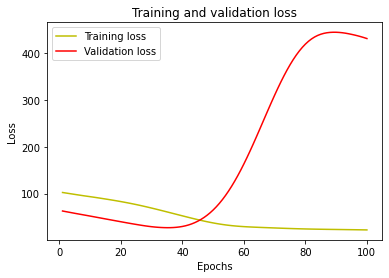


Predicted values are: 
 [[4.176212]]

Real values are: 
 16317    11.416
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 52.4145 - mean_absolute_error: 7.2398

Mean squared error from neural net: 
 52.4145393371582

Mean absolute error from neural net: 
 7.23978853225708

Predicted values are:
  [[0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
  0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
  0.07692308]]

Real values are: 
 16317    11.416
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 153ms/step - loss: 128.5747 - mean_absolute_error: 11.3391

Mean squared error from Convolutional neural net:  128.5746612548828

Mean absolute error from Convolutional neural net:  11.33907699584961

Mean squared error from linear regression:  14.204201329055056

Mean absolute error from linear regression:  3.768846153540239

Mean squared error using decision tree:  33.48936900000001

Me

In [196]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  14.204201329055056

Mean absolute error from linear regression:  3.768846153540239

Mean squared error using Random Forest:  16.960477256099956

Mean absolute error Using Random Forest:  4.118309999999995


# 1 Month to predict 1 week

In [197]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [198]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [199]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [200]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_186 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 357ms/step - loss: 111.1282 - mean_absolute_error: 9.1978 - val_loss: 195.1570 - val_mean_absolute_error: 12.0442
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 109.3082 - mean_absolute_error: 9.0947 - val_loss: 191.6523 - val_mean_absolute_error: 11.8909
Epoch 3/100
1/1 [=============================

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 45.4796 - mean_absolute_error: 5.3783 - val_loss: 63.9714 - val_mean_absolute_error: 7.4746
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 44.8222 - mean_absolute_error: 5.3315 - val_loss: 63.8474 - val_mean_absolute_error: 7.5957
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 44.1975 - mean_absolute_error: 5.2817 - val_loss: 64.0540 - val_mean_absolute_error: 7.7171
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 43.5982 - mean_absolute_error: 5.2290 - val_loss: 64.5835 - val_mean_absolute_error: 7.8381
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 43.0126 - mean_absolute_error: 5.1733 - val_loss: 65.4382 - val_mean_absolute_error: 7.9588
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 42.4373 - mean_absolute_error: 5.1148 - val_loss: 66.6033 - val_mean_absolute_error: 8.0785
Epoch 52/1

1/1 [==============================] - 0s 17ms/step - loss: 30.8220 - mean_absolute_error: 4.2340 - val_loss: 87.7447 - val_mean_absolute_error: 9.1596
Epoch 96/100
1/1 [==============================] - 0s 19ms/step - loss: 30.6874 - mean_absolute_error: 4.2183 - val_loss: 87.0678 - val_mean_absolute_error: 9.1408
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 30.5541 - mean_absolute_error: 4.2025 - val_loss: 86.4425 - val_mean_absolute_error: 9.1230
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 30.4232 - mean_absolute_error: 4.1869 - val_loss: 85.8691 - val_mean_absolute_error: 9.1063
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 30.2932 - mean_absolute_error: 4.1711 - val_loss: 85.3481 - val_mean_absolute_error: 9.0910
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 30.1647 - mean_absolute_error: 4.1553 - val_loss: 84.8700 - val_mean_absolute_error: 9.0766


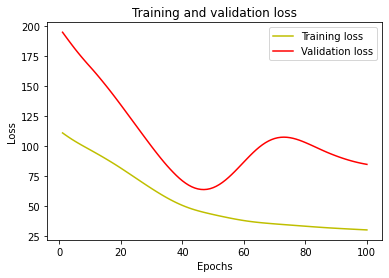


Predicted values are: 
 [[13.70031  ]
 [ 9.557564 ]
 [ 4.2170515]
 [ 9.399917 ]
 [16.294085 ]]

Real values are: 
 4041    9.723
4054    5.410
4117    7.793
4190    7.465
4247    5.980
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 31.1866 - mean_absolute_error: 4.7900

Mean squared error from neural net: 
 31.186588287353516

Mean absolute error from neural net: 
 4.78996467590332

Predicted values are:
  [[0.03968392 0.04284757 0.03633323 0.04007277 0.03917549 0.04176511
  0.0380909  0.03909995 0.03868645 0.04158126 0.03636643 0.03793374
  0.03873807 0.04236118 0.03788091 0.04071179 0.04073708 0.04403091
  0.04565333 0.03951126 0.04136921 0.04717859 0.03469639 0.03817473
  0.03731984]
 [0.03945961 0.04240274 0.03719675 0.0394285  0.03895196 0.04157283
  0.03918235 0.03936357 0.03897765 0.04111655 0.03711646 0.03818998
  0.03903995 0.04189355 0.03834639 0.04075093 0.04062144 0.04349306
  0.04421911 0.03981004 0.04129525 0.0454745  0.035

In [201]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  12.604990430210952

Mean absolute error from linear regression:  3.255140440702533

Mean squared error using Random Forest:  12.571779641319988

Mean absolute error Using Random Forest:  3.0359519999999995


# 6 Month training 1 week predicition

In [202]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [203]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [204]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [205]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_191 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 50ms/step - loss: 121.6275 - mean_absolute_error: 8.5638 - val_loss: 93.2094 - val_mean_absolute_error: 8.1975
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 116.9987 - mean_absolute_error: 8.2814 - val_loss: 87.0050 - val_mean_absolute_error: 7.8143
Epoch 3/100
3/3 [==============================] - 

3/3 [==============================] - 0s 9ms/step - loss: 43.0746 - mean_absolute_error: 5.0649 - val_loss: 65.0237 - val_mean_absolute_error: 6.8910
Epoch 47/100
3/3 [==============================] - 0s 9ms/step - loss: 42.8695 - mean_absolute_error: 5.0709 - val_loss: 65.8294 - val_mean_absolute_error: 6.9422
Epoch 48/100
3/3 [==============================] - 0s 9ms/step - loss: 42.8074 - mean_absolute_error: 5.0680 - val_loss: 64.9237 - val_mean_absolute_error: 6.8754
Epoch 49/100
3/3 [==============================] - 0s 9ms/step - loss: 42.6606 - mean_absolute_error: 5.0538 - val_loss: 63.4792 - val_mean_absolute_error: 6.7667
Epoch 50/100
3/3 [==============================] - 0s 9ms/step - loss: 42.6560 - mean_absolute_error: 5.0435 - val_loss: 61.9673 - val_mean_absolute_error: 6.6523
Epoch 51/100
3/3 [==============================] - 0s 9ms/step - loss: 42.4399 - mean_absolute_error: 5.0256 - val_loss: 60.6948 - val_mean_absolute_error: 6.5547
Epoch 52/100
3/3 [===========

Epoch 96/100
3/3 [==============================] - 0s 9ms/step - loss: 39.6457 - mean_absolute_error: 4.7222 - val_loss: 41.7468 - val_mean_absolute_error: 5.2285
Epoch 97/100
3/3 [==============================] - 0s 9ms/step - loss: 39.6622 - mean_absolute_error: 4.7090 - val_loss: 40.4138 - val_mean_absolute_error: 5.1210
Epoch 98/100
3/3 [==============================] - 0s 8ms/step - loss: 39.6710 - mean_absolute_error: 4.7024 - val_loss: 39.5581 - val_mean_absolute_error: 5.0468
Epoch 99/100
3/3 [==============================] - 0s 9ms/step - loss: 39.6200 - mean_absolute_error: 4.6926 - val_loss: 39.5714 - val_mean_absolute_error: 5.0472
Epoch 100/100
3/3 [==============================] - 0s 9ms/step - loss: 39.5259 - mean_absolute_error: 4.6873 - val_loss: 40.0505 - val_mean_absolute_error: 5.0889


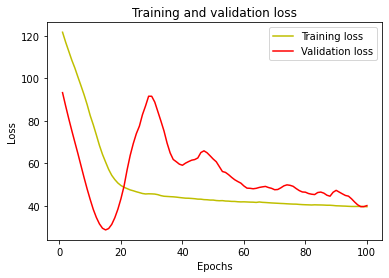


Predicted values are: 
 [[3.680176]]

Real values are: 
 21073    3.409
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 0.0735 - mean_absolute_error: 0.2712

Mean squared error from neural net: 
 0.0735364779829979

Mean absolute error from neural net: 
 0.2711760997772217

Predicted values are:
  [[0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.0112

In [206]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 0.032105010002851486

Mean absolute error from neural net: 
 0.17917871475219727

 Mean squared error using Random Forest:  5.182679902499998

Mean absolute error Using Random Forest:  2.2765499999999994

# Space CA-506

# 1 month of training data to predict the demand of 1 space for 1 day

In [207]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [208]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [209]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [210]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_196 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_197 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 624ms/step - loss: 128.4743 - mean_absolute_error: 11.3325 - val_loss: 36.3598 - val_mean_absolute_error: 6.0299
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 125.2476 - mean_absolute_error: 11.1899 - val_loss: 35.6053 - val_mean_absolute_error: 5.9670
Epoch 3/100
1/1 [==============================]

1/1 [==============================] - 0s 17ms/step - loss: 24.6443 - mean_absolute_error: 4.5801 - val_loss: 8.1433 - val_mean_absolute_error: 2.8537
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 22.8195 - mean_absolute_error: 4.3519 - val_loss: 7.4720 - val_mean_absolute_error: 2.7335
Epoch 48/100
1/1 [==============================] - 0s 16ms/step - loss: 21.0838 - mean_absolute_error: 4.1226 - val_loss: 6.8080 - val_mean_absolute_error: 2.6092
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 19.4406 - mean_absolute_error: 3.8929 - val_loss: 6.1617 - val_mean_absolute_error: 2.4823
Epoch 50/100
1/1 [==============================] - 0s 18ms/step - loss: 17.8921 - mean_absolute_error: 3.6637 - val_loss: 5.5321 - val_mean_absolute_error: 2.3520
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 16.4392 - mean_absolute_error: 3.4355 - val_loss: 4.9261 - val_mean_absolute_error: 2.2195
Epoch 52/100
1/1 [===========

1/1 [==============================] - 0s 17ms/step - loss: 0.1918 - mean_absolute_error: 0.4104 - val_loss: 3.3375 - val_mean_absolute_error: 1.8269
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1786 - mean_absolute_error: 0.3976 - val_loss: 3.2728 - val_mean_absolute_error: 1.8091
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1632 - mean_absolute_error: 0.3813 - val_loss: 3.2017 - val_mean_absolute_error: 1.7893
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1463 - mean_absolute_error: 0.3621 - val_loss: 3.1257 - val_mean_absolute_error: 1.7680
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1287 - mean_absolute_error: 0.3404 - val_loss: 3.0466 - val_mean_absolute_error: 1.7454


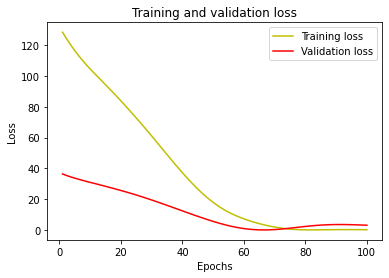


Predicted values are: 
 [[2.2028313]]

Real values are: 
 16308    10.514
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 69.0755 - mean_absolute_error: 8.3112

Mean squared error from neural net: 
 69.07552337646484

Mean absolute error from neural net: 
 8.311168670654297

Predicted values are:
  [[0.33333334 0.33333334 0.33333334]]

Real values are: 
 16308    10.514
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 150ms/step - loss: 103.6460 - mean_absolute_error: 10.1807

Mean squared error from Convolutional neural net:  103.6459732055664

Mean absolute error from Convolutional neural net:  10.18066692352295

Mean squared error from linear regression:  1.1427609999996637

Mean absolute error from linear regression:  1.0689999999998427

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.436128

In [211]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  1.1427609999996637

Mean absolute error from linear regression:  1.0689999999998427

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281600000201

Mean absolute error Using Random Forest:  0.6604000000000152

# 1 Month to predict 1 week

In [212]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 5]

In [213]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 6]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [214]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [215]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_201 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 341ms/step - loss: 41.7747 - mean_absolute_error: 5.5386 - val_loss: 121.8849 - val_mean_absolute_error: 10.5582
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 40.8838 - mean_absolute_error: 5.4613 - val_loss: 121.1387 - val_mean_absolute_error: 10.5203
Epoch 3/100
1/1 [==============================]

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 9.0591 - mean_absolute_error: 2.7028 - val_loss: 90.0510 - val_mean_absolute_error: 8.9834
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 8.9272 - mean_absolute_error: 2.6623 - val_loss: 89.6490 - val_mean_absolute_error: 8.9659
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 8.7958 - mean_absolute_error: 2.6207 - val_loss: 89.2560 - val_mean_absolute_error: 8.9488
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 8.6635 - mean_absolute_error: 2.5788 - val_loss: 88.8733 - val_mean_absolute_error: 8.9324
Epoch 50/100
1/1 [==============================] - 0s 16ms/step - loss: 8.5368 - mean_absolute_error: 2.5380 - val_loss: 88.4887 - val_mean_absolute_error: 8.9162
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 8.4072 - mean_absolute_error: 2.4979 - val_loss: 88.0720 - val_mean_absolute_error: 8.8983
Epoch 52/100
1/1

Epoch 96/100
1/1 [==============================] - 0s 43ms/step - loss: 4.6339 - mean_absolute_error: 1.8790 - val_loss: 65.8715 - val_mean_absolute_error: 7.7223
Epoch 97/100
1/1 [==============================] - 0s 21ms/step - loss: 4.6032 - mean_absolute_error: 1.8706 - val_loss: 65.4814 - val_mean_absolute_error: 7.6990
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 4.5748 - mean_absolute_error: 1.8625 - val_loss: 65.1114 - val_mean_absolute_error: 7.6770
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 4.5460 - mean_absolute_error: 1.8539 - val_loss: 64.7753 - val_mean_absolute_error: 7.6573
Epoch 100/100
1/1 [==============================] - 0s 16ms/step - loss: 4.5192 - mean_absolute_error: 1.8453 - val_loss: 64.4585 - val_mean_absolute_error: 7.6392


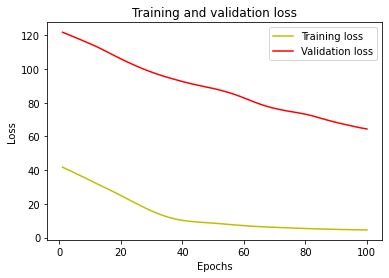


Predicted values are: 
 [[15.481275 ]
 [ 2.9757166]
 [ 1.8717543]
 [ 2.0035214]]

Real values are: 
 2081    2.726
2210    8.532
2279    8.096
2304    4.419
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 59.5363 - mean_absolute_error: 6.7378

Mean squared error from neural net: 
 59.53627395629883

Mean absolute error from neural net: 
 6.737820625305176

Predicted values are:
  [[0.12443395 0.14487223 0.11927293 0.1505136  0.16263957 0.1447617
  0.15350609]
 [0.14155613 0.14223081 0.13937308 0.14406389 0.1431972  0.14254516
  0.14703375]
 [0.14189956 0.14289221 0.13341115 0.15183069 0.14501117 0.13746053
  0.1474947 ]
 [0.14186412 0.14264677 0.13261323 0.1543502  0.14478676 0.13699183
  0.14674708]]

Real values are: 
 2081    2.726
2210    8.532
2279    8.096
2304    4.419
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 153ms/step - loss: 39.6471 - mean_absolute_error: 5.8004

Mean squared error from Convol

In [216]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  35.37149025

Mean absolute error using decision tree:  5.46175

Mean squared error using Random Forest:  19.23394901477499

Mean absolute error Using Random Forest:  3.589812499999998

# 6 Month training 1 week predicition

In [217]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([5,6,7,8,9,10])]

In [218]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 12]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [219]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [220]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_205 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_206 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 358ms/step - loss: 42.8028 - mean_absolute_error: 6.1353 - val_loss: 15.2841 - val_mean_absolute_error: 3.9056
Epoch 2/100
1/1 [==============================] - 0s 29ms/step - loss: 41.7441 - mean_absolute_error: 6.0494 - val_loss: 14.9033 - val_mean_absolute_error: 3.8572
Epoch 3/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step - loss: 6.0210 - mean_absolute_error: 2.1868 - val_loss: 5.0694 - val_mean_absolute_error: 2.1970
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 6.0606 - mean_absolute_error: 2.1993 - val_loss: 5.0235 - val_mean_absolute_error: 2.1848
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 6.1148 - mean_absolute_error: 2.2088 - val_loss: 4.9842 - val_mean_absolute_error: 2.1743
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 6.1681 - mean_absolute_error: 2.2150 - val_loss: 4.9534 - val_mean_absolute_error: 2.1661
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 6.2159 - mean_absolute_error: 2.2186 - val_loss: 4.9317 - val_mean_absolute_error: 2.1602
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 6.2467 - mean_absolute_error: 2.2193 - val_loss: 4.9185 - val_mean_absolute_error: 2.1565
Epoch 52/100
1/1 [=================

1/1 [==============================] - 0s 17ms/step - loss: 4.3378 - mean_absolute_error: 1.7773 - val_loss: 5.5846 - val_mean_absolute_error: 2.2992
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 4.3108 - mean_absolute_error: 1.7707 - val_loss: 5.5927 - val_mean_absolute_error: 2.3002
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 4.2832 - mean_absolute_error: 1.7639 - val_loss: 5.6021 - val_mean_absolute_error: 2.3015
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 4.2555 - mean_absolute_error: 1.7569 - val_loss: 5.6123 - val_mean_absolute_error: 2.3030
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 4.2273 - mean_absolute_error: 1.7497 - val_loss: 5.6240 - val_mean_absolute_error: 2.3050


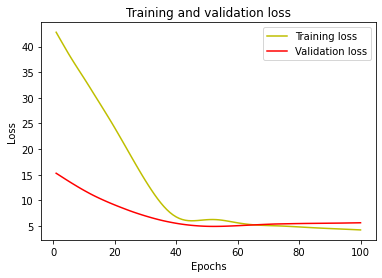


Predicted values are: 
 [[1.4471143]]

Real values are: 
 25279    6.238
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 22.9526 - mean_absolute_error: 4.7909

Mean squared error from neural net: 
 22.95258331298828

Mean absolute error from neural net: 
 4.7908854484558105

Predicted values are:
  [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]

Real values are: 
 25279    6.238
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 148ms/step - loss: 36.8611 - mean_absolute_error: 6.0713

Mean squared error from Convolutional neural net:  36.861087799072266

Mean absolute error from Convolutional neural net:  6.071333408355713

Mean squared error from linear regression:  0.6408002499528751

Mean absolute error from linear regression:  0.8004999999705653

Mean squared error using decision tree:  1.8577690000000011

Mean absolute error using decision tree:  1.3630000000000004

Mean squared error

In [221]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  0.6408002499528751

Mean absolute error from linear regression:  0.8004999999705653

Mean squared error using decision tree:  1.8577690000000011

Mean absolute error using decision tree:  1.3630000000000004

Mean squared error using Random Forest:  2.1081007249000074

Mean absolute error Using Random Forest:  1.4519300000000026

# Space 513

# 1 month of training data to predict the demand of 1 space for 1 day

In [222]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [223]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'] == 1]

In [224]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [225]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_211 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_212 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 340ms/step - loss: 105.3629 - mean_absolute_error: 9.1768 - val_loss: 81.1287 - val_mean_absolute_error: 8.3082
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 103.7599 - mean_absolute_error: 9.0840 - val_loss: 79.2880 - val_mean_absolute_error: 8.1988
Epoch 3/100
1/1 [==============================] -

1/1 [==============================] - 0s 17ms/step - loss: 42.2677 - mean_absolute_error: 5.3966 - val_loss: 10.8795 - val_mean_absolute_error: 2.9476
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 41.4576 - mean_absolute_error: 5.3109 - val_loss: 11.4488 - val_mean_absolute_error: 2.9206
Epoch 48/100
1/1 [==============================] - 0s 19ms/step - loss: 40.6313 - mean_absolute_error: 5.2228 - val_loss: 12.3704 - val_mean_absolute_error: 2.8936
Epoch 49/100
1/1 [==============================] - 0s 18ms/step - loss: 39.7884 - mean_absolute_error: 5.1323 - val_loss: 13.6557 - val_mean_absolute_error: 2.8657
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 38.9310 - mean_absolute_error: 5.0702 - val_loss: 15.3318 - val_mean_absolute_error: 2.9622
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 38.0731 - mean_absolute_error: 5.0308 - val_loss: 17.4243 - val_mean_absolute_error: 3.1218
Epoch 52/100
1/1 [=====

1/1 [==============================] - 0s 18ms/step - loss: 24.1223 - mean_absolute_error: 4.0593 - val_loss: 322.5547 - val_mean_absolute_error: 17.3150
Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 23.9873 - mean_absolute_error: 4.0345 - val_loss: 326.0309 - val_mean_absolute_error: 17.4248
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 23.8584 - mean_absolute_error: 4.0104 - val_loss: 329.5658 - val_mean_absolute_error: 17.5351
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 23.7307 - mean_absolute_error: 3.9870 - val_loss: 333.1601 - val_mean_absolute_error: 17.6461
Epoch 99/100
1/1 [==============================] - 0s 18ms/step - loss: 23.6072 - mean_absolute_error: 3.9643 - val_loss: 336.8325 - val_mean_absolute_error: 17.7582
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 23.4827 - mean_absolute_error: 3.9419 - val_loss: 340.5187 - val_mean_absolute_error: 17.8698


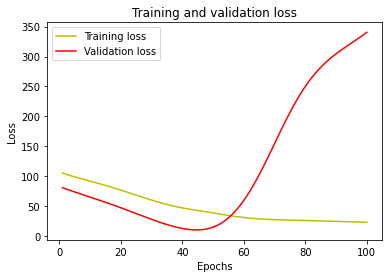


Predicted values are: 
 [[4.4145336]]

Real values are: 
 10736    6.491
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 4.3117 - mean_absolute_error: 2.0765

Mean squared error from neural net: 
 4.311713218688965

Mean absolute error from neural net: 
 2.0764665603637695

Predicted values are:
  [[0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
  0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
  0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
  0.04761905 0.04761905 0.04761905]]

Real values are: 
 10736    6.491
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 152ms/step - loss: 41.5172 - mean_absolute_error: 6.4434

Mean squared error from Convolutional neural net:  41.51716232299805

Mean absolute error from Convolutional neural net:  6.443381309509277

Mean squared error from linear regression:  7.335069444498013

Mean absolute error from linear regres

In [226]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 3.1444361209869385

Mean absolute error from neural net: 
 1.7732558250427246

 Mean squared error from linear regression:  7.335069444498013

Mean absolute error from linear regression:  2.708333333343223

# 1 Month to predict 1 week

In [227]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_year'] == 2018]

In [228]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 6]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [229]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [230]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_216 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_217 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 340ms/step - loss: 127.6559 - mean_absolute_error: 10.7786 - val_loss: 56.3848 - val_mean_absolute_error: 6.5086
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 126.1321 - mean_absolute_error: 10.7111 - val_loss: 55.6128 - val_mean_absolute_error: 6.4476
Epoch 3/100
1/1 [==============================]

Epoch 46/100
1/1 [==============================] - 0s 16ms/step - loss: 28.5866 - mean_absolute_error: 4.3863 - val_loss: 34.6269 - val_mean_absolute_error: 4.6696
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 26.4686 - mean_absolute_error: 4.1792 - val_loss: 34.3984 - val_mean_absolute_error: 4.6589
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 24.5168 - mean_absolute_error: 3.9694 - val_loss: 34.1919 - val_mean_absolute_error: 4.6500
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 22.7409 - mean_absolute_error: 3.7577 - val_loss: 34.0070 - val_mean_absolute_error: 4.6441
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 21.1524 - mean_absolute_error: 3.5450 - val_loss: 33.8601 - val_mean_absolute_error: 4.6402
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 19.7597 - mean_absolute_error: 3.3436 - val_loss: 33.7428 - val_mean_absolute_error: 4.6377
Epoch 52/1

Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 12.3063 - mean_absolute_error: 2.6093 - val_loss: 26.7513 - val_mean_absolute_error: 4.0173
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 12.2246 - mean_absolute_error: 2.6059 - val_loss: 26.6761 - val_mean_absolute_error: 4.0066
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 12.1435 - mean_absolute_error: 2.6028 - val_loss: 26.6170 - val_mean_absolute_error: 3.9965
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 12.0632 - mean_absolute_error: 2.6000 - val_loss: 26.5694 - val_mean_absolute_error: 3.9867
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 11.9845 - mean_absolute_error: 2.5977 - val_loss: 26.5277 - val_mean_absolute_error: 3.9773


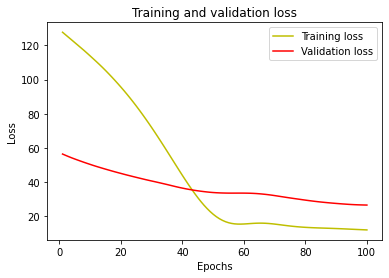


Predicted values are: 
 [[18.894064 ]
 [13.704505 ]
 [ 6.937174 ]
 [ 6.2657466]
 [ 2.8750973]]

Real values are: 
 2114     9.910
2149    13.516
2185     3.923
2190     1.895
2282    12.412
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 35.5141 - mean_absolute_error: 4.9545

Mean squared error from neural net: 
 35.51411819458008

Mean absolute error from neural net: 
 4.954472064971924

Predicted values are:
  [[0.0700583  0.06235605 0.07258727 0.07424613 0.06456416 0.06468641
  0.06654821 0.06548186 0.04991677 0.05815069 0.05526616 0.06013846
  0.05238773 0.06362273 0.06397142 0.05601773]
 [0.06509371 0.06285102 0.06844557 0.06994607 0.06476565 0.06430293
  0.0644273  0.06283152 0.05577372 0.0595725  0.05907113 0.06144892
  0.05621591 0.06242995 0.06478531 0.05803879]
 [0.0631357  0.06270867 0.06560932 0.06386667 0.06339122 0.06533274
  0.06423122 0.06284074 0.05957648 0.06076999 0.06243423 0.06273528
  0.05862526 0.06043443 0.06273174

In [231]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  24.543271833333336

Mean absolute error using decision tree:  3.8541666666666665

Mean squared error using Random Forest:  15.096384583916661

Mean absolute error Using Random Forest:  3.297375000000001


# 6 Month training 1 week predicition

In [232]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([4,5,6,7,8,9])]

In [233]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [234]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [235]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_220 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_221 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 1s 101ms/step - loss: 120.2261 - mean_absolute_error: 9.2931 - val_loss: 99.6819 - val_mean_absolute_error: 9.3628
Epoch 2/100
2/2 [==============================] - 0s 21ms/step - loss: 116.3825 - mean_absolute_error: 9.0986 - val_loss: 95.1263 - val_mean_absolute_error: 9.1141
Epoch 3/100
2/2 [==============================] -

2/2 [==============================] - 0s 19ms/step - loss: 28.0595 - mean_absolute_error: 4.2062 - val_loss: 29.7771 - val_mean_absolute_error: 4.5229
Epoch 47/100
2/2 [==============================] - 0s 16ms/step - loss: 28.0564 - mean_absolute_error: 4.2037 - val_loss: 29.0130 - val_mean_absolute_error: 4.4653
Epoch 48/100
2/2 [==============================] - 0s 17ms/step - loss: 27.9866 - mean_absolute_error: 4.1991 - val_loss: 28.8026 - val_mean_absolute_error: 4.4490
Epoch 49/100
2/2 [==============================] - 0s 16ms/step - loss: 27.9343 - mean_absolute_error: 4.1935 - val_loss: 28.4441 - val_mean_absolute_error: 4.4215
Epoch 50/100
2/2 [==============================] - 0s 18ms/step - loss: 27.8758 - mean_absolute_error: 4.1917 - val_loss: 28.3707 - val_mean_absolute_error: 4.4160
Epoch 51/100
2/2 [==============================] - 0s 17ms/step - loss: 27.8341 - mean_absolute_error: 4.1921 - val_loss: 28.5345 - val_mean_absolute_error: 4.4288
Epoch 52/100
2/2 [=====

Epoch 96/100
2/2 [==============================] - 0s 49ms/step - loss: 26.7102 - mean_absolute_error: 4.1416 - val_loss: 34.8556 - val_mean_absolute_error: 4.8968
Epoch 97/100
2/2 [==============================] - 0s 20ms/step - loss: 26.7211 - mean_absolute_error: 4.1403 - val_loss: 34.5167 - val_mean_absolute_error: 4.8750
Epoch 98/100
2/2 [==============================] - 0s 17ms/step - loss: 26.6654 - mean_absolute_error: 4.1388 - val_loss: 34.6763 - val_mean_absolute_error: 4.8856
Epoch 99/100
2/2 [==============================] - 0s 17ms/step - loss: 26.6702 - mean_absolute_error: 4.1366 - val_loss: 34.9512 - val_mean_absolute_error: 4.9042
Epoch 100/100
2/2 [==============================] - 0s 17ms/step - loss: 26.6439 - mean_absolute_error: 4.1344 - val_loss: 34.6338 - val_mean_absolute_error: 4.8832


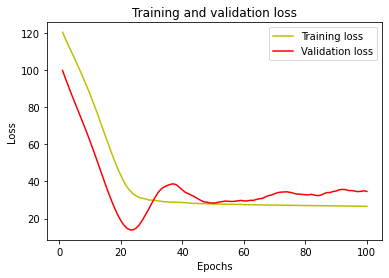


Predicted values are: 
 [[11.133329 ]
 [ 6.387913 ]
 [ 2.5823853]
 [ 6.5626025]
 [10.752409 ]]

Real values are: 
 10736    6.491
10841    6.660
10929    5.551
11021    8.390
11046    6.108
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 10.5219 - mean_absolute_error: 2.8575

Mean squared error from neural net: 
 10.52193546295166

Mean absolute error from neural net: 
 2.8574628829956055

Predicted values are:
  [[0.01362747 0.02015876 0.01655095 0.01639717 0.01503193 0.01494958
  0.01457869 0.01672548 0.01560616 0.01436166 0.01398376 0.01689684
  0.01419565 0.01351233 0.01701719 0.01609343 0.01489726 0.01502795
  0.01655001 0.01734146 0.01423585 0.01781138 0.0126225  0.01693368
  0.01608724 0.01558853 0.01411235 0.01646432 0.01458078 0.01632326
  0.01586364 0.01419407 0.01664364 0.01650051 0.01531084 0.01509717
  0.01529027 0.01466954 0.01190592 0.01666188 0.01636719 0.01458119
  0.01365347 0.01424416 0.01376673 0.01469665 0.01675423 0.

In [236]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 12.183110237121582

Mean absolute error from neural net: 
 2.9759104251861572

 Mean squared error using Random Forest:  6.5244852854166595

Mean absolute error Using Random Forest:  2.207621666666666

# Space CA-212

# 1 month of training data to predict the demand of 1 space for 1 day

In [237]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2020]
train = train.loc[train['connectionTime_month'] == 1]

In [238]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2020]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [239]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [240]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_226 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_227 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 357ms/step - loss: 0.6721 - mean_absolute_error: 0.8198 - val_loss: 37.4433 - val_mean_absolute_error: 6.1191
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.4906 - mean_absolute_error: 0.7005 - val_loss: 37.3475 - val_mean_absolute_error: 6.1113
Epoch 3/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0383 - val_loss: 36.7753 - val_mean_absolute_error: 6.0643
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0017 - mean_absolute_error: 0.0417 - val_loss: 36.7739 - val_mean_absolute_error: 6.0641
Epoch 48/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0018 - mean_absolute_error: 0.0429 - val_loss: 36.7740 - val_mean_absolute_error: 6.0642
Epoch 49/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0018 - mean_absolute_error: 0.0421 - val_loss: 36.7755 - val_mean_absolute_error: 6.0643
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0395 - val_loss: 36.7780 - val_mean_absolute_error: 6.0645
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0353 - val_loss: 36.7815 - val_mean_absolute_error: 6.0648
Epoch 52/100
1/1 [===========

Epoch 95/100
1/1 [==============================] - 0s 17ms/step - loss: 3.1437e-06 - mean_absolute_error: 0.0018 - val_loss: 36.8003 - val_mean_absolute_error: 6.0663
Epoch 96/100
1/1 [==============================] - 0s 16ms/step - loss: 6.1136e-07 - mean_absolute_error: 7.8189e-04 - val_loss: 36.7996 - val_mean_absolute_error: 6.0663
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 2.6633e-08 - mean_absolute_error: 1.6320e-04 - val_loss: 36.7990 - val_mean_absolute_error: 6.0662
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 1.0175e-06 - mean_absolute_error: 0.0010 - val_loss: 36.7985 - val_mean_absolute_error: 6.0662
Epoch 99/100
1/1 [==============================] - 0s 16ms/step - loss: 2.9292e-06 - mean_absolute_error: 0.0017 - val_loss: 36.7981 - val_mean_absolute_error: 6.0661
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 5.0222e-06 - mean_absolute_error: 0.0022 - val_loss: 36.7979 - val_mean_absolu

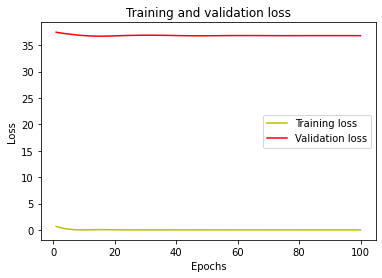


Predicted values are: 
 [[0.05286677]]

Real values are: 
 26735    0.658
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 0.3662 - mean_absolute_error: 0.6051

Mean squared error from neural net: 
 0.3661862313747406

Mean absolute error from neural net: 
 0.6051332354545593

Predicted values are:
  [[0.5 0.5]]

Real values are: 
 26735    0.658
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 154ms/step - loss: 0.0250 - mean_absolute_error: 0.1580

Mean squared error from Convolutional neural net:  0.024963997304439545

Mean absolute error from Convolutional neural net:  0.15799999237060547

Mean squared error from linear regression:  6.46430625

Mean absolute error from linear regression:  2.5425

Mean squared error using decision tree:  0.027224999999999975

Mean absolute error using decision tree:  0.16499999999999992

Mean squared error using Random Forest:  2.532872250000001

Mean absolute error Using Ran

In [241]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from Convolutional neural net:  0.024963997304439545

Mean absolute error from Convolutional neural net:  0.15799999237060547

Mean squared error using decision tree:  0.027224999999999975

Mean absolute error using decision tree:  0.16499999999999992

# 1 Month to predict 1 week

In [242]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_month'] == 9]
train = train.loc[train['connectionTime_year'] == 2018]

In [243]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [244]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [245]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_230 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_231 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_232 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 338ms/step - loss: 104.4328 - mean_absolute_error: 9.4412 - val_loss: 32.9343 - val_mean_absolute_error: 4.4481
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 102.9680 - mean_absolute_error: 9.3625 - val_loss: 31.9367 - val_mean_absolute_error: 4.3299
Epoch 3/100
1/1 [==============================] -

1/1 [==============================] - 0s 18ms/step - loss: 47.8180 - mean_absolute_error: 5.6250 - val_loss: 21.4726 - val_mean_absolute_error: 4.5954
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 46.8459 - mean_absolute_error: 5.6265 - val_loss: 22.7839 - val_mean_absolute_error: 4.7020
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 45.9315 - mean_absolute_error: 5.6265 - val_loss: 24.2620 - val_mean_absolute_error: 4.8117
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 45.0726 - mean_absolute_error: 5.6245 - val_loss: 25.9197 - val_mean_absolute_error: 4.9249
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 44.2670 - mean_absolute_error: 5.6205 - val_loss: 27.7596 - val_mean_absolute_error: 5.0411
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 43.5107 - mean_absolute_error: 5.6142 - val_loss: 29.7893 - val_mean_absolute_error: 5.1600
Epoch 52/100
1/1 [=====

1/1 [==============================] - 0s 51ms/step - loss: 22.8110 - mean_absolute_error: 3.9861 - val_loss: 220.2299 - val_mean_absolute_error: 13.1318
Epoch 96/100
1/1 [==============================] - 0s 22ms/step - loss: 22.4401 - mean_absolute_error: 3.9443 - val_loss: 225.4587 - val_mean_absolute_error: 13.2890
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 22.0773 - mean_absolute_error: 3.9027 - val_loss: 230.7541 - val_mean_absolute_error: 13.4465
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 21.7177 - mean_absolute_error: 3.8606 - val_loss: 236.1169 - val_mean_absolute_error: 13.6043
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 21.3649 - mean_absolute_error: 3.8181 - val_loss: 241.5596 - val_mean_absolute_error: 13.7629
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 21.0194 - mean_absolute_error: 3.7754 - val_loss: 247.1006 - val_mean_absolute_error: 13.9232


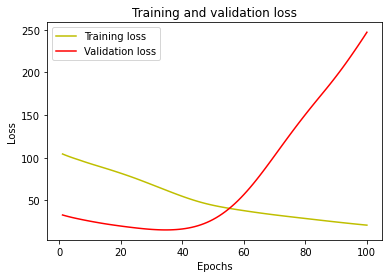


Predicted values are: 
 [[ 7.3940063]
 [ 7.2587314]
 [ 5.0676093]
 [ 3.6822307]
 [18.61277  ]]

Real values are: 
 10739     3.217
10745     8.842
10830    10.685
10930    13.880
11160    13.886
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 79.0714 - mean_absolute_error: 7.2540

Mean squared error from neural net: 
 79.07135009765625

Mean absolute error from neural net: 
 7.253961086273193

Predicted values are:
  [[0.08661477 0.07834683 0.08443679 0.09423532 0.07998352 0.08006615
  0.08612107 0.07654199 0.09312624 0.08441108 0.08788133 0.0682348 ]
 [0.08649777 0.07853361 0.08429244 0.09373033 0.08023306 0.08019994
  0.08613791 0.0767612  0.09280355 0.0842783  0.08768815 0.06884377]
 [0.08525383 0.080589   0.08387595 0.08906608 0.08182891 0.08165129
  0.08499356 0.07989191 0.08855475 0.0839214  0.0855028  0.07487058]
 [0.08373639 0.08263955 0.08341113 0.08455496 0.08306957 0.08303018
  0.08384617 0.08269152 0.08443435 0.08349746 0.0837

In [246]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  44.092632864562965

Mean absolute error using decision tree:  5.49582888888889

Mean squared error using Random Forest:  28.01973215874843

Mean absolute error Using Random Forest:  4.55962271111111

# 6 Month training 1 week predicition

In [247]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [248]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [249]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [250]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_236 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 96ms/step - loss: 172.5457 - mean_absolute_error: 10.6962 - val_loss: 20.6960 - val_mean_absolute_error: 4.0707
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 168.7799 - mean_absolute_error: 10.5076 - val_loss: 18.5162 - val_mean_absolute_error: 3.7810
Epoch 3/100
2/2 [==============================] 

2/2 [==============================] - 0s 17ms/step - loss: 51.7686 - mean_absolute_error: 5.2553 - val_loss: 37.9026 - val_mean_absolute_error: 5.2568
Epoch 47/100
2/2 [==============================] - 0s 17ms/step - loss: 51.6447 - mean_absolute_error: 5.2598 - val_loss: 38.0434 - val_mean_absolute_error: 5.2712
Epoch 48/100
2/2 [==============================] - 0s 17ms/step - loss: 51.5203 - mean_absolute_error: 5.2623 - val_loss: 38.0694 - val_mean_absolute_error: 5.2752
Epoch 49/100
2/2 [==============================] - 0s 17ms/step - loss: 51.4235 - mean_absolute_error: 5.2618 - val_loss: 38.2673 - val_mean_absolute_error: 5.2932
Epoch 50/100
2/2 [==============================] - 0s 17ms/step - loss: 51.2527 - mean_absolute_error: 5.2498 - val_loss: 38.4416 - val_mean_absolute_error: 5.3072
Epoch 51/100
2/2 [==============================] - 0s 17ms/step - loss: 51.0866 - mean_absolute_error: 5.2377 - val_loss: 38.6477 - val_mean_absolute_error: 5.3230
Epoch 52/100
2/2 [=====

Epoch 96/100
2/2 [==============================] - 0s 16ms/step - loss: 47.0920 - mean_absolute_error: 4.9725 - val_loss: 24.6350 - val_mean_absolute_error: 3.7131
Epoch 97/100
2/2 [==============================] - 0s 18ms/step - loss: 46.9887 - mean_absolute_error: 4.9677 - val_loss: 24.4519 - val_mean_absolute_error: 3.6877
Epoch 98/100
2/2 [==============================] - 0s 16ms/step - loss: 46.9265 - mean_absolute_error: 4.9655 - val_loss: 24.0963 - val_mean_absolute_error: 3.6488
Epoch 99/100
2/2 [==============================] - 0s 17ms/step - loss: 46.9148 - mean_absolute_error: 4.9679 - val_loss: 23.7143 - val_mean_absolute_error: 3.6121
Epoch 100/100
2/2 [==============================] - 0s 17ms/step - loss: 46.7587 - mean_absolute_error: 4.9595 - val_loss: 23.3375 - val_mean_absolute_error: 3.5732


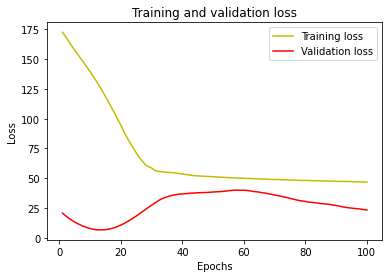


Predicted values are: 
 [[4.83777]]

Real values are: 
 21135    1.029
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 14.5067 - mean_absolute_error: 3.8088

Mean squared error from neural net: 
 14.506728172302246

Mean absolute error from neural net: 
 3.808769941329956

Predicted values are:
  [[0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538

In [251]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 14.158452033996582

Mean absolute error from neural net: 
 3.7627718448638916

Mean squared error from Convolutional neural net:  1.0274161100387573

Mean absolute error from Convolutional neural net:  1.013615369796753

Mean squared error using decision tree:  0.01742399999999997

Mean absolute error using decision tree:  0.1319999999999999


# Space CA-310

# 1 month of training data to predict the demand of 1 space for 1 day

In [252]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [253]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [254]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [255]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_241 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_242 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 354ms/step - loss: 59.0696 - mean_absolute_error: 5.4037 - val_loss: 86.7570 - val_mean_absolute_error: 7.6046
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 58.0801 - mean_absolute_error: 5.3176 - val_loss: 84.7132 - val_mean_absolute_error: 7.4335
Epoch 3/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step - loss: 21.6925 - mean_absolute_error: 3.2601 - val_loss: 67.5415 - val_mean_absolute_error: 7.9667
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 20.7050 - mean_absolute_error: 3.2027 - val_loss: 71.0708 - val_mean_absolute_error: 8.0772
Epoch 48/100
1/1 [==============================] - 0s 19ms/step - loss: 19.7240 - mean_absolute_error: 3.1427 - val_loss: 75.0391 - val_mean_absolute_error: 8.1906
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 18.7518 - mean_absolute_error: 3.0801 - val_loss: 79.4797 - val_mean_absolute_error: 8.3072
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 17.7918 - mean_absolute_error: 3.0150 - val_loss: 84.4234 - val_mean_absolute_error: 8.4273
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 16.8451 - mean_absolute_error: 2.9475 - val_loss: 89.8717 - val_mean_absolute_error: 8.5499
Epoch 52/100
1/1 [=====

1/1 [==============================] - 0s 17ms/step - loss: 0.2439 - mean_absolute_error: 0.3907 - val_loss: 330.3081 - val_mean_absolute_error: 13.6612
Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2155 - mean_absolute_error: 0.3546 - val_loss: 326.3941 - val_mean_absolute_error: 13.5350
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1932 - mean_absolute_error: 0.3210 - val_loss: 322.6455 - val_mean_absolute_error: 13.4136
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1753 - mean_absolute_error: 0.2926 - val_loss: 319.0988 - val_mean_absolute_error: 13.2979
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1610 - mean_absolute_error: 0.2659 - val_loss: 315.7867 - val_mean_absolute_error: 13.1892
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1498 - mean_absolute_error: 0.2409 - val_loss: 312.7336 - val_mean_absolute_error: 13.0881


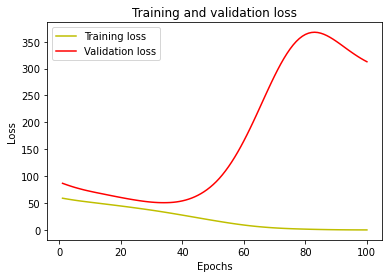


Predicted values are: 
 [[3.026312]]

Real values are: 
 16329    1.57
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 2.1208 - mean_absolute_error: 1.4563

Mean squared error from neural net: 
 2.120844841003418

Mean absolute error from neural net: 
 1.4563120603561401

Predicted values are:
  [[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
  0.11111111 0.11111111 0.11111111]]

Real values are: 
 16329    1.57
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 150ms/step - loss: 2.1284 - mean_absolute_error: 1.4589

Mean squared error from Convolutional neural net:  2.128356695175171

Mean absolute error from Convolutional neural net:  1.4588888883590698

Mean squared error from linear regression:  19.45888149383735

Mean absolute error from linear regression:  4.411222222223377

Mean squared error using decision tree:  146.1681

Mean absolute error using decision tree:  12.09

Mean squared 

In [256]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 1.3893907070159912

Mean absolute error from neural net: 
 1.1787241697311401

Mean squared error from Convolutional neural net:  2.128356695175171

Mean absolute error from Convolutional neural net:  1.4588888883590698


# 1 Month to predict 1 week

In [257]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [258]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [259]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [260]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_246 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_247 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 590ms/step - loss: 80.2897 - mean_absolute_error: 7.7405 - val_loss: 82.0194 - val_mean_absolute_error: 7.3792
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 79.0432 - mean_absolute_error: 7.6614 - val_loss: 80.2634 - val_mean_absolute_error: 7.2605
Epoch 3/100
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step - loss: 27.9140 - mean_absolute_error: 4.3419 - val_loss: 36.4548 - val_mean_absolute_error: 5.0398
Epoch 47/100
1/1 [==============================] - 0s 47ms/step - loss: 27.4103 - mean_absolute_error: 4.3340 - val_loss: 38.4458 - val_mean_absolute_error: 5.1408
Epoch 48/100
1/1 [==============================] - 0s 22ms/step - loss: 26.9682 - mean_absolute_error: 4.3359 - val_loss: 40.7612 - val_mean_absolute_error: 5.2426
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 26.5772 - mean_absolute_error: 4.3345 - val_loss: 43.3969 - val_mean_absolute_error: 5.3455
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 26.2277 - mean_absolute_error: 4.3298 - val_loss: 46.3444 - val_mean_absolute_error: 5.5699
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 25.9108 - mean_absolute_error: 4.3215 - val_loss: 49.5906 - val_mean_absolute_error: 5.7935
Epoch 52/100
1/1 [=====

1/1 [==============================] - 0s 17ms/step - loss: 21.5635 - mean_absolute_error: 3.9667 - val_loss: 100.2503 - val_mean_absolute_error: 8.7556
Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 21.5230 - mean_absolute_error: 3.9672 - val_loss: 99.8293 - val_mean_absolute_error: 8.7366
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 21.4827 - mean_absolute_error: 3.9672 - val_loss: 99.4650 - val_mean_absolute_error: 8.7202
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 21.4431 - mean_absolute_error: 3.9667 - val_loss: 99.1571 - val_mean_absolute_error: 8.7064
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 21.4038 - mean_absolute_error: 3.9658 - val_loss: 98.9071 - val_mean_absolute_error: 8.6952
Epoch 100/100
1/1 [==============================] - 0s 16ms/step - loss: 21.3648 - mean_absolute_error: 3.9644 - val_loss: 98.7113 - val_mean_absolute_error: 8.6864


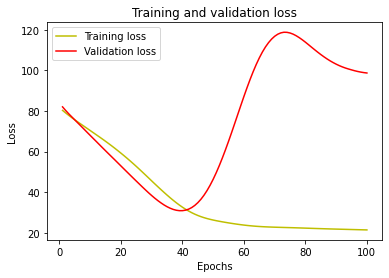


Predicted values are: 
 [[7.722214 ]
 [7.504996 ]
 [7.421841 ]
 [7.285831 ]
 [5.3944793]]

Real values are: 
 3901     3.502
3914    13.865
3968     2.843
3975     6.653
3993     3.432
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 21.6013 - mean_absolute_error: 4.0476

Mean squared error from neural net: 
 21.60134506225586

Mean absolute error from neural net: 
 4.047613620758057

Predicted values are:
  [[0.02681997 0.02699995 0.02912896 0.02996586 0.02659115 0.02989211
  0.02825205 0.02483025 0.02492647 0.02784993 0.03226338 0.03023904
  0.02832406 0.02901956 0.02312659 0.02856288 0.02523785 0.03789294
  0.02605051 0.03265434 0.03139681 0.02994474 0.02465544 0.0258324
  0.02311038 0.02418373 0.02749245 0.02263431 0.02679084 0.02640606
  0.02905542 0.02633236 0.02777567 0.02752758 0.03400192 0.02423207]
 [0.02675244 0.02706083 0.02929117 0.02981383 0.02678199 0.02970715
  0.02847102 0.02507142 0.02487461 0.02790211 0.03211813 0.029830

In [261]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 19.804462432861328

Mean absolute error from neural net: 
 3.8296382427215576

 Mean squared error using Random Forest:  24.197209009119984

Mean absolute error Using Random Forest:  4.2202699999999975

# 6 Month training 1 week predicition

In [262]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [263]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [264]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [265]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_250 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_251 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_252 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 96ms/step - loss: 62.9601 - mean_absolute_error: 5.9732 - val_loss: 118.6718 - val_mean_absolute_error: 8.0926
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 61.1011 - mean_absolute_error: 5.8063 - val_loss: 115.4112 - val_mean_absolute_error: 7.8844
Epoch 3/100
2/2 [==============================] -

2/2 [==============================] - 0s 17ms/step - loss: 27.4060 - mean_absolute_error: 3.9220 - val_loss: 65.6386 - val_mean_absolute_error: 6.0261
Epoch 47/100
2/2 [==============================] - 0s 19ms/step - loss: 27.3838 - mean_absolute_error: 3.9325 - val_loss: 65.7848 - val_mean_absolute_error: 6.0291
Epoch 48/100
2/2 [==============================] - 0s 17ms/step - loss: 27.2422 - mean_absolute_error: 3.9319 - val_loss: 65.9706 - val_mean_absolute_error: 6.0331
Epoch 49/100
2/2 [==============================] - 0s 16ms/step - loss: 27.1758 - mean_absolute_error: 3.9327 - val_loss: 66.1029 - val_mean_absolute_error: 6.0357
Epoch 50/100
2/2 [==============================] - 0s 16ms/step - loss: 27.0798 - mean_absolute_error: 3.9309 - val_loss: 66.2890 - val_mean_absolute_error: 6.0376
Epoch 51/100
2/2 [==============================] - 0s 18ms/step - loss: 27.0315 - mean_absolute_error: 3.9318 - val_loss: 66.3914 - val_mean_absolute_error: 6.0356
Epoch 52/100
2/2 [=====

Epoch 96/100
2/2 [==============================] - 0s 16ms/step - loss: 24.3475 - mean_absolute_error: 3.8314 - val_loss: 80.0454 - val_mean_absolute_error: 5.9409
Epoch 97/100
2/2 [==============================] - 0s 18ms/step - loss: 24.2900 - mean_absolute_error: 3.8252 - val_loss: 80.6985 - val_mean_absolute_error: 5.9676
Epoch 98/100
2/2 [==============================] - 0s 16ms/step - loss: 24.2355 - mean_absolute_error: 3.8209 - val_loss: 81.2849 - val_mean_absolute_error: 5.9893
Epoch 99/100
2/2 [==============================] - 0s 17ms/step - loss: 24.1779 - mean_absolute_error: 3.8180 - val_loss: 81.7115 - val_mean_absolute_error: 6.0043
Epoch 100/100
2/2 [==============================] - 0s 17ms/step - loss: 24.1673 - mean_absolute_error: 3.8251 - val_loss: 82.1200 - val_mean_absolute_error: 6.0184


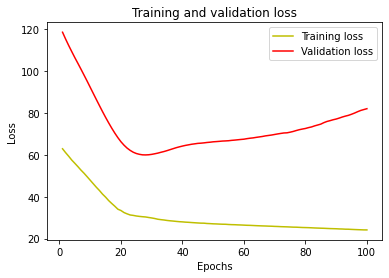


Predicted values are: 
 [[2.9817061]]

Real values are: 
 21133    12.998
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 100.3262 - mean_absolute_error: 10.0163

Mean squared error from neural net: 
 100.32615661621094

Mean absolute error from neural net: 
 10.016294479370117

Predicted values are:
  [[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0

In [266]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  42.89464035915136

Mean absolute error from linear regression:  6.549399999935212

Mean squared error using decision tree:  2.402500000000002

Mean absolute error using decision tree:  1.5500000000000007

# Space CA-149

# 1 month of training data to predict the demand of 1 space for 1 day

In [267]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 10]

In [268]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 11]
test = test.loc[test['connectionTime_day'] == 1]

In [269]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [270]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_255 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_256 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_257 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 349ms/step - loss: 85.1252 - mean_absolute_error: 8.3180 - val_loss: 133.1200 - val_mean_absolute_error: 11.5116
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 83.3165 - mean_absolute_error: 8.2165 - val_loss: 130.6629 - val_mean_absolute_error: 11.4040
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 19ms/step - loss: 14.7894 - mean_absolute_error: 3.0960 - val_loss: 9.1089 - val_mean_absolute_error: 2.7855
Epoch 47/100
1/1 [==============================] - 0s 19ms/step - loss: 14.3054 - mean_absolute_error: 3.0647 - val_loss: 7.4142 - val_mean_absolute_error: 2.4632
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 13.8656 - mean_absolute_error: 3.0272 - val_loss: 5.9201 - val_mean_absolute_error: 2.1404
Epoch 49/100
1/1 [==============================] - 0s 16ms/step - loss: 13.4591 - mean_absolute_error: 2.9833 - val_loss: 4.6333 - val_mean_absolute_error: 1.8186
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 13.0779 - mean_absolute_error: 2.9334 - val_loss: 3.5579 - val_mean_absolute_error: 1.4996
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 12.7170 - mean_absolute_error: 2.8782 - val_loss: 2.6920 - val_mean_absolute_error: 1.2539
Epoch 52/100
1/1

1/1 [==============================] - 0s 17ms/step - loss: 9.1296 - mean_absolute_error: 2.3381 - val_loss: 1.9765 - val_mean_absolute_error: 1.2320
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 9.1256 - mean_absolute_error: 2.3400 - val_loss: 1.9509 - val_mean_absolute_error: 1.2140
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 9.1219 - mean_absolute_error: 2.3416 - val_loss: 1.9332 - val_mean_absolute_error: 1.1996
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 9.1180 - mean_absolute_error: 2.3431 - val_loss: 1.9229 - val_mean_absolute_error: 1.1883
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 9.1138 - mean_absolute_error: 2.3444 - val_loss: 1.9191 - val_mean_absolute_error: 1.1801


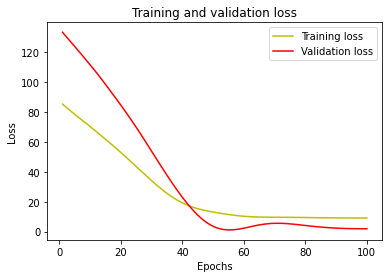


Predicted values are: 
 [[2.187473]]

Real values are: 
 13097    2.605
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 0.1743 - mean_absolute_error: 0.4175

Mean squared error from neural net: 
 0.1743287593126297

Mean absolute error from neural net: 
 0.4175269603729248

Predicted values are:
  [[0.08333334 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334
  0.08333334 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334]]

Real values are: 
 13097    2.605
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 149ms/step - loss: 6.3588 - mean_absolute_error: 2.5217

Mean squared error from Convolutional neural net:  6.3588032722473145

Mean absolute error from Convolutional neural net:  2.5216667652130127

Mean squared error from linear regression:  45.43434025003818

Mean absolute error from linear regression:  6.740500000002832

Mean squared error using decision tree:  12.453841000000002

Mean absolute e

In [271]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 0.05114017054438591

Mean absolute error from neural net: 
 0.22614192962646484

 Mean squared error using Random Forest:  6.310344961599997

Mean absolute error Using Random Forest:  2.5120399999999994

# 1 Month to predict 1 week

In [272]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [273]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [274]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [275]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_260 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_261 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_262 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 339ms/step - loss: 22.3589 - mean_absolute_error: 4.1047 - val_loss: 90.8095 - val_mean_absolute_error: 9.5294
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 21.2782 - mean_absolute_error: 3.9974 - val_loss: 89.0278 - val_mean_absolute_error: 9.4355
Epoch 3/100
1/1 [==============================] - 

1/1 [==============================] - 0s 16ms/step - loss: 0.7417 - mean_absolute_error: 0.6391 - val_loss: 8.8622 - val_mean_absolute_error: 2.9769
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 0.6939 - mean_absolute_error: 0.6183 - val_loss: 8.5185 - val_mean_absolute_error: 2.9187
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 0.6453 - mean_absolute_error: 0.5910 - val_loss: 8.2859 - val_mean_absolute_error: 2.8785
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5970 - mean_absolute_error: 0.5577 - val_loss: 8.1425 - val_mean_absolute_error: 2.8535
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 0.5506 - mean_absolute_error: 0.5348 - val_loss: 8.0782 - val_mean_absolute_error: 2.8422
Epoch 51/100
1/1 [==============================] - 0s 44ms/step - loss: 0.5072 - mean_absolute_error: 0.5395 - val_loss: 8.0845 - val_mean_absolute_error: 2.8433
Epoch 52/100
1/1 [=================

1/1 [==============================] - 0s 17ms/step - loss: 0.0073 - mean_absolute_error: 0.0752 - val_loss: 10.6292 - val_mean_absolute_error: 3.2603
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_absolute_error: 0.0704 - val_loss: 10.6235 - val_mean_absolute_error: 3.2594
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0651 - val_loss: 10.6238 - val_mean_absolute_error: 3.2594
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0042 - mean_absolute_error: 0.0592 - val_loss: 10.6293 - val_mean_absolute_error: 3.2603
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0529 - val_loss: 10.6393 - val_mean_absolute_error: 3.2618


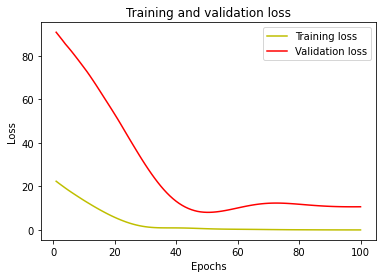


Predicted values are: 
 [[1.6199118]
 [1.3099917]
 [3.2648973]
 [3.288044 ]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 348.2539 - mean_absolute_error: 11.1683

Mean squared error from neural net: 
 348.2539367675781

Mean absolute error from neural net: 
 11.16826057434082

Predicted values are:
  [[0.23957899 0.2497193  0.2665566  0.24414511]
 [0.2396898  0.25022662 0.26221114 0.24787247]
 [0.2518968  0.26010293 0.256967   0.23103325]
 [0.25188723 0.2601939  0.25704783 0.23087105]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 148ms/step - loss: 366.9418 - mean_absolute_error: 10.6735

Mean squared error from Convolutional neural net:  366.9417724609375

Mean absolute error from Convolutional neural net:  10.673501014709473

Mean squared error 

In [276]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 341.9559631347656

Mean absolute error from neural net: 
 11.07658863067627

 
Mean squared error using Random Forest:  332.3196518386749

Mean absolute error Using Random Forest:  12.410937499999996


# 6 Month training 1 week predicition

In [277]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [278]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [279]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [280]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_266 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_267 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 341ms/step - loss: 27.5754 - mean_absolute_error: 4.5929 - val_loss: 97.1552 - val_mean_absolute_error: 9.8567
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 26.4845 - mean_absolute_error: 4.4878 - val_loss: 94.7503 - val_mean_absolute_error: 9.7340
Epoch 3/100
1/1 [==============================] - 

1/1 [==============================] - 0s 16ms/step - loss: 1.3111 - mean_absolute_error: 0.9387 - val_loss: 12.3057 - val_mean_absolute_error: 3.5079
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 1.2148 - mean_absolute_error: 0.9328 - val_loss: 11.4456 - val_mean_absolute_error: 3.3831
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 1.1412 - mean_absolute_error: 0.9250 - val_loss: 10.6960 - val_mean_absolute_error: 3.2705
Epoch 49/100
1/1 [==============================] - 0s 16ms/step - loss: 1.0874 - mean_absolute_error: 0.9151 - val_loss: 10.0569 - val_mean_absolute_error: 3.1713
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 1.0523 - mean_absolute_error: 0.9038 - val_loss: 9.5221 - val_mean_absolute_error: 3.0858
Epoch 51/100
1/1 [==============================] - 0s 16ms/step - loss: 1.0312 - mean_absolute_error: 0.8910 - val_loss: 9.0919 - val_mean_absolute_error: 3.0153
Epoch 52/100
1/1 [=============

1/1 [==============================] - 0s 17ms/step - loss: 0.2942 - mean_absolute_error: 0.4254 - val_loss: 11.9916 - val_mean_absolute_error: 3.4629
Epoch 97/100
1/1 [==============================] - 0s 16ms/step - loss: 0.2839 - mean_absolute_error: 0.4174 - val_loss: 11.8936 - val_mean_absolute_error: 3.4487
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 0.2738 - mean_absolute_error: 0.4110 - val_loss: 11.8069 - val_mean_absolute_error: 3.4361
Epoch 99/100
1/1 [==============================] - 0s 19ms/step - loss: 0.2642 - mean_absolute_error: 0.4043 - val_loss: 11.7321 - val_mean_absolute_error: 3.4252
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2548 - mean_absolute_error: 0.3974 - val_loss: 11.6693 - val_mean_absolute_error: 3.4160


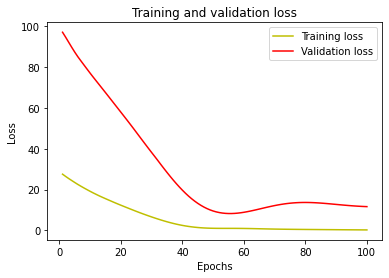


Predicted values are: 
 [[2.4052255]
 [1.9706599]
 [3.5148695]
 [3.541065 ]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 336.0292 - mean_absolute_error: 10.9325

Mean squared error from neural net: 
 336.0291748046875

Mean absolute error from neural net: 
 10.932511329650879

Predicted values are:
  [[0.23811072 0.259669   0.24499528 0.25722498]
 [0.23906504 0.25980034 0.24780728 0.2533273 ]
 [0.22014931 0.24730891 0.27302292 0.25951883]
 [0.21987884 0.2472548  0.2732464  0.2596199 ]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 148ms/step - loss: 366.9419 - mean_absolute_error: 10.6735

Mean squared error from Convolutional neural net:  366.94189453125

Mean absolute error from Convolutional neural net:  10.673501014709473

Mean squared error f

In [281]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 332.8988342285156

Mean absolute error from neural net: 
 10.70800495147705

Mean squared error using decision tree:  284.55755099999993

Mean absolute error using decision tree:  13.3385

# Space CA-511

# 1 month of training data to predict the demand of 1 space for 1 day

In [282]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [283]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'] == 1]

In [284]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [285]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_271 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_272 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 337ms/step - loss: 75.0365 - mean_absolute_error: 7.2525 - val_loss: 259.5514 - val_mean_absolute_error: 12.7400
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 73.3787 - mean_absolute_error: 7.1422 - val_loss: 256.8689 - val_mean_absolute_error: 12.6375
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 17ms/step - loss: 25.3025 - mean_absolute_error: 4.4029 - val_loss: 114.8081 - val_mean_absolute_error: 7.3984
Epoch 47/100
1/1 [==============================] - 0s 19ms/step - loss: 25.0356 - mean_absolute_error: 4.3705 - val_loss: 112.0774 - val_mean_absolute_error: 7.3406
Epoch 48/100
1/1 [==============================] - 0s 19ms/step - loss: 24.7923 - mean_absolute_error: 4.3392 - val_loss: 109.5008 - val_mean_absolute_error: 7.2831
Epoch 49/100
1/1 [==============================] - 0s 19ms/step - loss: 24.5629 - mean_absolute_error: 4.3087 - val_loss: 107.0848 - val_mean_absolute_error: 7.2262
Epoch 50/100
1/1 [==============================] - 0s 19ms/step - loss: 24.3413 - mean_absolute_error: 4.2791 - val_loss: 104.8327 - val_mean_absolute_error: 7.1700
Epoch 51/100
1/1 [==============================] - 0s 19ms/step - loss: 24.1238 - mean_absolute_error: 4.2505 - val_loss: 102.7476 - val_mean_absolute_error: 7.1149
Epoc

1/1 [==============================] - 0s 18ms/step - loss: 18.6824 - mean_absolute_error: 3.7217 - val_loss: 83.7917 - val_mean_absolute_error: 7.8276
Epoch 96/100
1/1 [==============================] - 0s 19ms/step - loss: 18.6310 - mean_absolute_error: 3.7140 - val_loss: 83.7117 - val_mean_absolute_error: 7.8363
Epoch 97/100
1/1 [==============================] - 0s 19ms/step - loss: 18.5811 - mean_absolute_error: 3.7066 - val_loss: 83.6328 - val_mean_absolute_error: 7.8449
Epoch 98/100
1/1 [==============================] - 0s 19ms/step - loss: 18.5321 - mean_absolute_error: 3.6992 - val_loss: 83.5603 - val_mean_absolute_error: 7.8536
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 18.4841 - mean_absolute_error: 3.6920 - val_loss: 83.4917 - val_mean_absolute_error: 7.8621
Epoch 100/100
1/1 [==============================] - 0s 19ms/step - loss: 18.4369 - mean_absolute_error: 3.6850 - val_loss: 83.4262 - val_mean_absolute_error: 7.8703


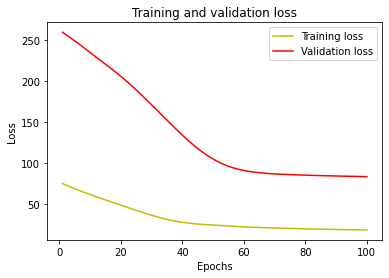


Predicted values are: 
 [[ 4.2450857]
 [ 2.1915426]
 [10.048799 ]]

Real values are: 
 10737    11.133
10743     7.058
10753     6.163
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 28.7417 - mean_absolute_error: 5.2134

Mean squared error from neural net: 
 28.741735458374023

Mean absolute error from neural net: 
 5.213389873504639

Predicted values are:
  [[0.0375624  0.04767368 0.04079859 0.04118013 0.03817002 0.03962996
  0.04684708 0.04509167 0.04157362 0.04338996 0.04116658 0.04290684
  0.04448301 0.04508965 0.04576361 0.04973118 0.04172741 0.04556738
  0.04607224 0.04024633 0.04807859 0.04687149 0.04037848]
 [0.04205624 0.04440242 0.04240099 0.04283689 0.04206023 0.0427688
  0.04421015 0.04372953 0.04273915 0.04409459 0.04327577 0.04337572
  0.04333207 0.04403157 0.04338414 0.04539976 0.04274916 0.04459848
  0.04435644 0.04283992 0.04522168 0.04376649 0.04236985]
 [0.0398187  0.04440991 0.04184698 0.04383679 0.04347429 0.03859026

In [286]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 22.274343490600586

Mean absolute error from neural net: 
 4.468023300170898

 Mean squared error using decision tree:  27.891446999999996

Mean absolute error using decision tree:  4.433666666666666

# 1 Month to predict 1 week

In [287]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [288]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [289]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [290]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_275 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_276 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_277 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 345ms/step - loss: 79.2592 - mean_absolute_error: 7.5683 - val_loss: 275.9608 - val_mean_absolute_error: 13.3392
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 77.6887 - mean_absolute_error: 7.4658 - val_loss: 272.8488 - val_mean_absolute_error: 13.2231
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 19ms/step - loss: 29.3228 - mean_absolute_error: 4.7723 - val_loss: 144.2633 - val_mean_absolute_error: 8.5866
Epoch 47/100
1/1 [==============================] - 0s 19ms/step - loss: 28.6755 - mean_absolute_error: 4.7317 - val_loss: 141.0433 - val_mean_absolute_error: 8.4546
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 28.0809 - mean_absolute_error: 4.6902 - val_loss: 137.8830 - val_mean_absolute_error: 8.3212
Epoch 49/100
1/1 [==============================] - 0s 19ms/step - loss: 27.5403 - mean_absolute_error: 4.6479 - val_loss: 134.7902 - val_mean_absolute_error: 8.1865
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 27.0561 - mean_absolute_error: 4.6054 - val_loss: 131.7741 - val_mean_absolute_error: 8.0509
Epoch 51/100
1/1 [==============================] - 0s 24ms/step - loss: 26.6260 - mean_absolute_error: 4.5695 - val_loss: 128.8464 - val_mean_absolute_error: 7.9149
Epoc

1/1 [==============================] - 0s 18ms/step - loss: 19.9146 - mean_absolute_error: 3.8661 - val_loss: 88.0824 - val_mean_absolute_error: 7.5524
Epoch 96/100
1/1 [==============================] - 0s 19ms/step - loss: 19.8383 - mean_absolute_error: 3.8594 - val_loss: 87.9120 - val_mean_absolute_error: 7.5625
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 19.7641 - mean_absolute_error: 3.8526 - val_loss: 87.7396 - val_mean_absolute_error: 7.5728
Epoch 98/100
1/1 [==============================] - 0s 19ms/step - loss: 19.6918 - mean_absolute_error: 3.8456 - val_loss: 87.5663 - val_mean_absolute_error: 7.5834
Epoch 99/100
1/1 [==============================] - 0s 18ms/step - loss: 19.6220 - mean_absolute_error: 3.8385 - val_loss: 87.3931 - val_mean_absolute_error: 7.5942
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 19.5536 - mean_absolute_error: 3.8314 - val_loss: 87.2206 - val_mean_absolute_error: 7.6050


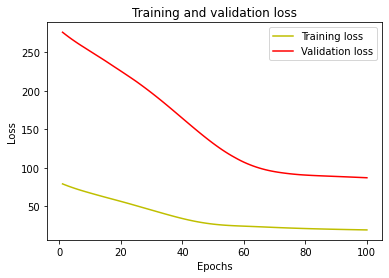


Predicted values are: 
 [[ 6.1860423]
 [ 6.0418563]
 [ 5.832639 ]
 [ 4.612807 ]
 [10.361717 ]]

Real values are: 
 10737    11.133
10743     7.058
10753     6.163
10926     8.300
11022    13.893
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 15.4147 - mean_absolute_error: 3.3167

Mean squared error from neural net: 
 15.41474437713623

Mean absolute error from neural net: 
 3.3166887760162354

Predicted values are:
  [[0.04414026 0.03998664 0.0461713  0.04230433 0.0465434  0.04581048
  0.04739793 0.04171944 0.04386704 0.04295443 0.04431369 0.04183342
  0.04559489 0.04182848 0.04342989 0.04206713 0.04122538 0.04543496
  0.04144394 0.04160099 0.04542104 0.04207866 0.04283226]
 [0.04418013 0.04009836 0.04615165 0.04236921 0.04645187 0.04574674
  0.04723189 0.04171258 0.04383812 0.04304035 0.04422249 0.04187729
  0.04557038 0.04188753 0.04334145 0.04205304 0.04127599 0.04535874
  0.04150378 0.04171548 0.04533398 0.04216382 0.04287511]
 [0.04

In [291]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 16.70981216430664

Mean absolute error from neural net: 
 3.279749631881714

 
Mean squared error from linear regression:  33.69077866010826

Mean absolute error from linear regression:  4.493740802610845

# 6 Month training 1 week predicition

In [292]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([4,5,6,7,8,9])]

In [293]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [294]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [295]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_281 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_282 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 96ms/step - loss: 87.5113 - mean_absolute_error: 7.8262 - val_loss: 150.6136 - val_mean_absolute_error: 9.6122
Epoch 2/100
2/2 [==============================] - 0s 19ms/step - loss: 85.1969 - mean_absolute_error: 7.6827 - val_loss: 147.4326 - val_mean_absolute_error: 9.4412
Epoch 3/100
2/2 [==============================] -

Epoch 46/100
2/2 [==============================] - 0s 19ms/step - loss: 25.7368 - mean_absolute_error: 4.3684 - val_loss: 71.9199 - val_mean_absolute_error: 6.4921
Epoch 47/100
2/2 [==============================] - 0s 18ms/step - loss: 25.6253 - mean_absolute_error: 4.3602 - val_loss: 71.6234 - val_mean_absolute_error: 6.4651
Epoch 48/100
2/2 [==============================] - 0s 21ms/step - loss: 25.5790 - mean_absolute_error: 4.3583 - val_loss: 71.2161 - val_mean_absolute_error: 6.4272
Epoch 49/100
2/2 [==============================] - 0s 18ms/step - loss: 25.4340 - mean_absolute_error: 4.3505 - val_loss: 70.8990 - val_mean_absolute_error: 6.3939
Epoch 50/100
2/2 [==============================] - 0s 18ms/step - loss: 25.3489 - mean_absolute_error: 4.3461 - val_loss: 70.6640 - val_mean_absolute_error: 6.3707
Epoch 51/100
2/2 [==============================] - 0s 21ms/step - loss: 25.2707 - mean_absolute_error: 4.3427 - val_loss: 70.4360 - val_mean_absolute_error: 6.3478
Epoch 52/1

Epoch 96/100
2/2 [==============================] - 0s 18ms/step - loss: 23.3877 - mean_absolute_error: 4.1978 - val_loss: 69.5459 - val_mean_absolute_error: 6.0891
Epoch 97/100
2/2 [==============================] - 0s 19ms/step - loss: 23.3849 - mean_absolute_error: 4.1989 - val_loss: 69.6993 - val_mean_absolute_error: 6.0982
Epoch 98/100
2/2 [==============================] - 0s 18ms/step - loss: 23.3071 - mean_absolute_error: 4.1893 - val_loss: 69.5067 - val_mean_absolute_error: 6.0707
Epoch 99/100
2/2 [==============================] - 0s 19ms/step - loss: 23.3291 - mean_absolute_error: 4.1907 - val_loss: 69.2025 - val_mean_absolute_error: 6.0348
Epoch 100/100
2/2 [==============================] - 0s 18ms/step - loss: 23.2488 - mean_absolute_error: 4.1818 - val_loss: 68.9911 - val_mean_absolute_error: 6.0064


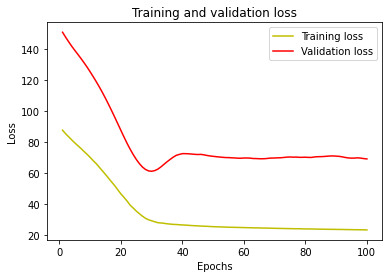


Predicted values are: 
 [[6.4313455]
 [6.333489 ]
 [6.1859818]
 [4.0181127]
 [6.9967713]]

Real values are: 
 10737    11.133
10743     7.058
10753     6.163
10926     8.300
11022    13.893
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 15ms/step - loss: 14.7951 - mean_absolute_error: 2.8540

Mean squared error from neural net: 
 14.79507064819336

Mean absolute error from neural net: 
 2.854024887084961

Predicted values are:
  [[0.01508021 0.01457241 0.01508151 0.01540575 0.01579978 0.01558159
  0.01507723 0.01592345 0.01587067 0.01469008 0.01617975 0.01559536
  0.0164512  0.01396419 0.01554842 0.0142903  0.01625678 0.01516016
  0.01552749 0.01549877 0.01556798 0.01576265 0.01682236 0.01513017
  0.01504887 0.01585405 0.01468656 0.01538887 0.01537864 0.0151877
  0.01596147 0.01524682 0.01631569 0.01589596 0.01576146 0.01475425
  0.01497235 0.01550765 0.01531756 0.01549154 0.01406602 0.01566449
  0.01618093 0.01627701 0.01624662 0.01563726 0.01444447 0.01

In [296]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 13.738385200500488

Mean absolute error from neural net: 
 3.272716522216797

 
Mean squared error using Random Forest:  42.1449649392832

Mean absolute error Using Random Forest:  4.5062983333333255

# Overall for Individual Spaces

When ran on the 33 different DataFrames the following models occured:

Sequential Neural Network: 20 Times

Convolutional Neural Network: 6 Times

Linear Regression: 9 Times

Decision Tree: 13 Times

Random Forest: 18 Times

# General

Some scores are extremely low such as:

Space 506

1 Month 1 Day

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281600000201

Mean absolute error Using Random Forest:  0.6604000000000152

I think this is a sign of underfitting and there not being enough data for some spaces to accurately create a model. However some scores are more reasonable and still more accurate than for all the spaces, I believe in some cases indivual space predicitions are possible and can have value due to their improved accuracy.

# Overall

The sequential Neural Network was most often the most effective at creating predicitons.

The models were more effective when data was reduced to predict on a single spaces demand